In [1]:
import numpy as np
import gymnasium as gym
import itertools
import pandas as pd
from tqdm import tqdm
import copy
from plotnine import *

### Setup: Creating the world

In [ ]:
action_space_i = np.round(np.arange(-0.03, 0.035, 0.005), 4)
action_space_i
# action_space_i[6] = 0


array([-0.03 , -0.025, -0.02 , -0.015, -0.01 , -0.005,  0.   ,  0.005,
        0.01 ,  0.015,  0.02 ,  0.025,  0.03 ])

In [ ]:
# Useful theme for plots 
def theme_economy():
    """Custom theme for plotnine"""
    return theme_minimal() + theme(
        figure_size=(12, 8),
        legend_position='bottom',
        axis_text_x=element_text(angle=45, hjust=1, size=18),
        axis_text_y=element_text(size=18),
        axis_title=element_text(size=24),
        plot_title=element_text(size=26, face='bold'),
        strip_text=element_text(size=16),
        plot_subtitle=element_text(size=22),
        legend_text=element_text(size=16)
    )

In [1]:
import gymnasium as gym
import numpy as np
import copy

class EconomySim(gym.Env):

    def __init__(self,
        noise_gdp: float = 1.0,
        noise_pi: float = 0.005,
        noise_init: float = 0.003,
        noise_r_star: float = 0.001,
        taylor = False,
        i_min: float = -0.05,      
        i_max: float = 0.15,
        train_loss = True
        ):

        self.train_loss = train_loss
        self.taylor = taylor
        self.i_min = i_min
        self.i_max = i_max

        # Starting variables
        self.r_star = 0.02
        self.pi_e = 0.02
        self.pi_target = 0.02
        self.pi = 0.02
        self.y_star = 100
        self.y = 100
        self.i = 0.02
        self.i_exp = 0.02
        self.last_statement = 1
        self.last_change_direction = 1
        self.theta = 0

        self.last_y = 100
        self.last_pi = 0.02
        
        ## Memory
        self.memory_window = 45
        ## Statement priors
        self.hawkish = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5])
        self.doveish = np.array([5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        self.hold = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 40, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        self.no_guidance = np.ones(13, dtype = int) * 3.5

        self.expectations_array = [self.doveish, self.hold, self.hawkish, self.no_guidance]
        self.history = []

        # Defining possible interest rate moves
        self.interest_rate_moves = np.round(np.arange(-0.03, 0.035, 0.005), 4)
        self.interest_rate_moves[6] = 0.0

        # NEW: Observation space now includes action mask
        self.observation_space = gym.spaces.Dict({
            "y": gym.spaces.Box(-np.inf, np.inf, shape=(1,)),
            "pi": gym.spaces.Box(-np.inf, np.inf, shape=(1,)),
            "last_statement": gym.spaces.Discrete(4),
            "i": gym.spaces.Box(-np.inf, np.inf, shape=(1,)),
            "i_exp": gym.spaces.Box(-np.inf, np.inf, shape=(1,)),
            "last_change_direction": gym.spaces.Discrete(3),
            "last_y" : gym.spaces.Box(-np.inf, np.inf, shape=(1,)),
            "last_pi" : gym.spaces.Box(-np.inf, np.inf, shape=(1,))
        })
        
        self.action_space = gym.spaces.MultiDiscrete([
            len(self.interest_rate_moves),
            4 
        ])
        
        self.max_steps = 500
        self.current_step = 0

        self.noise_gdp = noise_gdp
        self.noise_pi = noise_pi
        self.noise_init = noise_init
        self.r_star_noise = noise_r_star

    def _get_obs(self):
        """Convert internal state to observation format with action mask."""
        if self.taylor == True:
            obs = {
                "y": np.array([self.y], dtype=np.float32),
                "pi": np.array([self.pi], dtype=np.float32),
                "last_statement": int(self.last_statement),
                "i": np.array([self.i], dtype=np.float32),
                "i_exp": np.array([self.i_exp], dtype=np.float32),
                "last_change_direction": int(self.last_change_direction),
                "last_y" : np.array([self.last_y], dtype=np.float32),
                "last_pi" : np.array([self.last_pi], dtype=np.float32),
            }    
        else:
            scale_factor = 1
            scaled_y = ((self.y - self.y_star) / self.y_star) * scale_factor
            scaled_pi = self.pi * scale_factor
            scaled_i = self.i * scale_factor
            scaled_i_exp = self.i_exp * scale_factor
            scaled_last_y = ((self.last_y - self.y_star) / self.y_star) * scale_factor
            scaled_last_pi = self.last_pi * scale_factor
            
            obs = {
                "y": np.array([scaled_y], dtype=np.float32),
                "pi": np.array([scaled_pi], dtype=np.float32),
                "last_statement": int(self.last_statement),
                "i": np.array([scaled_i], dtype=np.float32),
                "i_exp": np.array([scaled_i_exp], dtype=np.float32),
                "last_change_direction": int(self.last_change_direction),
                "last_y" : np.array([scaled_last_y], dtype=np.float32),
                "last_pi" : np.array([scaled_last_pi], dtype=np.float32),
            }

        return obs
    
    def _get_info(self):
        """Useful for inspecting what is going on in the economy."""
        return {
            "pi_e": self.pi_e,
            "pi": self.pi,
            "last_statement": self.last_statement,
            "y": self.y,
            "i": self.i,
            "expect_array": copy.deepcopy(self.expectations_array),
            "i_exp": self.i_exp,
            "theta": self.theta,
            "r_star": self.r_star
        }

    def reset(self, seed: int | None = None, options: dict | None = None):
        """Start a new episode."""
        super().reset(seed=seed)

        self.y_star = 100  
        self.pi_target = 0.02 
        self.r_star = 0.02 

        self.y = self.np_random.normal(100, self.noise_gdp)
        self.pi_e = self.np_random.normal(0.02, self.noise_init)
        self.pi = self.np_random.normal(self.pi_e, self.noise_init)
        self.i = 0.02
        self.i_exp = self.np_random.normal(0.02, self.noise_init)
        self.theta = 0
        self.last_y = self.y
        self.last_pi = self.pi

        self.hawkish = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5])
        self.doveish = np.array([5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        self.hold = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 40, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        self.no_guidance = np.ones(13, dtype = int) * 3.5

        self.expectations_array = [self.doveish, self.hold, self.hawkish, self.no_guidance]
        self.history = []
        self.current_step = 0

        self.last_statement = 1 
        self.last_change_direction = 1

        observation = self._get_obs()
        info = self._get_info()

        return observation, info
    
    def compute_theta(self):
        """Computes theta: measure of 'unanchoredness' of inflation expectations"""
        if self.pi > self.pi_target:
            k = 30
        else:
            k = -20

        theta_var = 0.9
        theta_actual = theta_var * (1 - np.exp(-k * (self.pi - self.pi_target)))
        theta_actual = np.clip(theta_actual, 0, 1)

        return theta_actual
        
    def step(self, action):
        """Execute one timestep within the environment."""
        self.current_step += 1

        self.last_y = self.y
        self.last_pi = self.pi
        
        rate_change = self.interest_rate_moves[action[0]]

        # Clip interest rate to stay within bounds
        self.i = np.clip(self.i + rate_change, self.i_min, self.i_max)

        if rate_change > 0:
            actual_move = 2
        elif rate_change < 0:
            actual_move = 0
        elif rate_change == 0:
            actual_move = 1

        self.last_change_direction = actual_move

        ### Update market expectations
        last_statement_expectations = self.expectations_array[self.last_statement]
        if self.last_statement == 3:
            update = 1
        elif self.last_statement == actual_move:
            update = 1
        else:
            update = 3

        last_statement_expectations[action[0]] += update
        self.expectations_array[self.last_statement] = last_statement_expectations

        self.history.append((action[0], self.last_statement, update))

        if len(self.history) > self.memory_window:
            oldest_action_id, oldest_statement, oldest_update = self.history[0]
            alpha_array = self.expectations_array[oldest_statement]
            alpha_array[oldest_action_id] -= oldest_update
            self.expectations_array[oldest_statement] = alpha_array
            self.history.pop(0)

        ### Compute expected interest rate
        current_statement = action[1]
        alpha = self.expectations_array[current_statement]

        probs = alpha / alpha.sum()
        self.i_exp = self.i + np.dot(probs, self.interest_rate_moves)
        
        omega = 0.6
        i_eff = omega * self.i + (1 - omega) * self.i_exp

        ### Computing inflation expectations
        self.theta = self.compute_theta()
        self.pi_e = (1 - self.theta) * self.pi_target + self.theta * self.pi

        real_interest_rate = i_eff - self.pi_e

        sigma = 200
        kappa = 0.5

        self.r_star = self.r_star + self.np_random.normal(0, self.r_star_noise)

        gdp_persistence = 0.5
        y_equilibirum = self.y_star - sigma * (real_interest_rate - self.r_star)

        self.y = gdp_persistence * self.y + (1 - gdp_persistence) * y_equilibirum + self.np_random.normal(0, self.noise_gdp)
        self.pi = self.pi_e + kappa * ((self.y - self.y_star) / self.y_star) + self.np_random.normal(0, self.noise_pi)

        y_deviation = ((self.y - self.y_star) / self.y_star) * 100
        pi_deviation = (self.pi - self.pi_target) * 100

        # Add penalty for extreme interest rates
        i_deviation = 0
        if self.i > 0.10:
            i_deviation = (self.i - 0.10) * 100
        elif self.i < -0.01:
            i_deviation = (-0.01 - self.i) * 100

        smoothing_loss = rate_change * 100
        smoothing_weight = 0.3

        if self.train_loss == True:
            loss = 0.5 * ((y_deviation) ** 2 + (pi_deviation) ** 2 + 0.3 * (i_deviation) ** 2 + smoothing_weight * smoothing_loss ** 2)
        else:
            loss = 0.5 * ((y_deviation) ** 2 + (pi_deviation) ** 2)
        # loss = np.log(1 + loss)
        reward = -1 * loss
        
        self.last_statement = current_statement
        self.last_change = rate_change

        terminated = False
        truncated = False

        # if self.i > 0.15 or self.i < -0.05:
        #     reward -= 15000
        
        # if self.y < 50 or self.y > 150:
        #     reward -= 10_000
            
        # if self.pi > 0.25 or self.pi < -0.15:
        #     reward -= 15000

        if self.y <= 20 or self.y > 180 or np.isnan(self.y):
            terminated = True

        if self.current_step >= self.max_steps:
            truncated = True

        info = self._get_info()

        return self._get_obs(), reward, terminated, truncated, info

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor 
import os

def make_env():
    env = EconomySim(taylor=True)
    env = Monitor(env)
    return env

# Here I vectorise the environment so that it can be normalised in the next step
env = DummyVecEnv([make_env])

# Normalisation wrapper
env = VecNormalize(
    env, 
    norm_obs=True,           # Normalize observations
    norm_reward=True,        # ENABLED: Normalize rewards
    clip_obs=10.,            # Clip extreme observations
    clip_reward=10.,         # Clip extreme rewards
    gamma=0.99,              # Discount factor for reward normalization
    norm_obs_keys=["pi", "y", "i", "i_exp", "last_y", "last_pi"]
)
# env = VecNormalize(env, norm_obs=True, clip_obs=10., norm_obs_keys=["pi", "y", "i", "i_exp"])

# Initialize the Agent
model = PPO("MultiInputPolicy",
            env, verbose=1,
            tensorboard_log="tensorboard",
            ent_coef=0.01
            )

# Train for 2M iterations
model.learn(total_timesteps = 2_000_000)

# Saving...
model.save("ppo_final_2M")
env.save("vec_normalize_final_2M.pkl")

print("Training complete. Model and Stats saved.")

Using cpu device
Logging to tensorboard\PPO_7
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 10.9      |
|    ep_rew_mean     | -1.93e+04 |
| time/              |           |
|    fps             | 312       |
|    iterations      | 1         |
|    time_elapsed    | 6         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 11.5          |
|    ep_rew_mean          | -1.94e+04     |
| time/                   |               |
|    fps                  | 303           |
|    iterations           | 2             |
|    time_elapsed         | 13            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.011596656   |
|    clip_fraction        | 0.102         |
|    clip_range           | 0.2           |
|    entropy_loss         | -3.9

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor

def MC_traj_ppo(n_sims, n_steps, model_path, vec_norm_path, deterministic=True):
    """
    Run Monte Carlo simulations using a trained PPO policy.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulation trajectories
    n_steps : int
        Maximum steps per trajectory
    model_path : str
        Path to saved PPO model (e.g., "ppo_economy_agent")
    vec_norm_path : str
        Path to saved VecNormalize stats (e.g., "vec_normalize_stats.pkl")
    deterministic : bool
        Whether to use deterministic policy (True for evaluation)
    
    Returns:
    --------
    list of DataFrames, one per trajectory
    """
    
    # Setup environment with normalization
    def make_env():
        env = EconomySim(taylor=True, train_loss=False)
        env = Monitor(env)
        return env
    
    eval_env = DummyVecEnv([make_env])
    eval_env = VecNormalize.load(vec_norm_path, eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    
    # Load model
    model = PPO.load(model_path, env=eval_env)
    
    trajectories = []
    
    for sim_id in tqdm(range(n_sims), desc="Running PPO simulations"):
        # Reset environment
        obs = eval_env.reset()
        
        # Get initial unnormalized state from the underlying environment
        initial_env = eval_env.envs[0]
        initial_y = initial_env.y
        initial_pi = initial_env.pi
        initial_i = initial_env.i
        
        gdps = [float(initial_y)]
        infl = [float(initial_pi)]
        interest_rates = [float(initial_i)]
        statements = [None]
        rate_changes = [None]
        rewards_list = [None]
        
        # These will be filled after first step
        i_exp_list = [None]
        theta_list = [None]
        pi_e_list = [None]
        r_star_list = [None]
        expect_array = [None]
        step_list = [0]
        
        done = False
        step = 0
        
        while step < n_steps and not done:
            step += 1
            
            # Get action from PPO policy
            action, _states = model.predict(obs, deterministic=deterministic)
            
            # Extract action components
            rate_change_id = int(action[0][0])
            statement = int(action[0][1])
            
            # Get the actual rate change
            rate_change = eval_env.envs[0].interest_rate_moves[rate_change_id]
            
            # Step environment
            obs, reward, done, info = eval_env.step(action)
            
            current_y = float(info[0]["y"])
            current_pi = float(info[0]["pi"])
            current_i = float(info[0]["i"])
            new_i = float(current_i + rate_change)
            current_i_exp = float(info[0]["i_exp"])
            
            # Append step data (using UNNORMALIZED values)
            gdps.append(current_y)
            infl.append(current_pi)
            rate_changes.append(float(rate_change))
            statements.append(int(statement))
            interest_rates.append(new_i)
            rewards_list.append(float(reward[0]))
            
            # Info-based variables
            i_exp_list.append(current_i_exp)
            theta_list.append(float(info[0]["theta"]))
            pi_e_list.append(float(info[0]["pi_e"]))
            r_star_list.append(float(info[0]["r_star"]))
            expect_array.append(info[0]["expect_array"])
            step_list.append(step)
            
            if done[0]:
                break
        
        # Fill in step 0 values from step 1 (or use reasonable defaults)
        if len(i_exp_list) > 1:
            i_exp_list[0] = i_exp_list[1]
            theta_list[0] = 0.0
            pi_e_list[0] = 0.02
            r_star_list[0] = 0.02
            expect_array[0] = expect_array[1]
        
        # Build dataframe
        df = pd.DataFrame({
            "step": step_list,
            "GDP": gdps,
            "Inflation": infl,
            "delta_i": rate_changes,
            "statements": statements,
            "i": interest_rates,
            "reward": rewards_list,
            "i_exp": i_exp_list,
            "expect_array": expect_array,
            "trajectory": sim_id,
            "theta": theta_list,
            "pi_e": pi_e_list,
            "r_star": r_star_list,
            "type": "PPO",
        })
        
        trajectories.append(df)
    
    return trajectories


N_SIMS = 1500
N_STEPS = 250


# traj_ppo = MC_traj_ppo(
#             n_sims=N_SIMS,
#             n_steps=N_STEPS,
#             model_path="ppo_economy_agent_new_1_5_M.zip",
#             vec_norm_path = "vec_normalize_stats_new_1_5_M.pkl"
#             )
# ppo_df = pd.concat(traj_ppo, ignore_index=True)

ppo_traj = MC_traj_ppo(
            n_sims=N_SIMS,
            n_steps=N_STEPS,
            model_path="ppo_final_2M.zip",
            vec_norm_path = "vec_normalize_final_2M.pkl"
            )
ppo_df = pd.concat(ppo_traj, ignore_index=True)

# ppo_df

In [101]:
ppo_df.to_pickle("ppo_df.pkl")

In [ ]:
# Now I create some benchmark policies by way of the Taylor rule
# They are pretty simple to implement (hence why I use them) but they can be quite simplistic.

def MC_traj_taylor(n_sims, n_steps, guidance=True, rho = 0):
    trajectories = []
    for sim_id in tqdm(range(n_sims)):
        env = EconomySim(taylor=True, train_loss=False)
        obs, info = env.reset()

        # LOG THE INITIAL STATE (Step 0)
        gdps = [float(obs["y"])]
        infl = [float(obs["pi"])]
        interest_rates = [float(obs["i"])]
        statements = [None]
        rate_changes = [None]
        rewards_list = [None]
        
        # Info-based variables
        i_exp_list = [float(info.get("i_exp", 0.02))]
        theta_list = [float(info.get("theta", 0.0))]
        pi_e_list = [float(info.get("pi_e", 0.02))]
        r_star_list = [float(info.get("r_star", 0.02))]
        expect_array = [info["expect_array"]]
        step_list = [0]


        for step in range(1, n_steps + 1):

            # Taylor rule calculation 
            obs_pi = obs["pi"]
            obs_y = obs["y"]
            obs_i = obs["i"]

            taylor_i = (
                0.02
                + obs_pi
                + 0.5 * (obs_pi - 0.02)
                + 0.5 * ((obs_y - 100) / 100)
            )

            taylor_i = rho * obs_i + (1 - rho) * taylor_i

            distance = np.abs(
                np.round(action_space_i + obs_i, 4) - taylor_i
            )
            rate_change_id = np.argmin(distance)
            rate_change = action_space_i[rate_change_id]

            rate_changes.append(rate_change)
            interest_rates.append(float(obs_i + rate_change))

            # Guidance rule
            if guidance:
                if rate_change > 0:
                    statement = 2  # Hawkish
                elif rate_change < 0:
                    statement = 0  # Dovish
                else:
                    statement = 1  # Hold
            else:
                statement = 3  # "no guidance"

            statements.append(statement)

            action = [int(rate_change_id), int(statement)]
            obs, reward, terminated, truncated, info = env.step(action)

            # extract vars
            gdps.append(float(obs["y"]))
            infl.append(float(obs["pi"]))
            rewards_list.append(reward)
            i_exp_list.append(float(info["i_exp"]))
            theta_list.append(float(info["theta"]))
            pi_e_list.append(float(info["pi_e"]))
            r_star_list.append(float(info["r_star"]))
            step_list.append(step)
            expect_array.append(info["expect_array"])

            if terminated or truncated:
                break
        
        guidance_type = "guidance" if guidance == True else "no guidance"
        smoothing_type = "pure" if rho == 0 else "smooth"
        run_type = f"Taylor {guidance_type} {smoothing_type}"

        # build dataframe
        df = pd.DataFrame({
            "step": step_list,
            "GDP": gdps,
            "Inflation": infl,
            "delta_i": rate_changes,
            "statements": statements,
            "i": interest_rates,
            "reward": rewards_list,
            "i_exp": i_exp_list,
            "expect_array" : expect_array,
            "trajectory": sim_id,
            "theta" : theta_list,
            "pi_e" : pi_e_list,
            "r_star" : r_star_list,
            "type": run_type,
        })

        trajectories.append(df)

    return trajectories


N_SIMS = 1500
N_STEPS = 250

# "Pure" Taylor rule (w/ forward guidance)
trajectories_guide = MC_traj_taylor(N_SIMS, N_STEPS, guidance = True, rho = 0)
full_panel_guide = pd.concat(trajectories_guide, ignore_index=True)

# "Smooth" Taylor rule (with guidance)
trajectories_smooth_guide = MC_traj_taylor(N_SIMS, N_STEPS, guidance=True, rho = 0.75)
full_panel_smooth_guide = pd.concat(trajectories_smooth_guide, ignore_index=True)

# "Smooth" Taylor without guidance
trajectories_smooth_classic = MC_traj_taylor(N_SIMS, N_STEPS, guidance=False, rho = 0.75)
full_panel_smooth_classic = pd.concat(trajectories_smooth_classic, ignore_index=True)

  0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:61: DeprecationWarning: Convers

In [231]:
full_panel_guide.to_pickle("pure_taylor_draws.pkl")
full_panel_smooth_guide.to_pickle("smooth_taylor_guide_draws.pkl")
full_panel_smooth_classic.to_pickle("smooth_taylor_no_guide_draws.pkl")

(376306, 14)
(376500, 14)


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2660368305.py:61: DeprecationWarning: Conversion

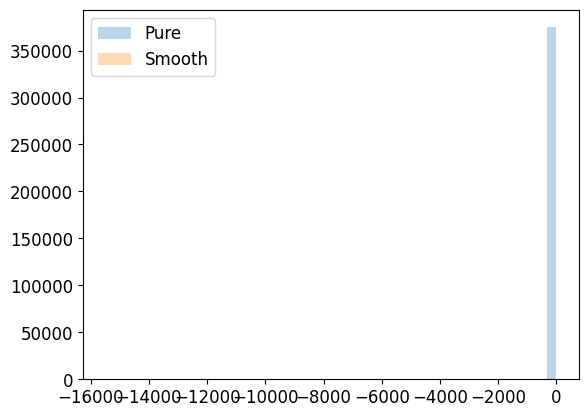

0.718
0.6946666666666667
0.5146666666666667
PPO
0.9106666666666666
0.7473333333333333
0.8993333333333333


In [ ]:
# Initial tests to see which policies are better
rewards_sum = full_panel_guide.groupby("trajectory")["reward"].sum()
rewards_sum_smooth = full_panel_smooth_guide.groupby("trajectory")["reward"].sum()
rewards_sum_smooth_no_guide = full_panel_smooth_classic.groupby("trajectory")["reward"].sum()
rewards_sum_ppo = ppo_df.groupby("trajectory")["reward"].sum()

print((rewards_sum_smooth > rewards_sum).mean())
print((rewards_sum_smooth > rewards_sum_smooth_no_guide).mean())
print((rewards_sum > rewards_sum_smooth_no_guide).mean())
print("PPO")
print((rewards_sum_ppo > rewards_sum).mean())
print((rewards_sum_ppo > rewards_sum_smooth).mean())
print((rewards_sum_ppo > rewards_sum_smooth_no_guide).mean())

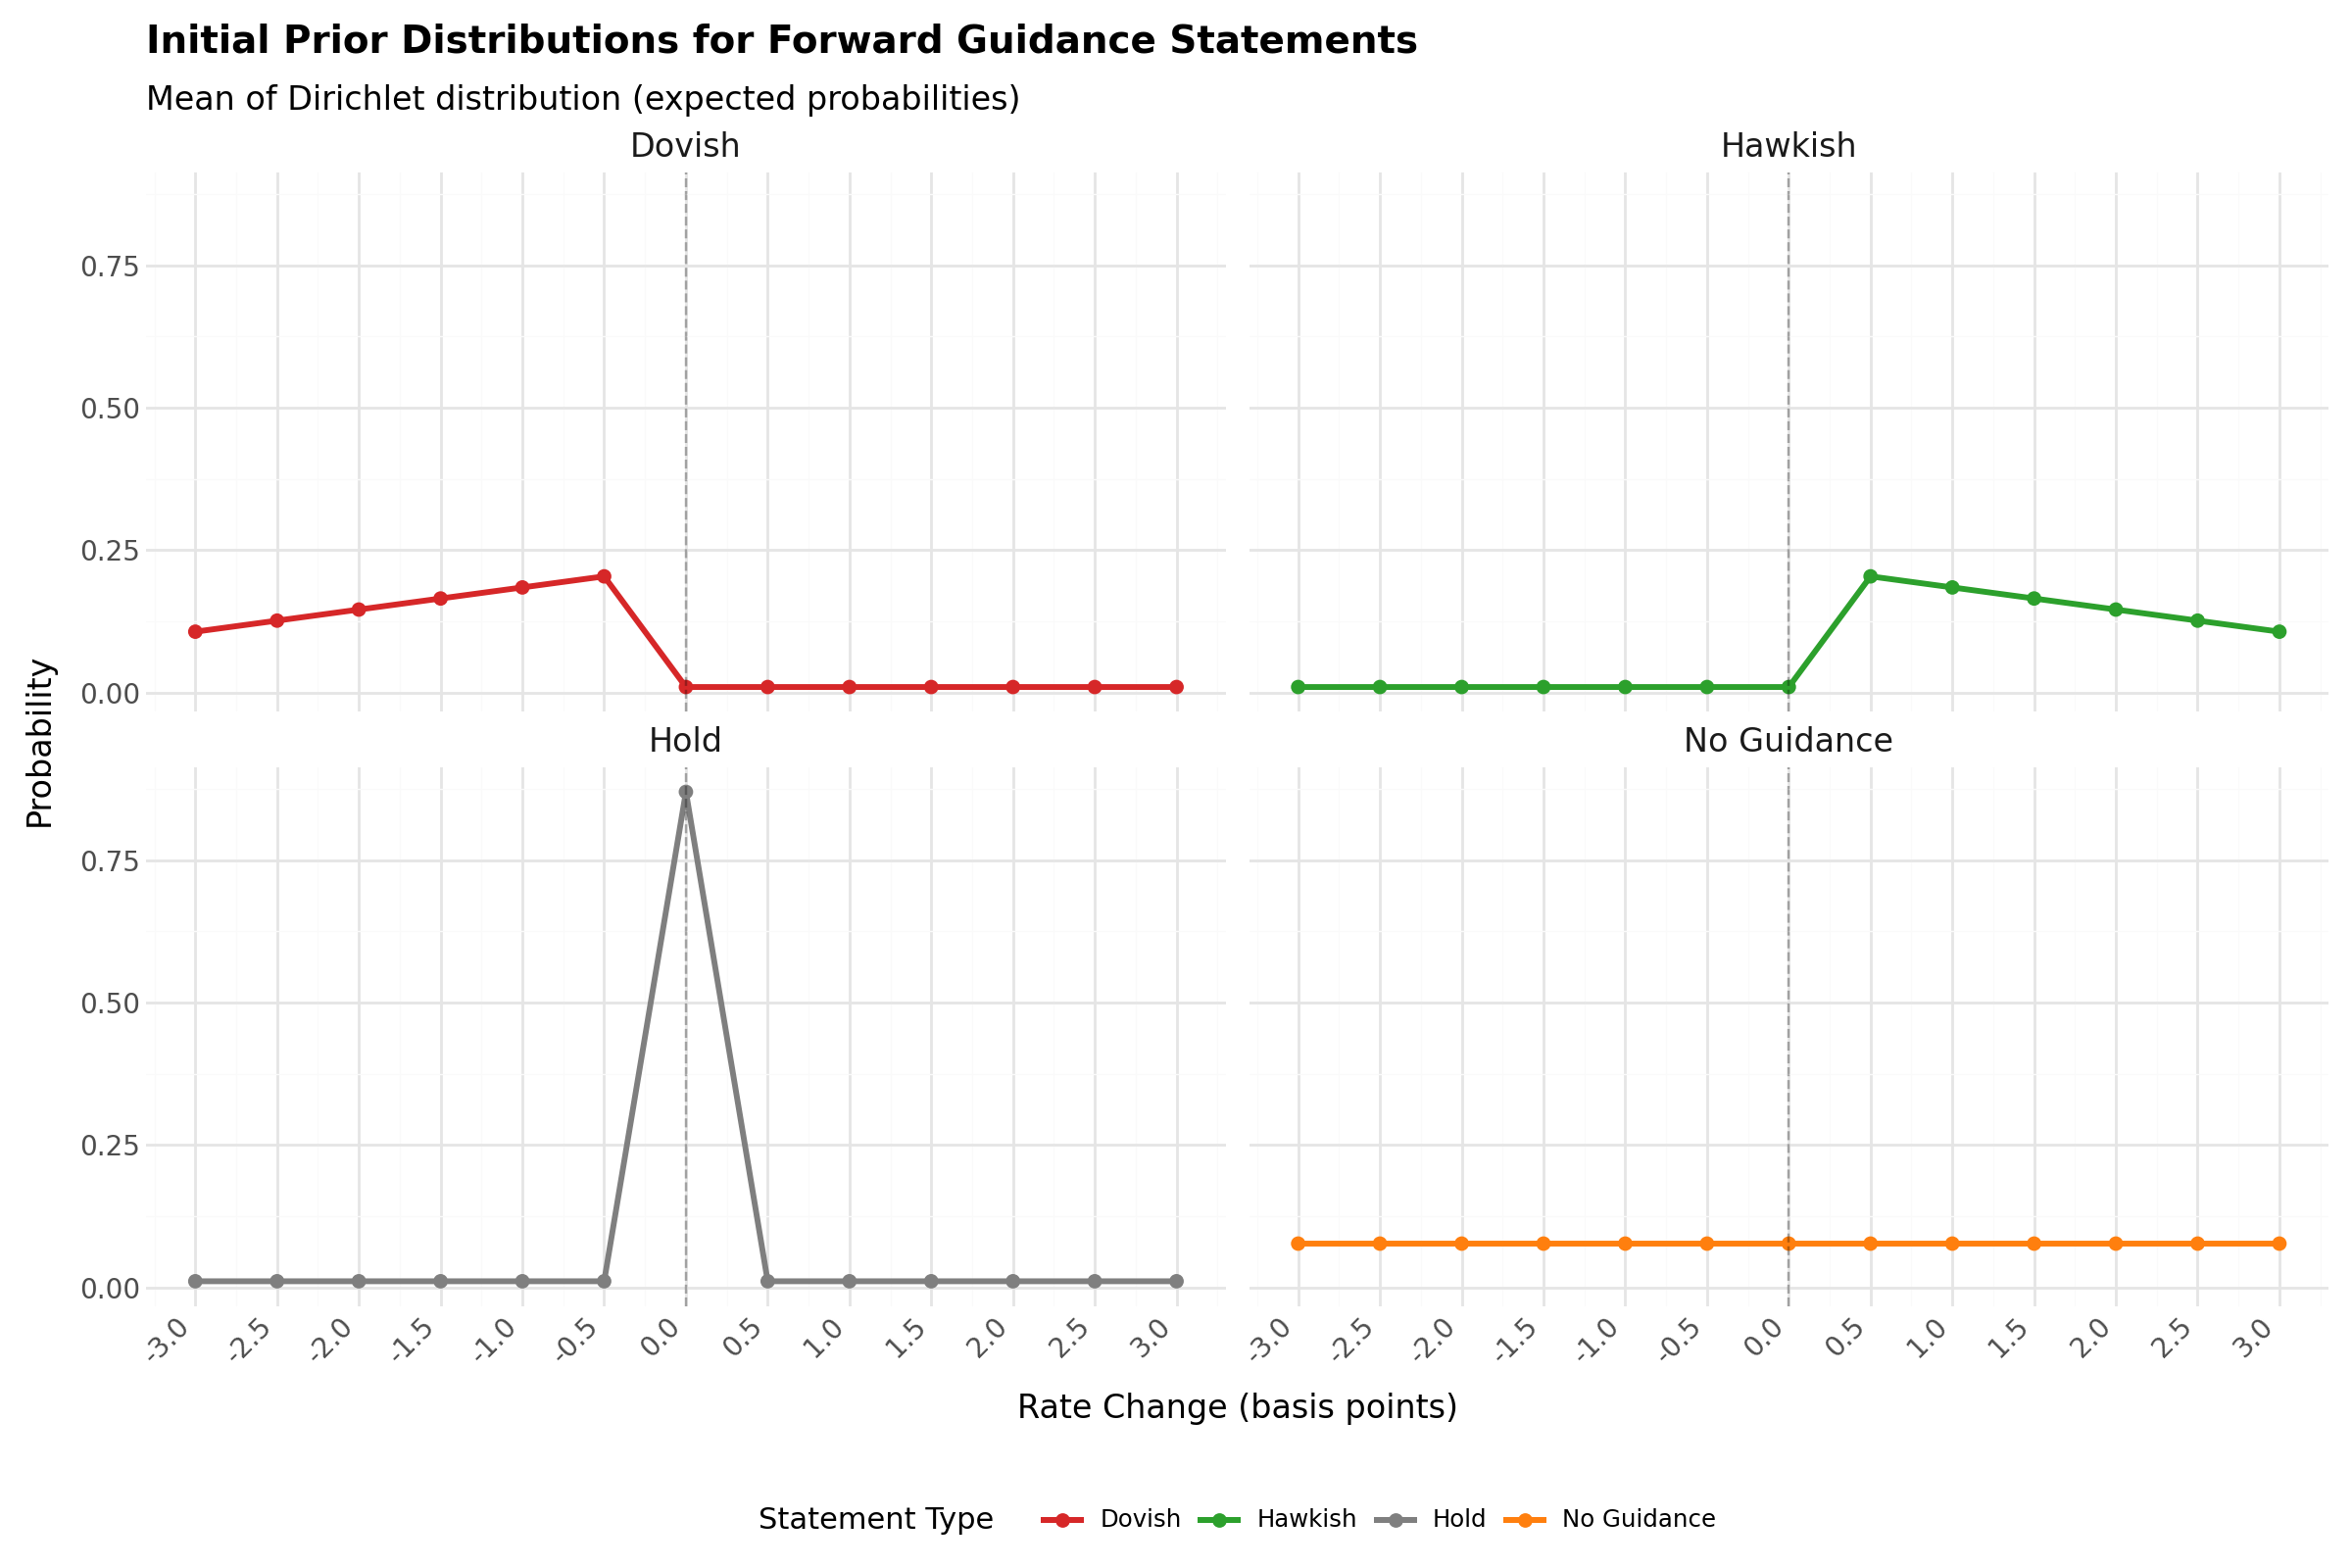

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/priors.pdf


In [ ]:
def plot_prior_distributions():
    """
    Plot the initial prior distributions for all statement types.
    Shows the Dirichlet priors as probability distributions over rate changes.
    """
    # Define the priors from the model
    hawkish = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 10.5, 9.5, 8.5, 7.5, 6.5, 5.5])
    dovish = np.array([5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    hold = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 40, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    no_guidance = np.ones(13) * 3.5
    
    # Interest rate moves
    interest_rate_moves = np.round(np.arange(-0.03, 0.035, 0.005), 4)
    interest_rate_moves[6] = 0.0
    
    # Statement names and alphas
    statements = {
        'Dovish': dovish,
        'Hold': hold,
        'Hawkish': hawkish,
        'No Guidance': no_guidance
    }
    
    # Build dataframe
    rows = []
    for stmt_name, alpha in statements.items():
        # Mean of Dirichlet = alpha / sum(alpha)
        probs = alpha / alpha.sum()
        
        for i, rate_move in enumerate(interest_rate_moves):
            rows.append({
                'statement_type': stmt_name,
                'rate_change': rate_move * 100,  # Convert to basis points
                'probability': probs[i]
            })
    
    prior_df = pd.DataFrame(rows)
    
    # Create the plot
    p = (
        ggplot(prior_df, aes(x='rate_change', y='probability', color='statement_type')) +
        geom_line(size=1.2) +
        geom_point(size=2) +
        geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3) +
        facet_wrap('~statement_type', ncol=2) +
        scale_color_manual(values={
            'Dovish': '#d62728',
            'Hold': '#7f7f7f',
            'Hawkish': '#2ca02c',
            'No Guidance': '#ff7f0e'
        }) +
        labs(
            title='Initial Prior Distributions for Forward Guidance Statements',
            subtitle='Mean of Dirichlet distribution (expected probabilities)',
            x='Rate Change (basis points)',
            y='Probability',
            color='Statement Type'
        ) +
        scale_x_continuous(breaks=interest_rate_moves * 100) +
        theme_economy()
        # theme_minimal() +
        # theme(
        #     figure_size=(12, 8),
        #     legend_position='none',  # Redundant with facets
        #     axis_text_x=element_text(angle=45, hjust=1, size=8),
        #     plot_title=element_text(size=14, face='bold'),
        #     strip_text=element_text(size=12),
        #     plot_subtitle=element_text(size=12)
        # )
    )
    
    return p

priors_plot = plot_prior_distributions()
display(priors_plot)

priors_plot.save(figspriors.pdf")

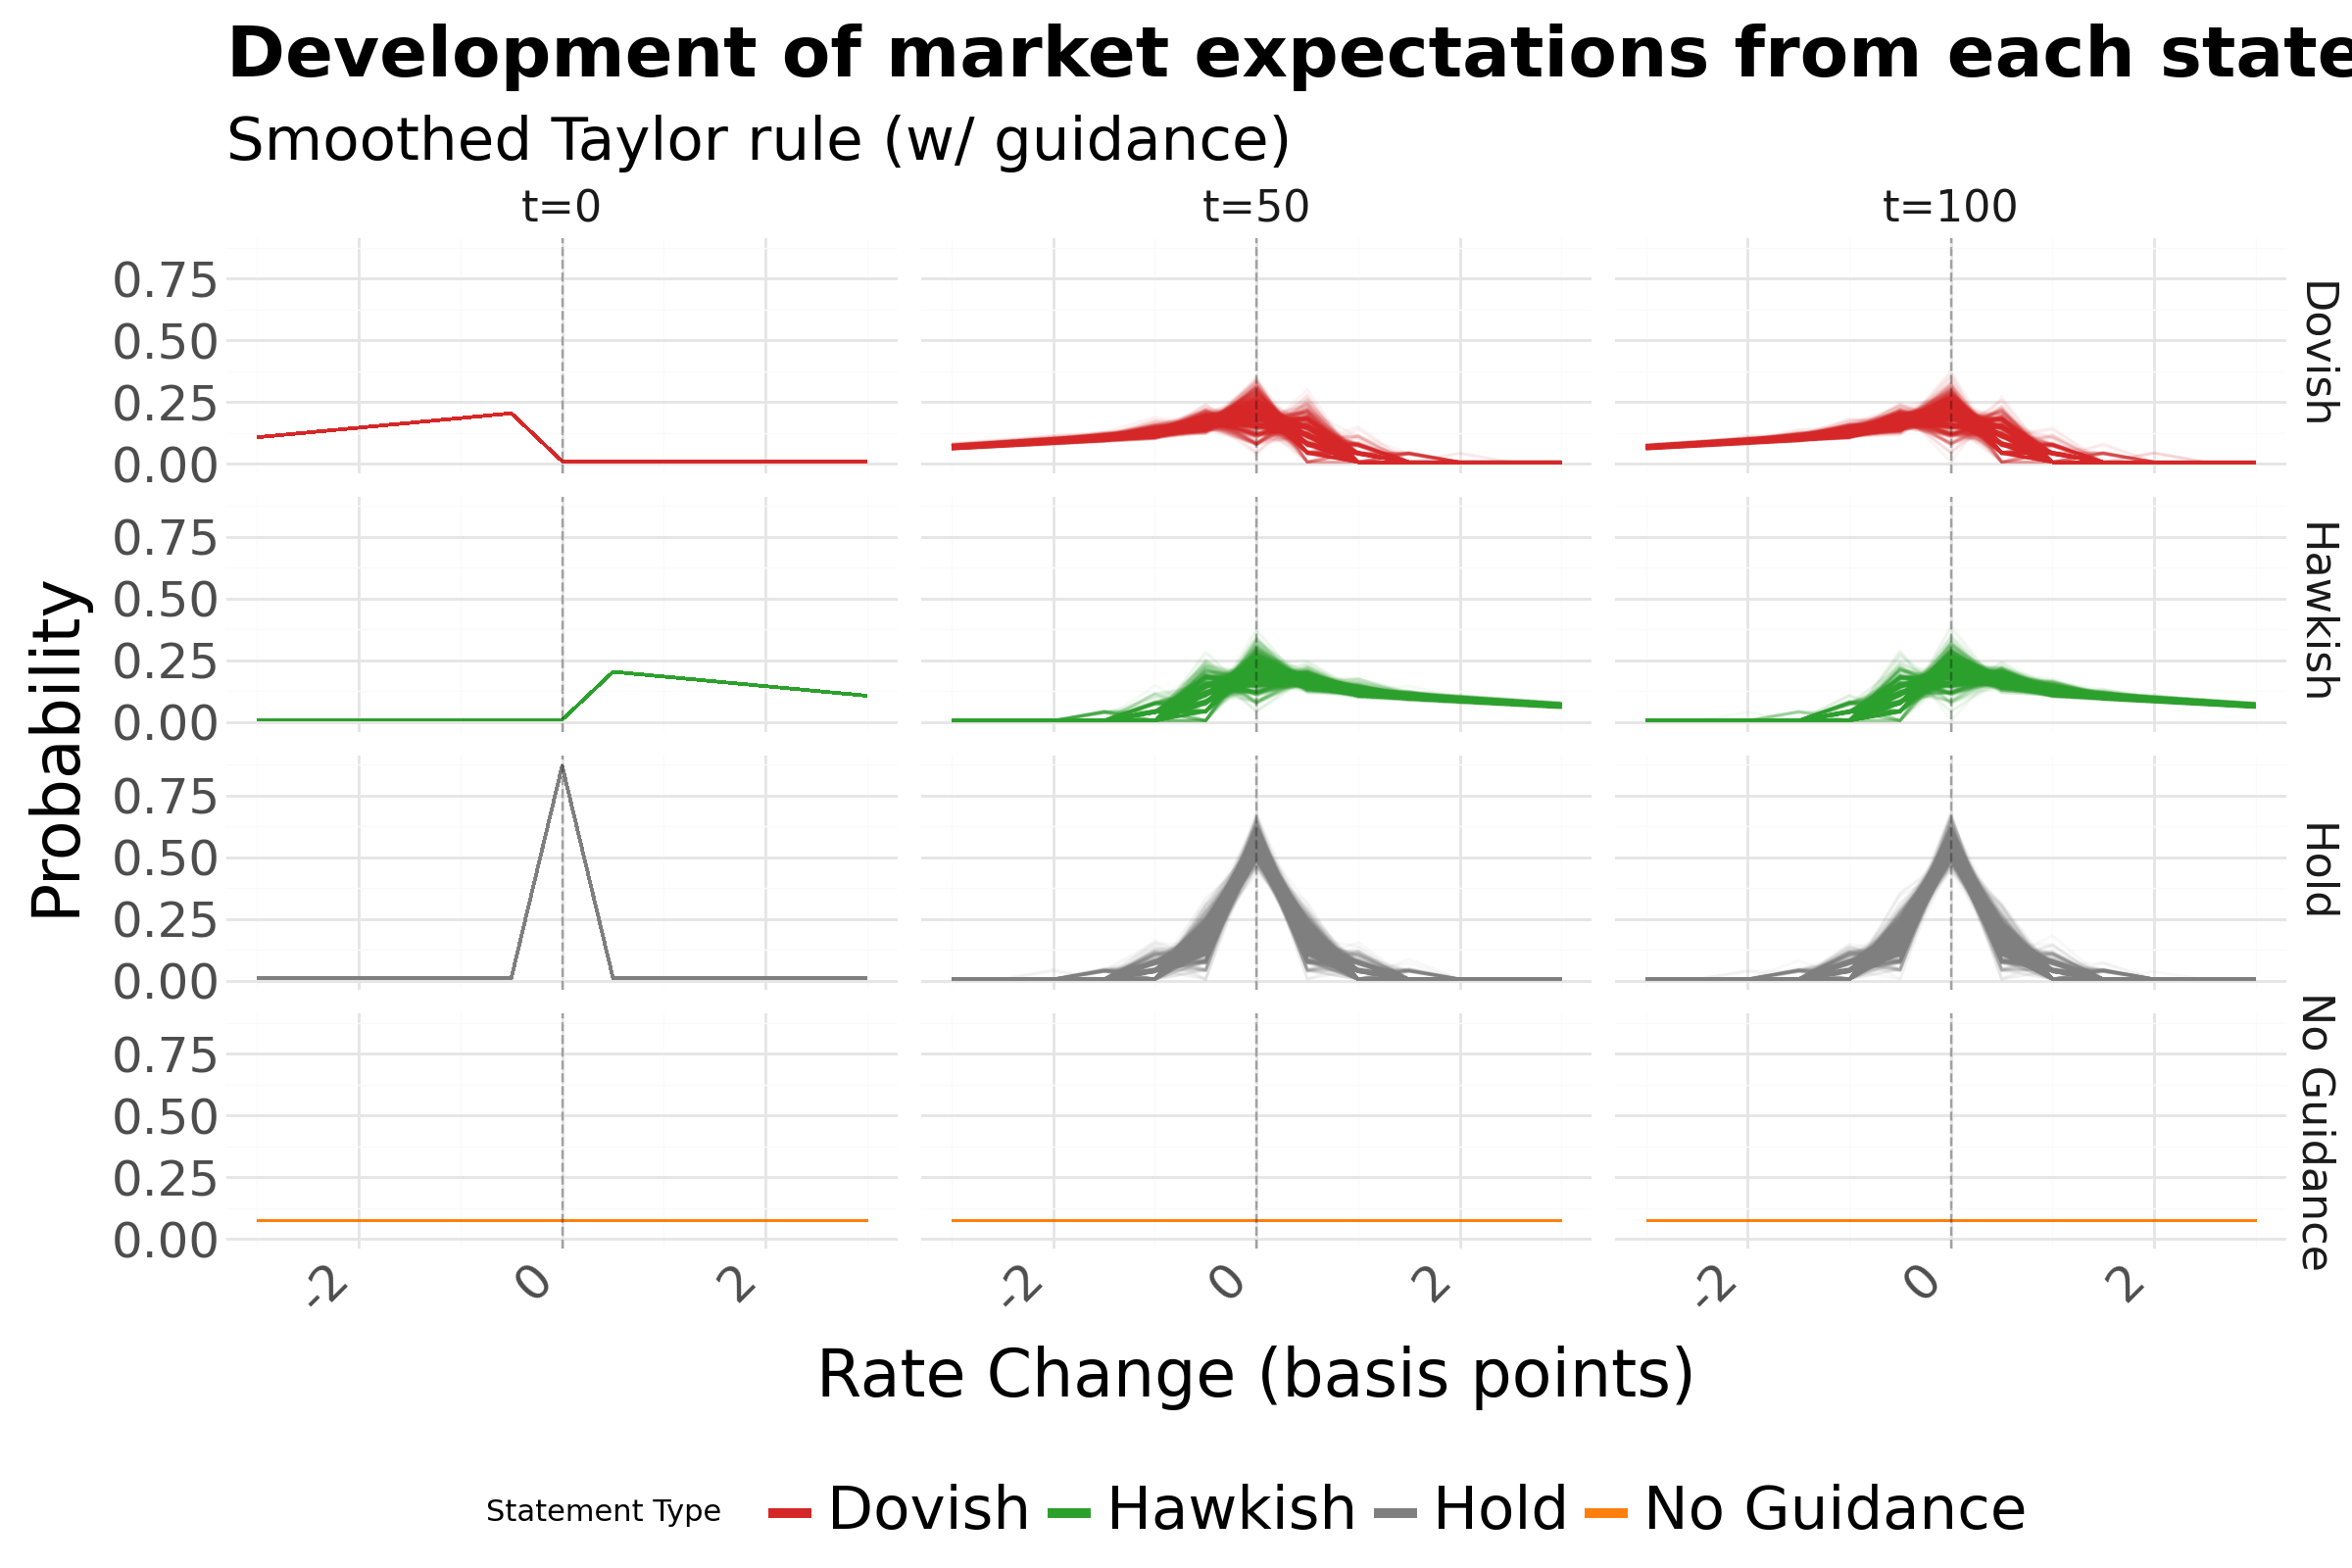

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/spaguetti_smooth_guidance.pdf


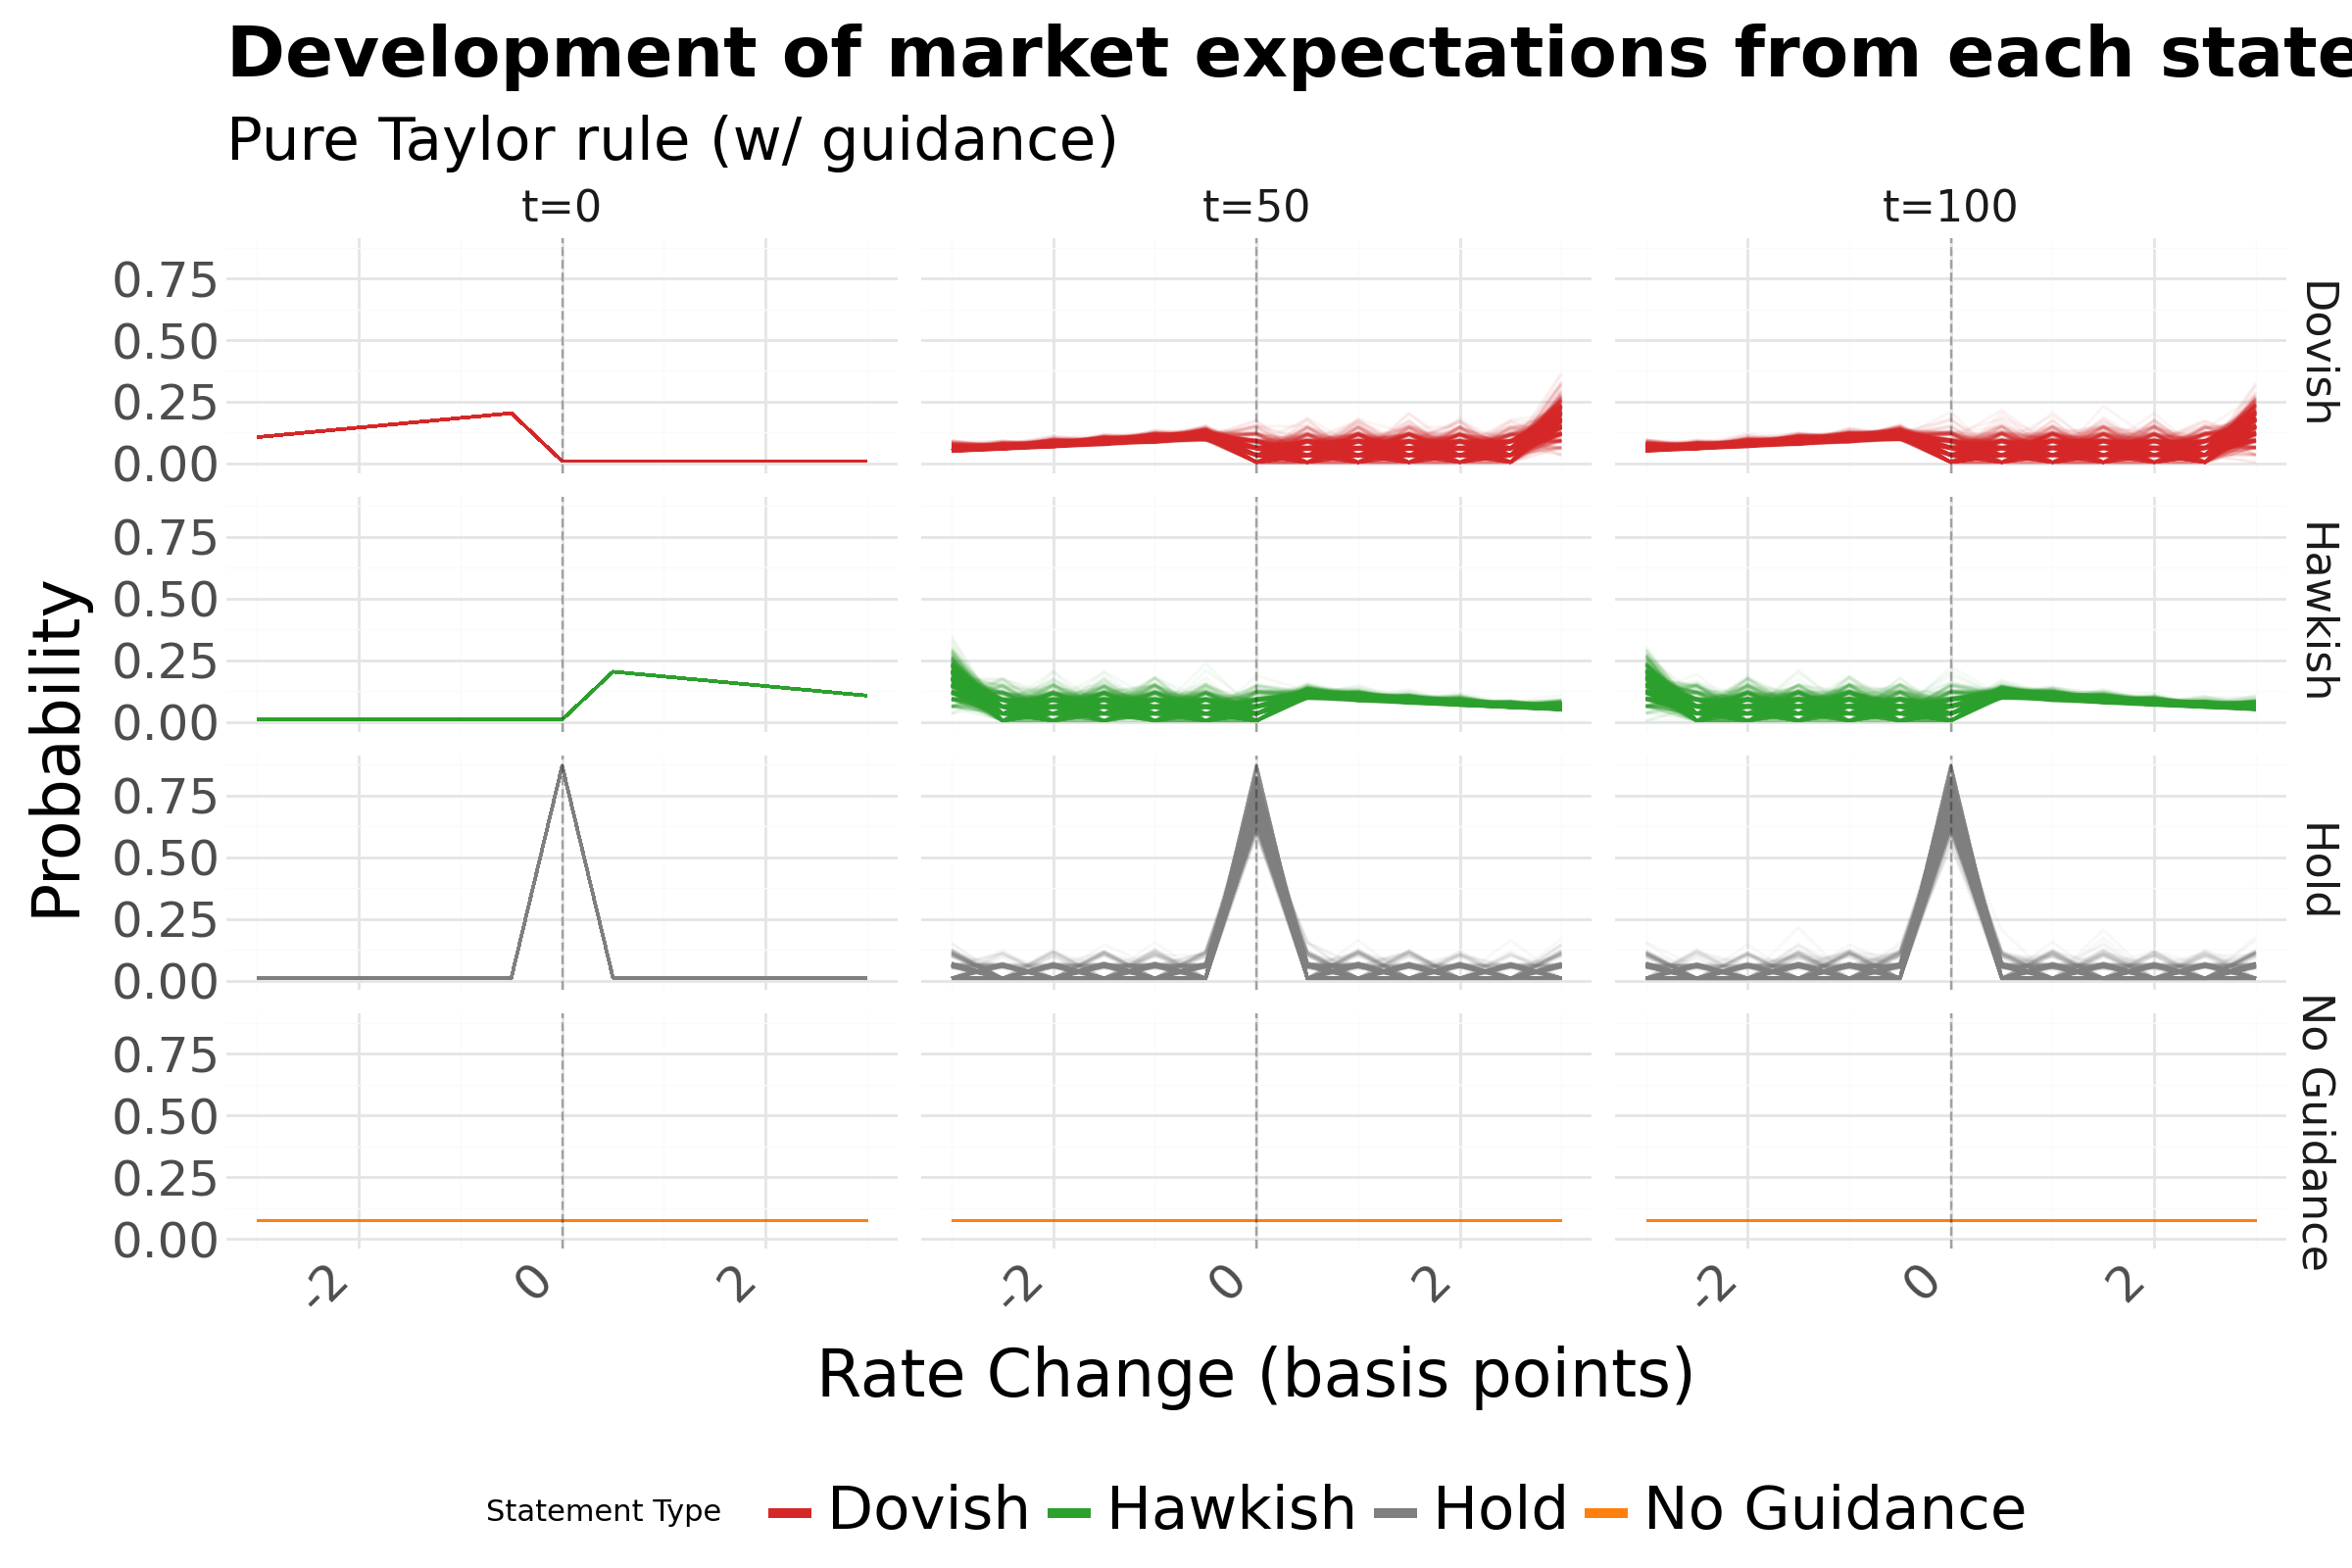

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/spaguetti_pure_guidance.pdf


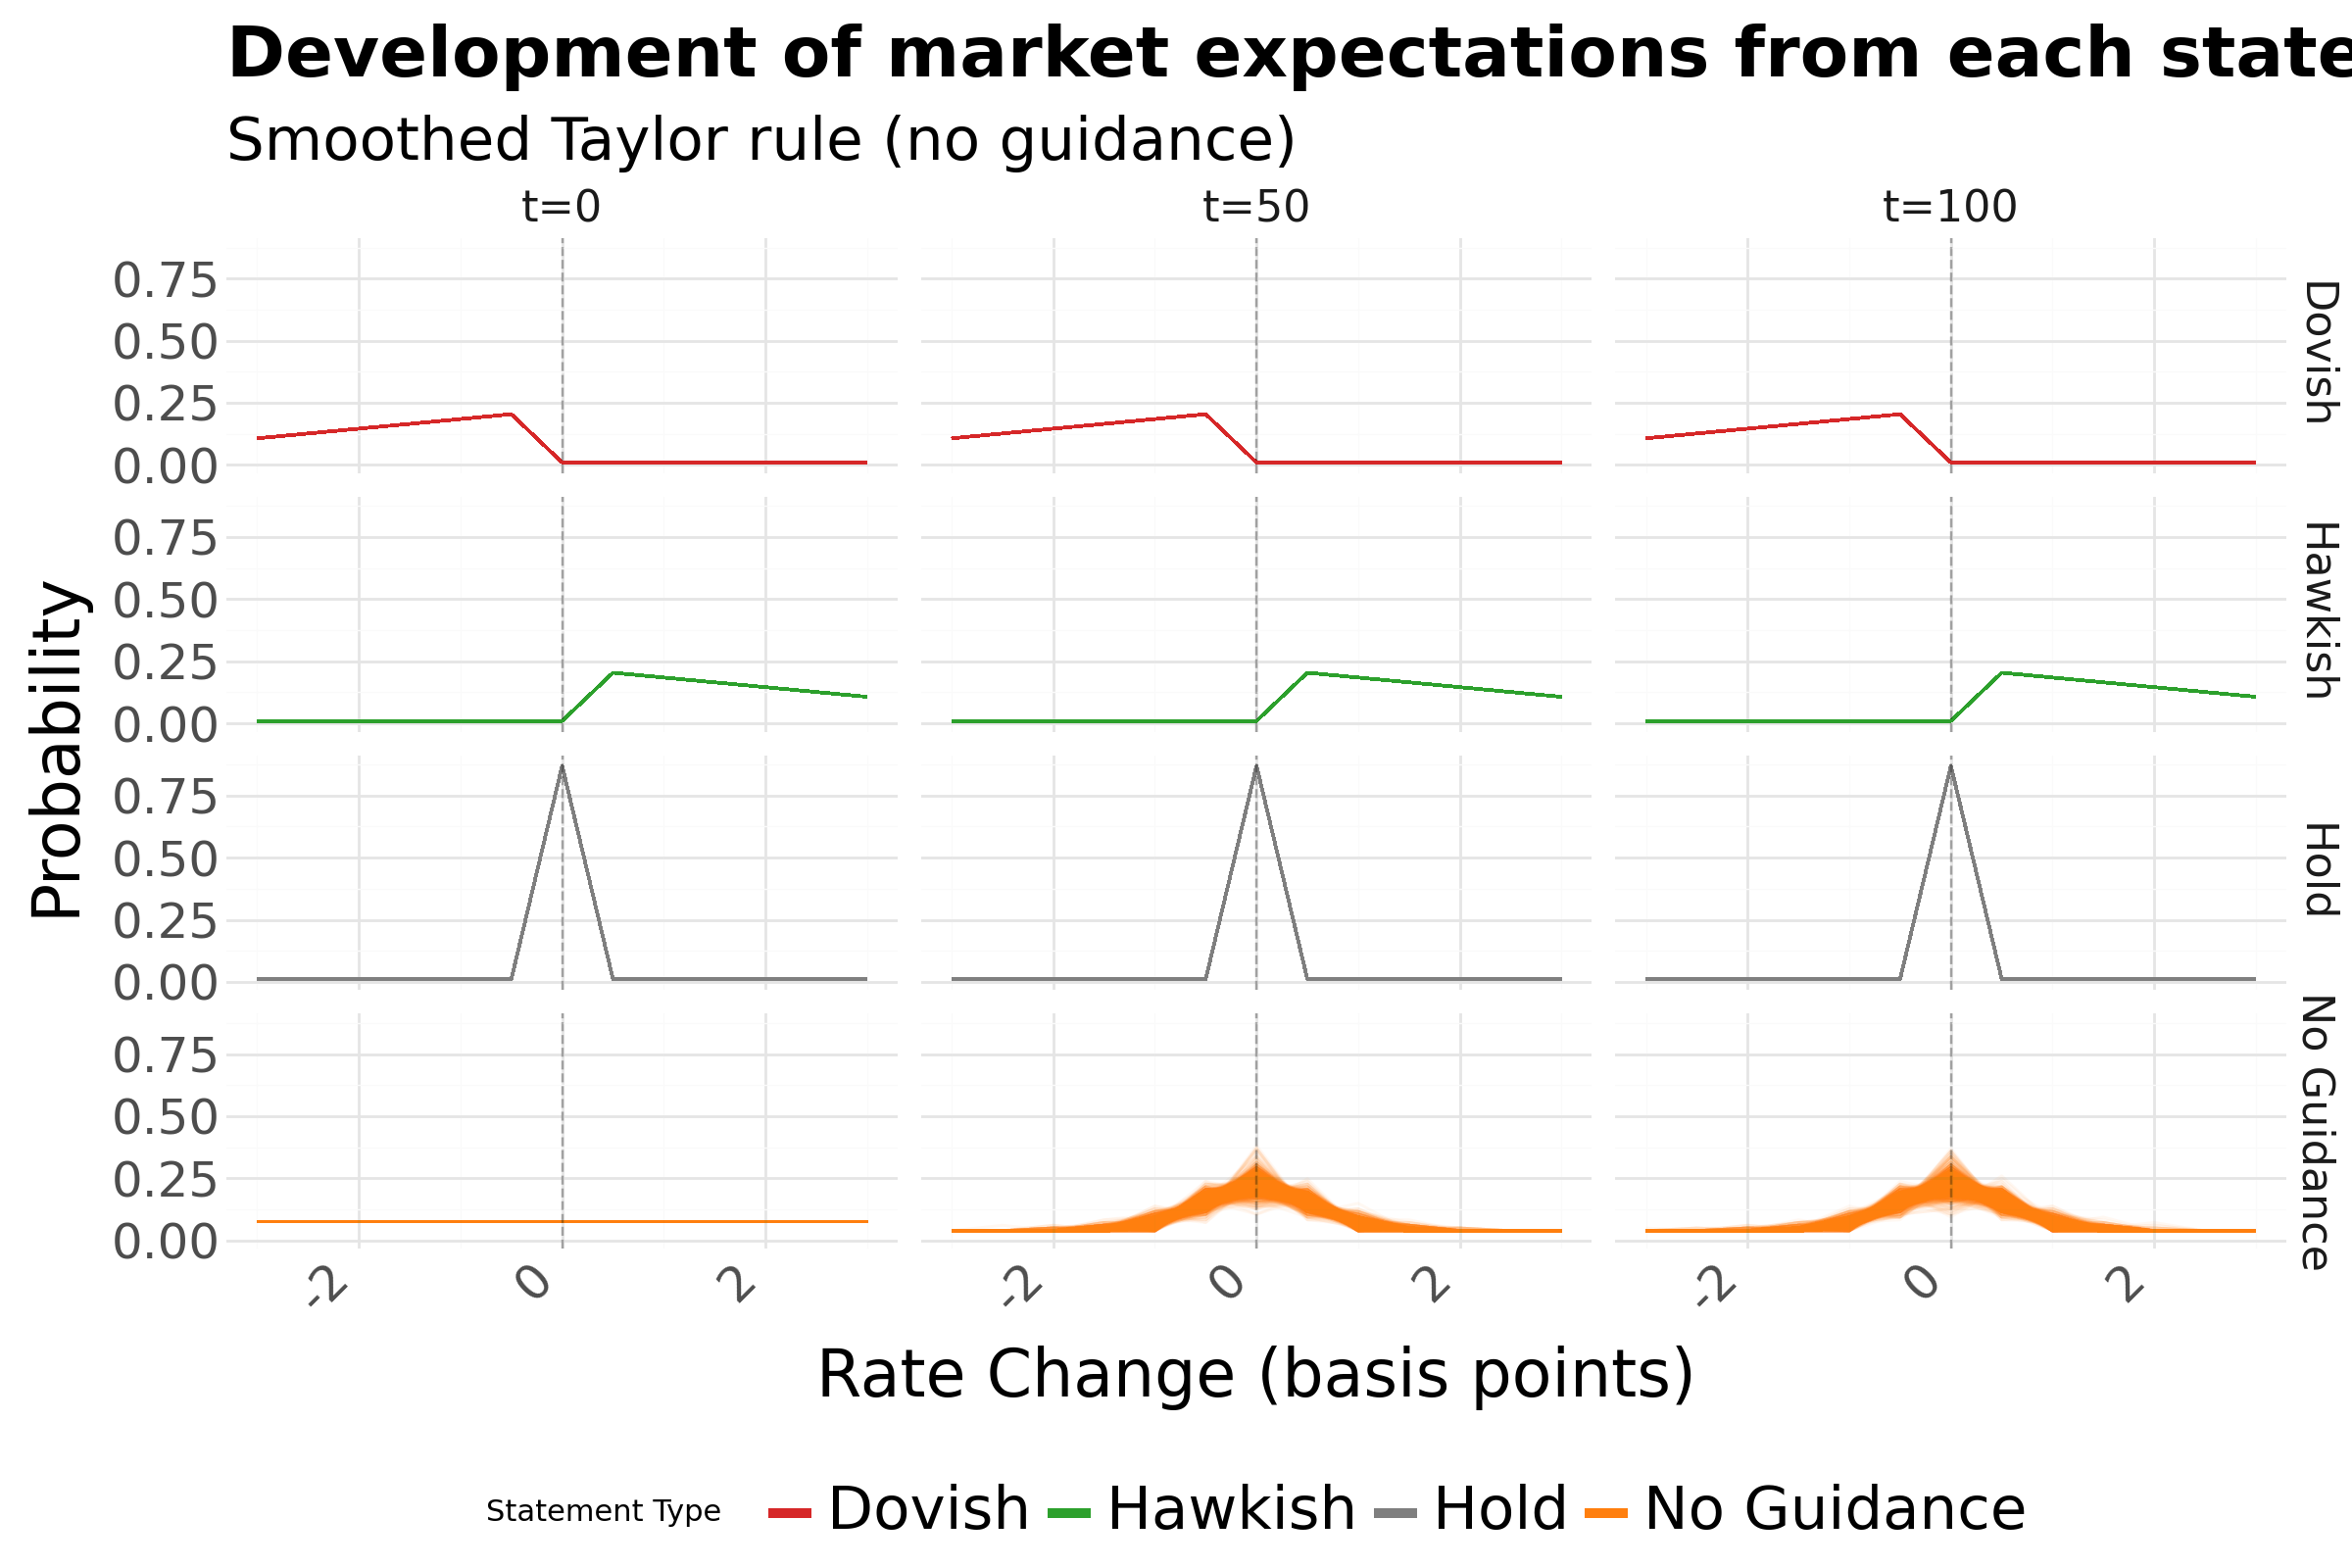

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/spaguetti_no_guidance.pdf


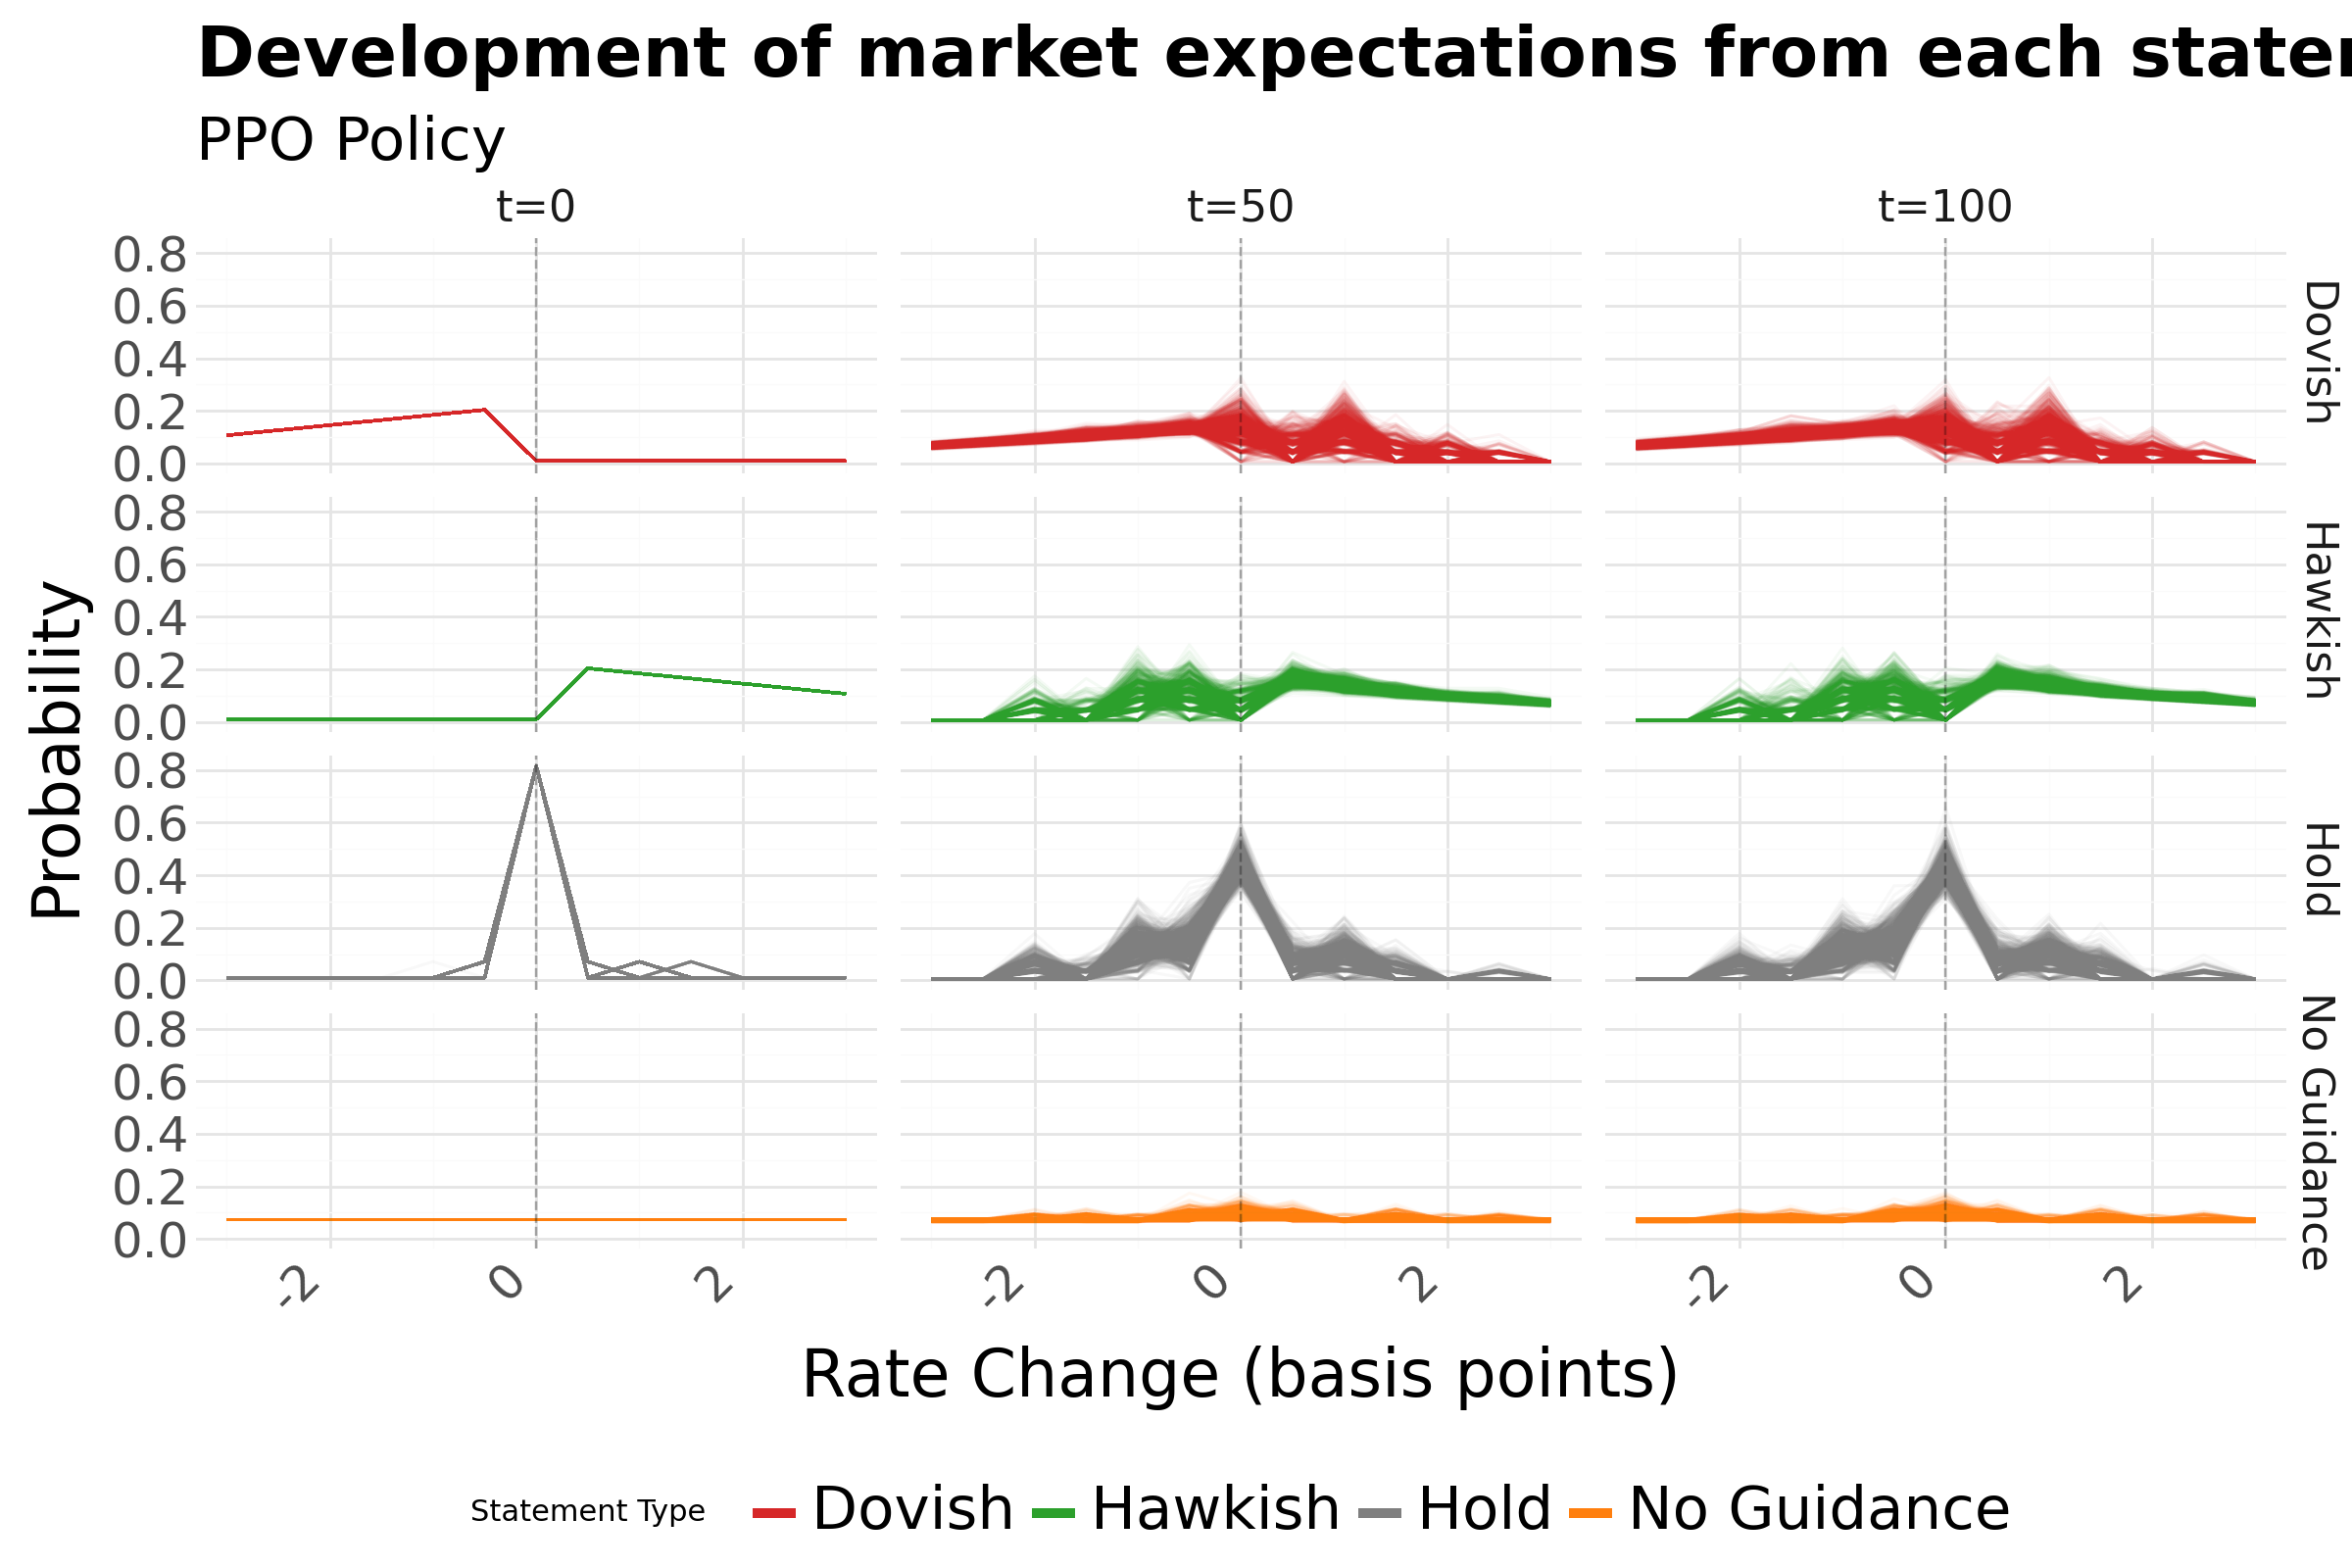

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/spaguetti_ppo.pdf


In [ ]:
def plot_guidance_spaghetti(df, checkpoints=[25, 75, 125, 175], sample_trajectories=50, subtitle = None):
    """
    Plot individual trajectory expectations (spaghetti plot).
    """
    statement_names = {0: "Dovish", 1: "Hold", 2: "Hawkish", 3: "No Guidance"}
    interest_rate_moves = np.round(np.arange(-0.03, 0.035, 0.005), 4)
    interest_rate_moves[6] = 0.0
    
    all_expectations = []
    
    checkpoint_df = df[df['step'].isin(checkpoints)].copy()
    
    # Sample trajectories for visibility
    sampled_traj = np.random.choice(
        checkpoint_df['trajectory'].unique(), 
        size=min(sample_trajectories, checkpoint_df['trajectory'].nunique()),
        replace=False
    )
    checkpoint_df = checkpoint_df[checkpoint_df['trajectory'].isin(sampled_traj)]
    
    for _, row in checkpoint_df.iterrows():
        step = row['step']
        traj_id = row['trajectory']
        expect_array = row['expect_array'] # The full 4x13 Dirichlet state

        for stmt_id in range(4):
            alpha = expect_array[stmt_id]
            probs = alpha / alpha.sum()
            
            for i, rate_move in enumerate(interest_rate_moves):
                all_expectations.append({
                    'trajectory': traj_id,
                    'checkpoint': f"t={step}",
                    'statement_type': statement_names[stmt_id], # Use loop id, not row['statements']
                    'rate_change': rate_move * 100,
                    'probability': probs[i]
                })
    
    expect_df = pd.DataFrame(all_expectations)
    
    checkpoint_order = [f"t={cp}" for cp in sorted(checkpoints)]
    expect_df['checkpoint'] = pd.Categorical(expect_df['checkpoint'], categories=checkpoint_order, ordered=True)
    
    # Define colors
    colors = {
        'Dovish': '#d62728',
        'Hold': '#7f7f7f',
        'Hawkish': '#2ca02c',
        'No Guidance': '#ff7f0e'
    }
    
    # Plot individual trajectories
    p = (
        ggplot(expect_df, aes(x='rate_change', y='probability', 
                              group='trajectory', color='statement_type')) +
        geom_line(alpha=0.05, size=0.6) +  # Increased alpha and size slightly
        geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3) +
        facet_grid('statement_type~checkpoint') +
        scale_color_manual(values=colors) +
        guides(color=guide_legend(override_aes={'alpha': 1, 'size': 2})) +  # Full opacity in legend
        labs(
            title=f'Development of market expectations from each statement',
            x='Rate Change (basis points)',
            y='Probability',
            color='Statement Type',
            subtitle = subtitle
        ) +
        theme_economy() +
        theme(
            legend_text=element_text(size=22)
        )
    )
    
    return p, expect_df


spaghetti_plot_smooth_guidance, raw_data2 = plot_guidance_spaghetti(
    full_panel_smooth_guide,
    checkpoints=[0, 50, 100],
    sample_trajectories=1000,
    subtitle = "Smoothed Taylor rule (w/ guidance)"
)
display(spaghetti_plot_smooth_guidance)
spaghetti_plot_smooth_guidance.save(figsspaguetti_smooth_guidance.pdf")

spaghetti_plot_pure_guidance, raw_data2 = plot_guidance_spaghetti(
    full_panel_guide,
    checkpoints=[0, 50, 100],
    sample_trajectories=1000,
    subtitle = "Pure Taylor rule (w/ guidance)"
)
display(spaghetti_plot_pure_guidance)
spaghetti_plot_pure_guidance.save(figsspaguetti_pure_guidance.pdf")

spaghetti_plot_smoothed_classical, raw_data2 = plot_guidance_spaghetti(
    full_panel_smooth_classic,
    checkpoints=[0, 50, 100],
    sample_trajectories=1000,
    subtitle = "Smoothed Taylor rule (no guidance)"
)
display(spaghetti_plot_smoothed_classical)
spaghetti_plot_smoothed_classical.save(figsspaguetti_no_guidance.pdf")

spaghetti_plot_ppo, raw_data2 = plot_guidance_spaghetti(
    ppo_df,
    checkpoints=[0, 50, 100],
    sample_trajectories=1000,
    subtitle = "PPO Policy"
)
display(spaghetti_plot_ppo)
spaghetti_plot_ppo.save(figsspaguetti_ppo.pdf")


In [ ]:
import scipy.stats as stats
def entropy_plot(df):
    # Restrict step
    # df_t = df[df["step"].isin(time_steps)]
    df_t = df

    # Separate list of lists into separate columns
    df_t = df_t.join(
        pd.DataFrame(df_t["expect_array"].to_list(),
                     index=df_t.index,
                     columns=["dove_array", "hold_array", "hawk_array", "no_guidance_array"])
    )
    
    entropy_col_names = []
    for action in ["dove", "hold", "hawk", "no_guidance"]:
        correct_array = f"{action}_array"
        col_title = f"{action}_entropy"
        entropy_col_names.append(col_title)
        entropy = df_t[correct_array].apply(stats.dirichlet.entropy)
        df_t[col_title] = entropy

    median_entropy = df_t.groupby("step")[entropy_col_names].median()
    lower_percentile= df_t.groupby("step")[entropy_col_names].quantile(0.025)
    upper_percentile= df_t.groupby("step")[entropy_col_names].quantile(0.975)

    print(median_entropy)
    df_plot = pd.DataFrame({"Median" : median_entropy, 
                            "Lower percentile" : [lower_percentile], 
                            "Upper percentile" : [upper_percentile]})


    # plot = (
    #     ggplot()
    # )

    return df_plot


from scipy import stats
from plotnine import *
import pandas as pd
import numpy as np

def entropy_plot(df, subtitle):
    # 1. Expand the 'expect_array' column (list of 4 arrays) into named columns
    # We copy to avoid settingWithCopy warnings on the original df
    df_exp = df.copy()
    
    # Create temporary columns for each statement type
    # Order matches your class: [Dove, Hold, Hawk, No Guidance]
    expanded_data = pd.DataFrame(
        df_exp["expect_array"].to_list(),
        index=df_exp.index,
        columns=["Dove", "Hold", "Hawk", "No Guidance"]
    )
    df_exp = df_exp.join(expanded_data)

    # 2. Calculate Entropy and Melt into Long Format
    melted_frames = []
    
    for stmt_type in ["Dove", "Hold", "Hawk", "No Guidance"]:
        # Safety: Dirichlet entropy requires alpha > 0. Your priors have 0s.
        # We add a tiny epsilon (1e-9) to avoid ValueError.
        entropy_series = df_exp[stmt_type].apply(
            lambda x: stats.dirichlet.entropy(np.array(x))
        )
        
        # Create a mini dataframe for this statement type
        temp = pd.DataFrame({
            "step": df_exp["step"],
            "trajectory": df_exp["trajectory"],
            "entropy": entropy_series,
            "Statement_Type": stmt_type
        })
        melted_frames.append(temp)

    # Combine all statement types into one big dataframe
    long_df = pd.concat(melted_frames)

    # 3. Calculate the Median line
    median_df = (
        long_df
        .groupby(["step", "Statement_Type"])["entropy"]
        .median()
        .reset_index()
    )


    # 4. Plot
    plot = (
        ggplot(long_df, aes(x="step", y="entropy")) +
        
        # Layer 1: Faint lines
        # We map color to a STRING label inside aes() to force a legend entry
        geom_line(
            aes(group="trajectory", color='"Individual Sim"'), 
            alpha=0.05, 
            size=0.5
        ) +
        
        # Layer 2: Median line
        # We also map color to a STRING label here
        geom_line(
            data=median_df, 
            mapping=aes(color='"Median"'), 
            size=1.2
        ) +
        
        # Define the colors manually
        scale_color_manual(
            name="Legend", # Title of the legend
            values={"Individual Sim": "blue", "Median": "lightblue"}
        ) +
        
        # Make the legend lines opaque so we can actually see the blue one
        guides(color=guide_legend(override_aes={"alpha": 1, "size": 2})) +

        facet_wrap("~Statement_Type", scales="free_y") +
        
        labs(
            title="Evolution of Belief Entropy (Uncertainty)",
            x="Time Step",
            y="Differential Entropy",
            subtitle = subtitle
        ) +
        theme_minimal() +
        theme(figure_size=(10, 8))
    )
    return plot

# Usage:
# p = entropy_plot(full_panel_guide)
# print(p)

entropy_plot_smooth = entropy_plot(full_panel_smooth_guide, subtitle = "Smooth Taylor policy")
display(entropy_plot_smooth)
# entropy_plot_smooth.save("figs/entropy_MC_plot_smooth_taylor.svg")
entropy_plot_pure = entropy_plot(full_panel_guide, subtitle = "Pure Taylor policy")
display(entropy_plot_pure)

entropy_plot_ppo = entropy_plot(ppo_df, subtitle = "PPO Policy")
display(entropy_plot_ppo)
# entropy_plot_pure.save("figs/entropy_MC_pure_taylor.svg")

KeyboardInterrupt: 

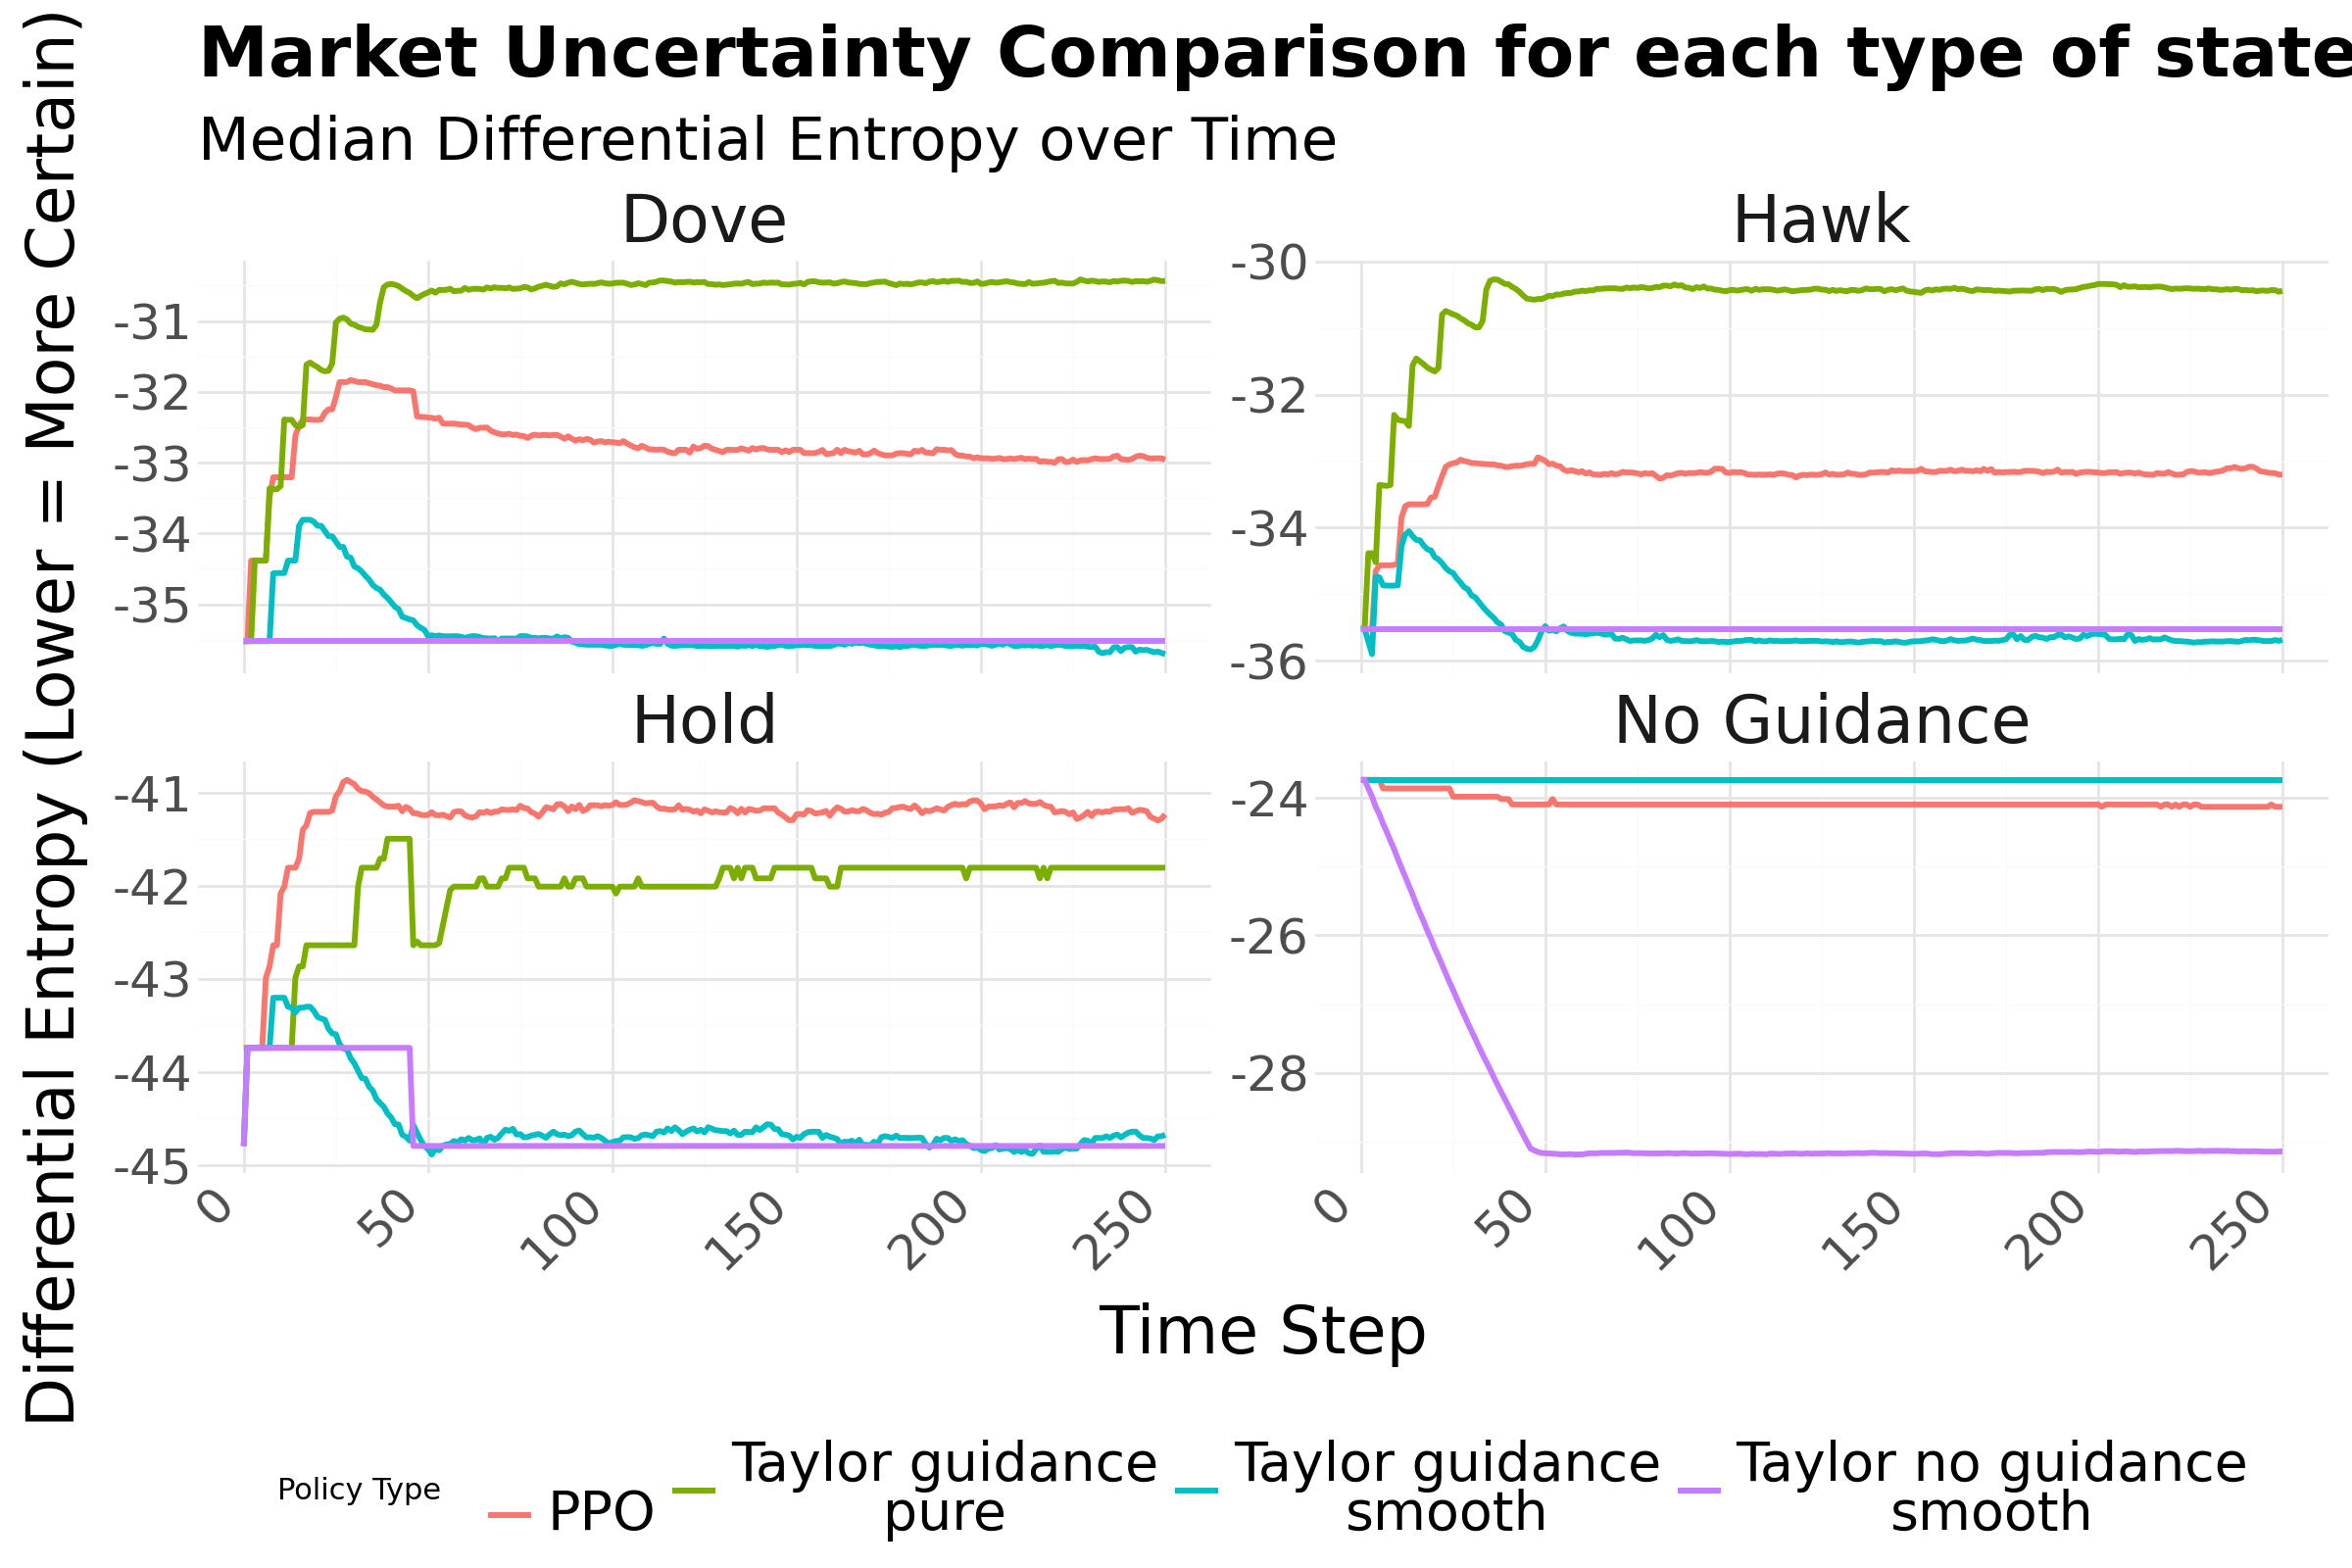

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/median_entropy.pdf


In [ ]:
from scipy import stats
import textwrap

def compare_entropy_plot(combined_df):
    """
    Compares the median entropy evolution of two different policies.
    Expects 'combined_df' to have a 'Type' column distinguishing the policies.
    """
    df_exp = combined_df.copy().reset_index(drop = True)
    
    # 1. Expand the 'expect_array' column into named columns
    expanded_data = pd.DataFrame(
        df_exp["expect_array"].to_list(),
        index=df_exp.index,
        columns=["Dove", "Hold", "Hawk", "No Guidance"]
    )
    df_exp = df_exp.join(expanded_data)

    # 2. Calculate Entropy for every row
    melted_frames = []
    
    for stmt_type in ["Dove", "Hold", "Hawk", "No Guidance"]:
        # Safety epsilon for Dirichlet entropy
        entropy_series = df_exp[stmt_type].apply(
            lambda x: stats.dirichlet.entropy(np.array(x) + 1e-9)
        )
        
        temp = pd.DataFrame({
            "step": df_exp["step"],
            "entropy": entropy_series,
            "Statement_Type": stmt_type,
            "Policy": df_exp["type"] # Preserve the policy label
        })
        melted_frames.append(temp)

    long_df = pd.concat(melted_frames)

    # 3. Calculate Median Entropy per Policy per Step
    median_df = (
        long_df
        .groupby(["step", "Statement_Type", "Policy"])["entropy"]
        .median()
        .reset_index()
    )
    median_df["Policy"] = median_df["Policy"].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=18))
    )

    # 4. Plot
    plot = (
        ggplot(median_df, aes(x="step", y="entropy", color="Policy")) +
        
        # The Median Lines
        geom_line(size=1.2) +
        
        # Facet by Statement Type
        facet_wrap("~Statement_Type", scales="free_y") +
        
        labs(
            title="Market Uncertainty Comparison for each type of statement",
            subtitle="Median Differential Entropy over Time",
            x="Time Step",
            y="Differential Entropy (Lower = More Certain)",
            color="Policy Type"
        ) +
        
        theme_economy() +
        theme(strip_text=element_text(size = 24),
              legend_text=element_text(size = 20))
    )

    return plot


combined_df = pd.concat([full_panel_guide, full_panel_smooth_guide, full_panel_smooth_classic, ppo_df])
p = compare_entropy_plot(combined_df)
display(p)
p.save(figsmedian_entropy.pdf")

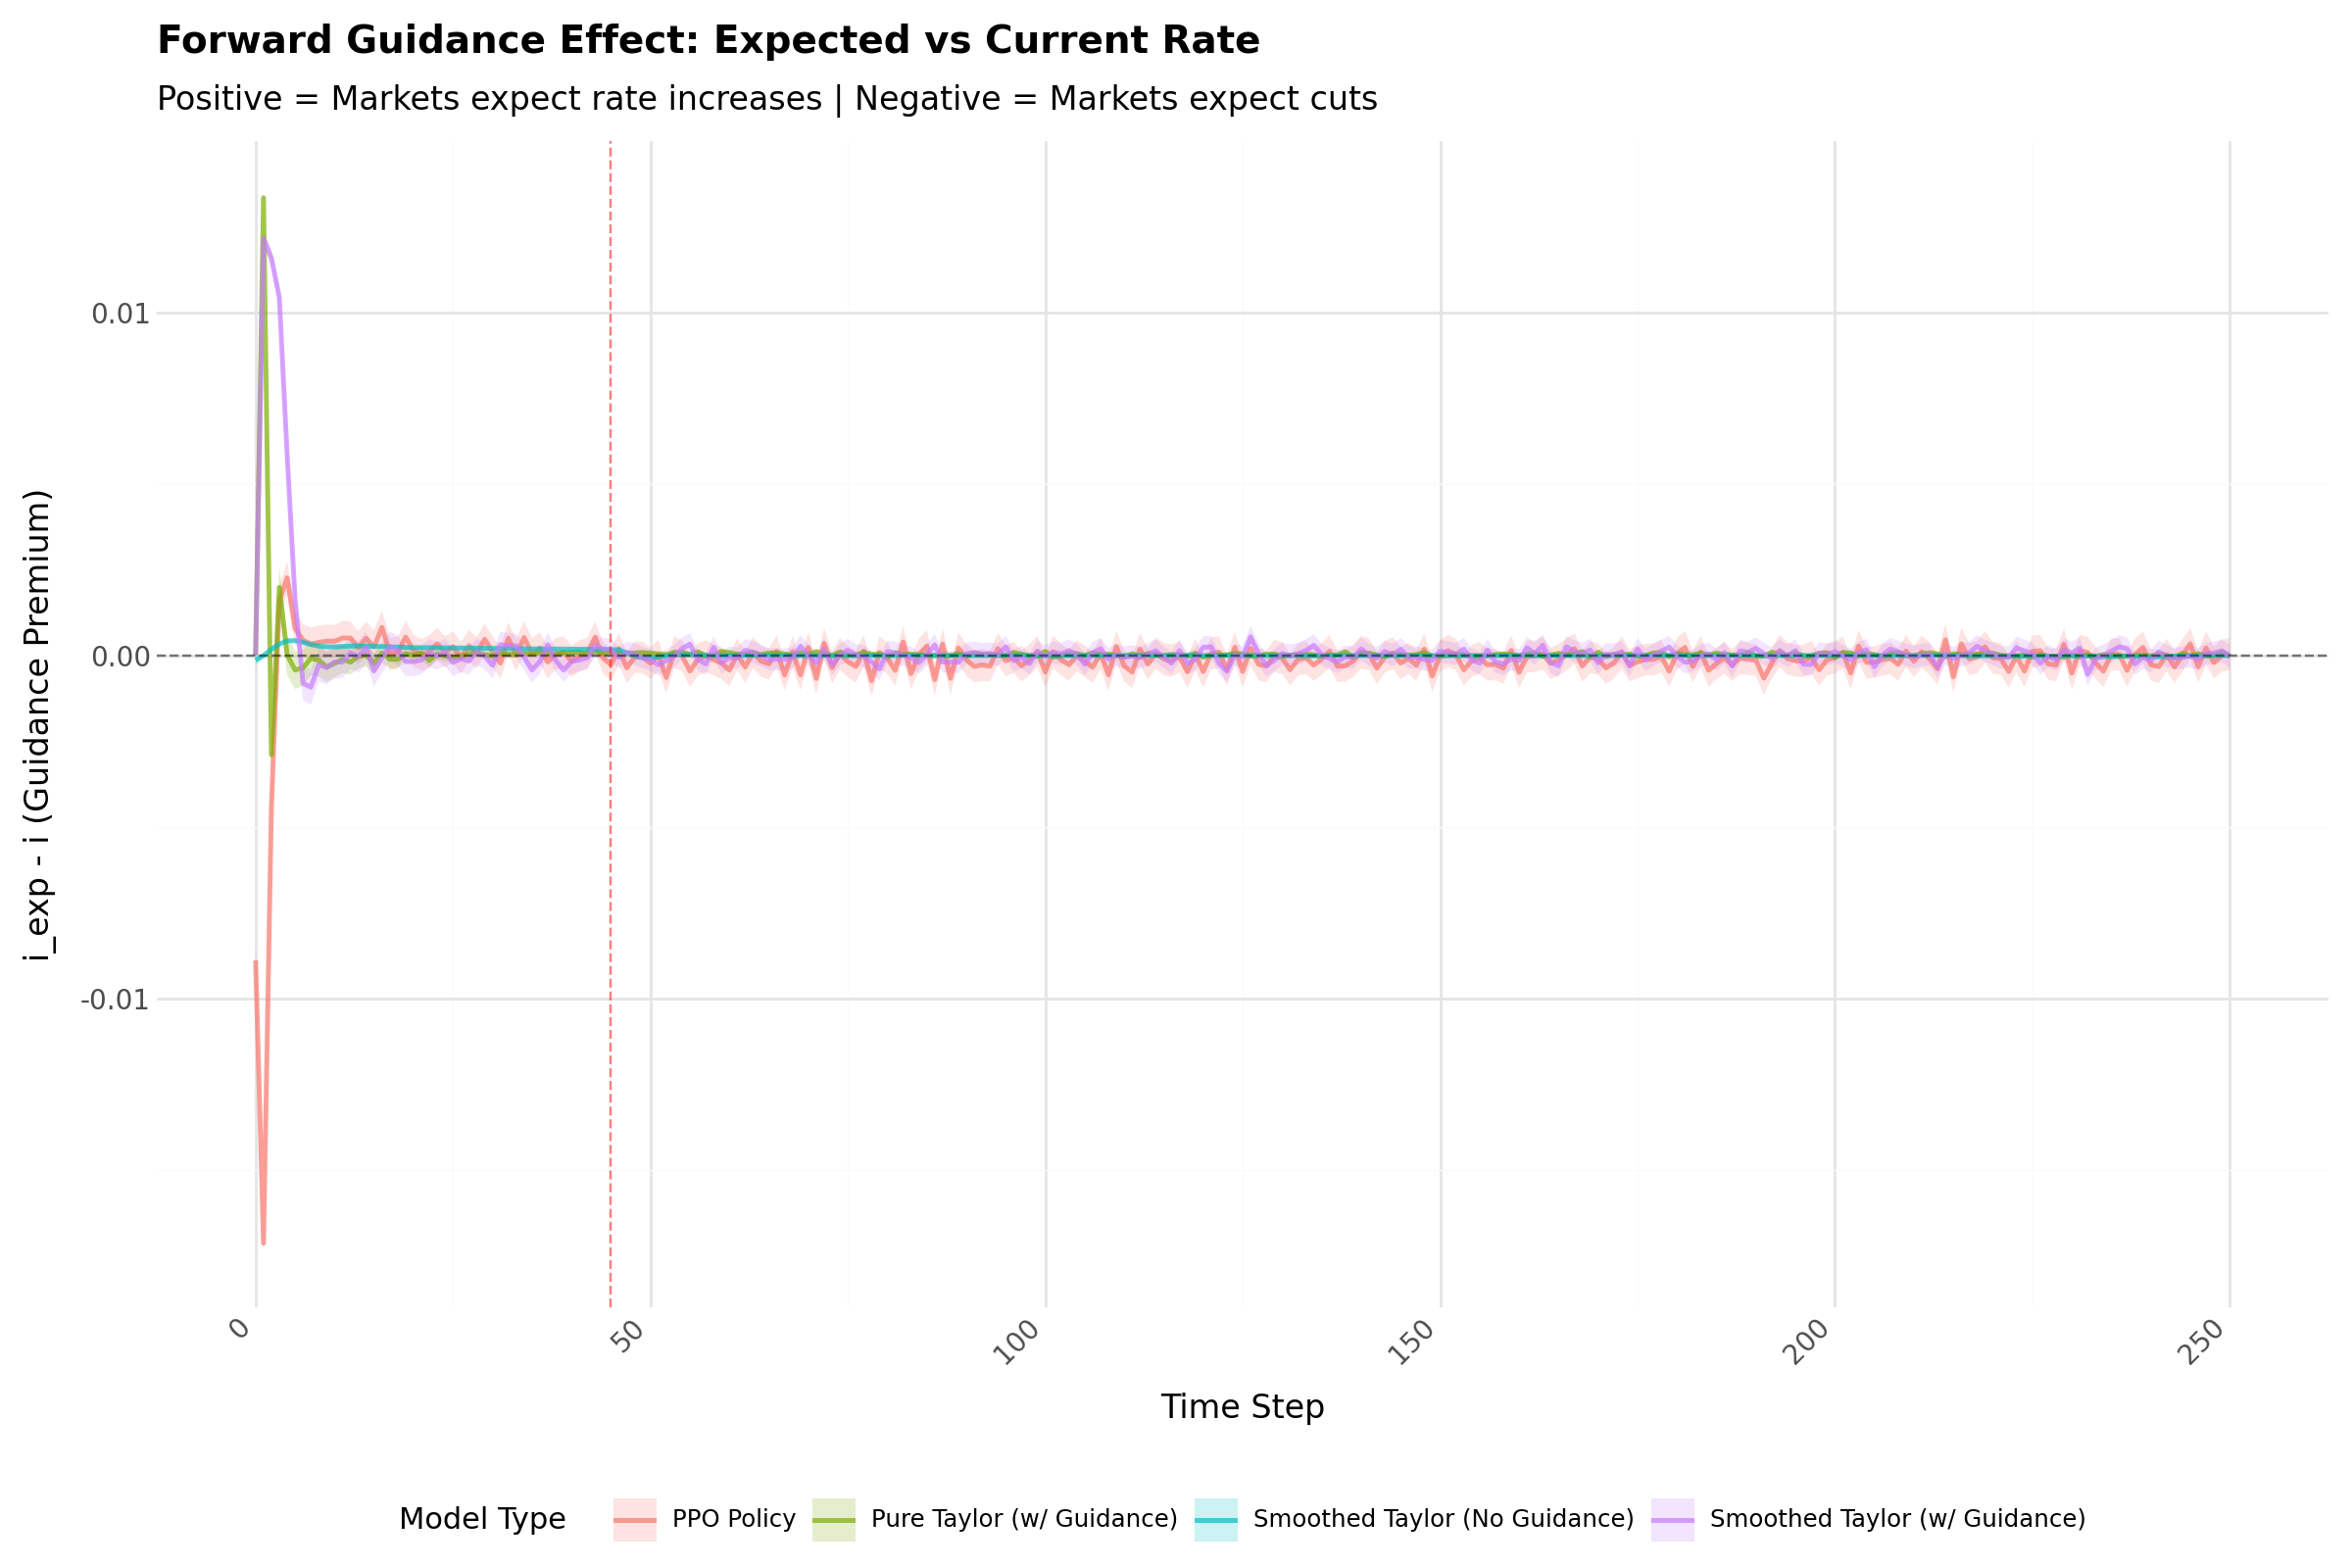

In [178]:
def process_guidance_effect(df, label):
    df = df.copy()
    df['guidance_effect'] = df['i_exp'] - df['i']
    df['Simulation Type'] = label
    return df

df_pure = process_guidance_effect(full_panel_guide, "Pure Taylor (w/ Guidance)")
df_smooth = process_guidance_effect(full_panel_smooth_guide, "Smoothed Taylor (w/ Guidance)")
df_smooth_no_guide = process_guidance_effect(full_panel_smooth_classic, "Smoothed Taylor (No Guidance)")
df_ppo_guide_effect = process_guidance_effect(ppo_df, "PPO Policy")
combined = pd.concat([df_pure, df_smooth, df_smooth_no_guide, df_ppo_guide_effect])

agg_data = (
    combined
    .groupby(['step', 'Simulation Type'])['guidance_effect']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

agg_data['se'] = agg_data['std'] / np.sqrt(agg_data['count'])
agg_data['ymin'] = agg_data['mean'] - 1.96 * agg_data['se']
agg_data['ymax'] = agg_data['mean'] + 1.96 * agg_data['se']

plot_guidance = (
    ggplot(agg_data, aes(x='step', y='mean', color='Simulation Type', fill='Simulation Type')) +
    geom_ribbon(aes(ymin='ymin', ymax='ymax'), alpha=0.2, color=None) +
    geom_line(size=1, alpha = 0.7) +
    geom_hline(yintercept=0, linetype="dashed", color="black", alpha=0.5) +
    geom_vline(xintercept=45, linetype="dashed", color="red", alpha=0.5) +
    labs(
        title='Forward Guidance Effect: Expected vs Current Rate',
        subtitle='Positive = Markets expect rate increases | Negative = Markets expect cuts',
        y='i_exp - i (Guidance Premium)',
        x='Time Step',
        color='Model Type',
        fill='Model Type'
    ) +
    theme_economy()
)

plot_guidance

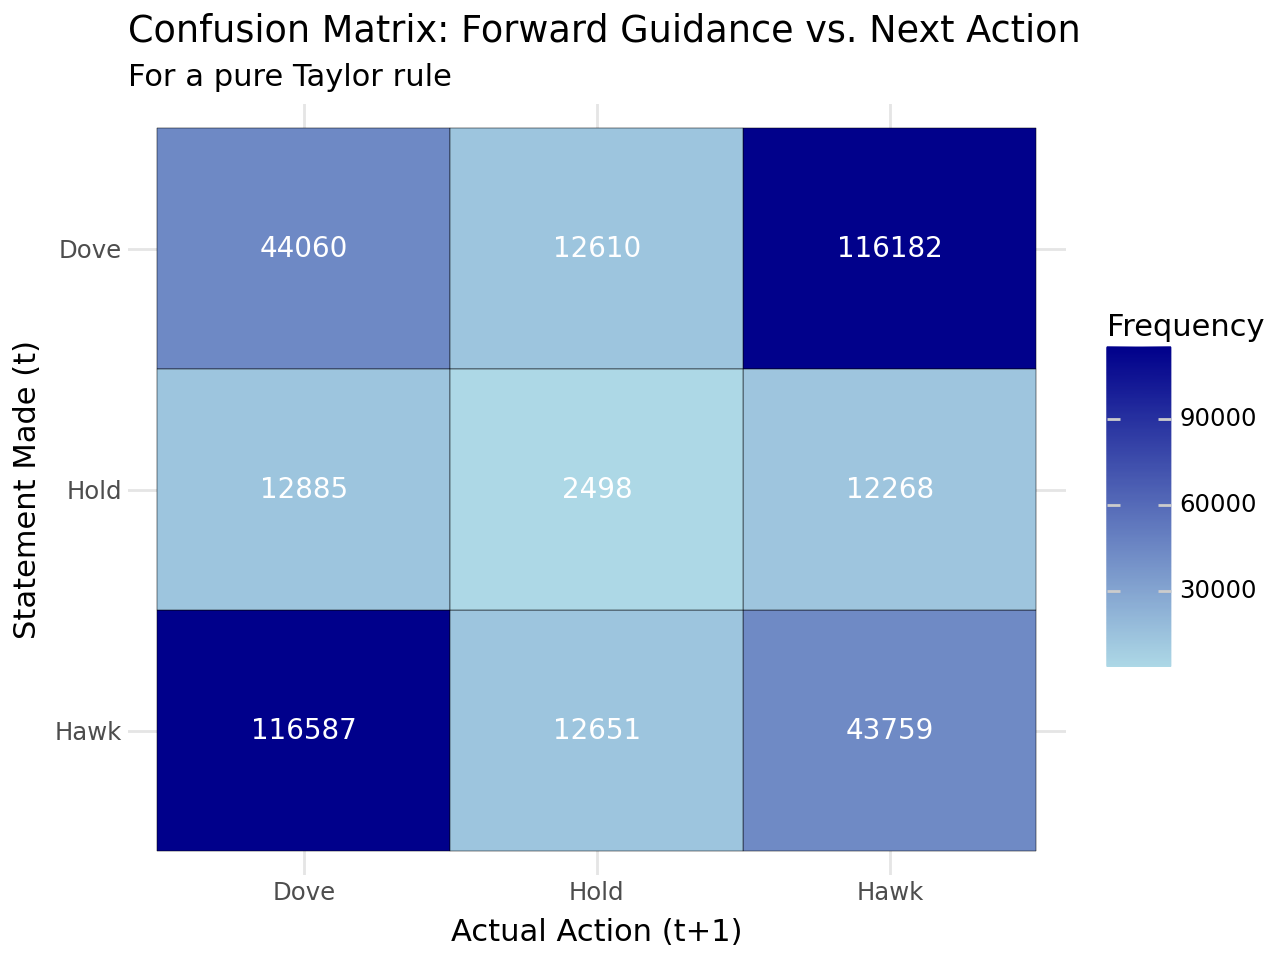

In [223]:
statement_map = {0: "Dove", 1: "Hold", 2: "Hawk", 3:"No Guidance"}
full_panel_guide["statement_label"] = full_panel_guide["statements"].map(statement_map)

# Apply shift(-1) per trajectory
full_panel_guide["next_delta"] = full_panel_guide.groupby("trajectory")["delta_i"].shift(-1)


# Map actual action from delta_i
def delta_to_action(delta):
    if delta > 0:
        return "Hawk"
    elif delta < 0:
        return "Dove"
    elif pd.isna(delta):
        return "End of episode"
    else:
        return "Hold"

full_panel_guide["actual_next_action"] = full_panel_guide["next_delta"].apply(delta_to_action)

clean_df = full_panel_guide[full_panel_guide["actual_next_action"] != "End of Episode"].copy()

cm_df = (
    clean_df
    .groupby(["statement_label", "actual_next_action"])
    .size()
    .reset_index(name="count")
)
cm_df["prob"] = cm_df["count"] / cm_df["count"].sum()

# Change order of categories
logic_order = ["Dove", "Hold", "Hawk"]
logic_order_stmt = ["Hawk", "Hold", "Dove"]

cm_df["actual_next_action"] = pd.Categorical(cm_df["actual_next_action"], categories=logic_order, ordered=True)
cm_df["statement_label"] = pd.Categorical(cm_df["statement_label"], categories=logic_order_stmt, ordered=True)

# Remove end of episode occurences
cm_df = cm_df.dropna()

# Plot
plot_cm_pure = (
    ggplot(cm_df, aes(x="actual_next_action", y="statement_label", fill="count")) +
    geom_tile(color="black") +
    geom_text(aes(label="count"), size=10, color="white") + 
    scale_fill_gradient(low="lightblue", high="darkblue") +
    labs(
        title="Confusion Matrix: Forward Guidance vs. Next Action",
        x="Actual Action (t+1)",
        y="Statement Made (t)",
        fill="Frequency",
        subtitle = "For a pure Taylor rule"
    ) +
    theme_minimal() +
    # This ensures the y-axis isn't flipped (puts Dove at bottom, Hawk at top)
    scale_y_discrete(limits=logic_order_stmt) 
)

plot_cm_pure

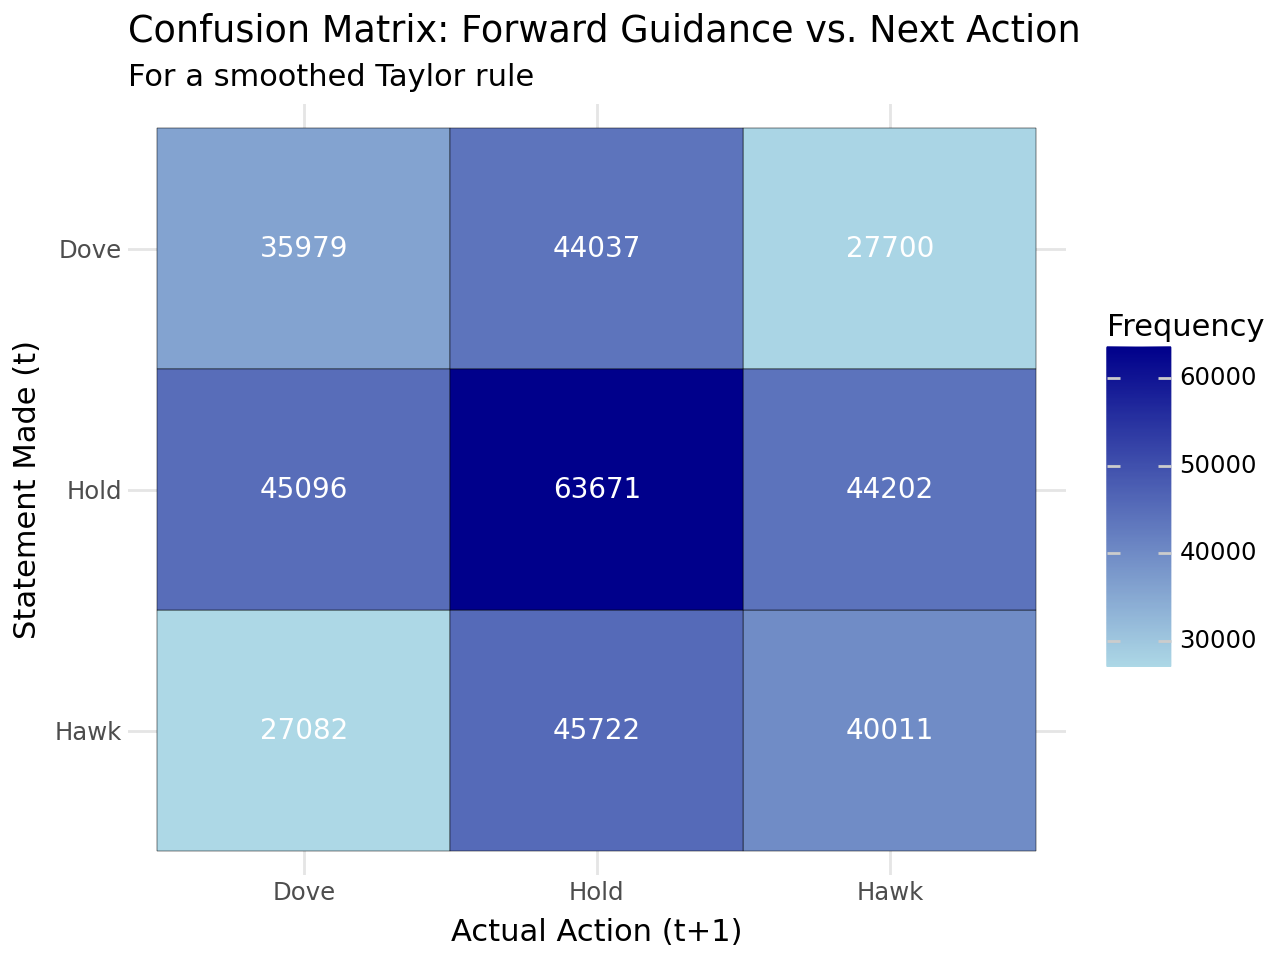

In [224]:
statement_map = {0: "Dove", 1: "Hold", 2: "Hawk", 3:"No Guidance"}
full_panel_smooth_guide["statement_label"] = full_panel_smooth_guide["statements"].map(statement_map)

# Apply shift(-1) per trajectory
full_panel_smooth_guide["next_delta"] = full_panel_smooth_guide.groupby("trajectory")["delta_i"].shift(-1)


# Map actual action from delta_i
def delta_to_action(delta):
    if delta > 0:
        return "Hawk"
    elif delta < 0:
        return "Dove"
    elif pd.isna(delta):
        return "End of episode"
    else:
        return "Hold"

full_panel_smooth_guide["actual_next_action"] = full_panel_smooth_guide["next_delta"].apply(delta_to_action)

clean_df = full_panel_smooth_guide[full_panel_smooth_guide["actual_next_action"] != "End of Episode"].copy()

cm_df = (
    clean_df
    .groupby(["statement_label", "actual_next_action"])
    .size()
    .reset_index(name="count")
)
cm_df["prob"] = cm_df["count"] / cm_df["count"].sum()

# Change order of categories
logic_order = ["Dove", "Hold", "Hawk"]
logic_order_stmt = ["Hawk", "Hold", "Dove"]

cm_df["actual_next_action"] = pd.Categorical(cm_df["actual_next_action"], categories=logic_order, ordered=True)
cm_df["statement_label"] = pd.Categorical(cm_df["statement_label"], categories=logic_order_stmt, ordered=True)

# Remove end of episode occurences
cm_df = cm_df.dropna()

# Plot
plot_cm_pure = (
    ggplot(cm_df, aes(x="actual_next_action", y="statement_label", fill="count")) +
    geom_tile(color="black") +
    geom_text(aes(label="count"), size=10, color="white") + 
    scale_fill_gradient(low="lightblue", high="darkblue") +
    labs(
        title="Confusion Matrix: Forward Guidance vs. Next Action",
        x="Actual Action (t+1)",
        y="Statement Made (t)",
        fill="Frequency",
        subtitle = "For a smoothed Taylor rule"
    ) +
    theme_minimal() +
    # This ensures the y-axis isn't flipped (puts Dove at bottom, Hawk at top)
    scale_y_discrete(limits=logic_order_stmt) 
)

plot_cm_pure

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/confusion_matrix.pdf


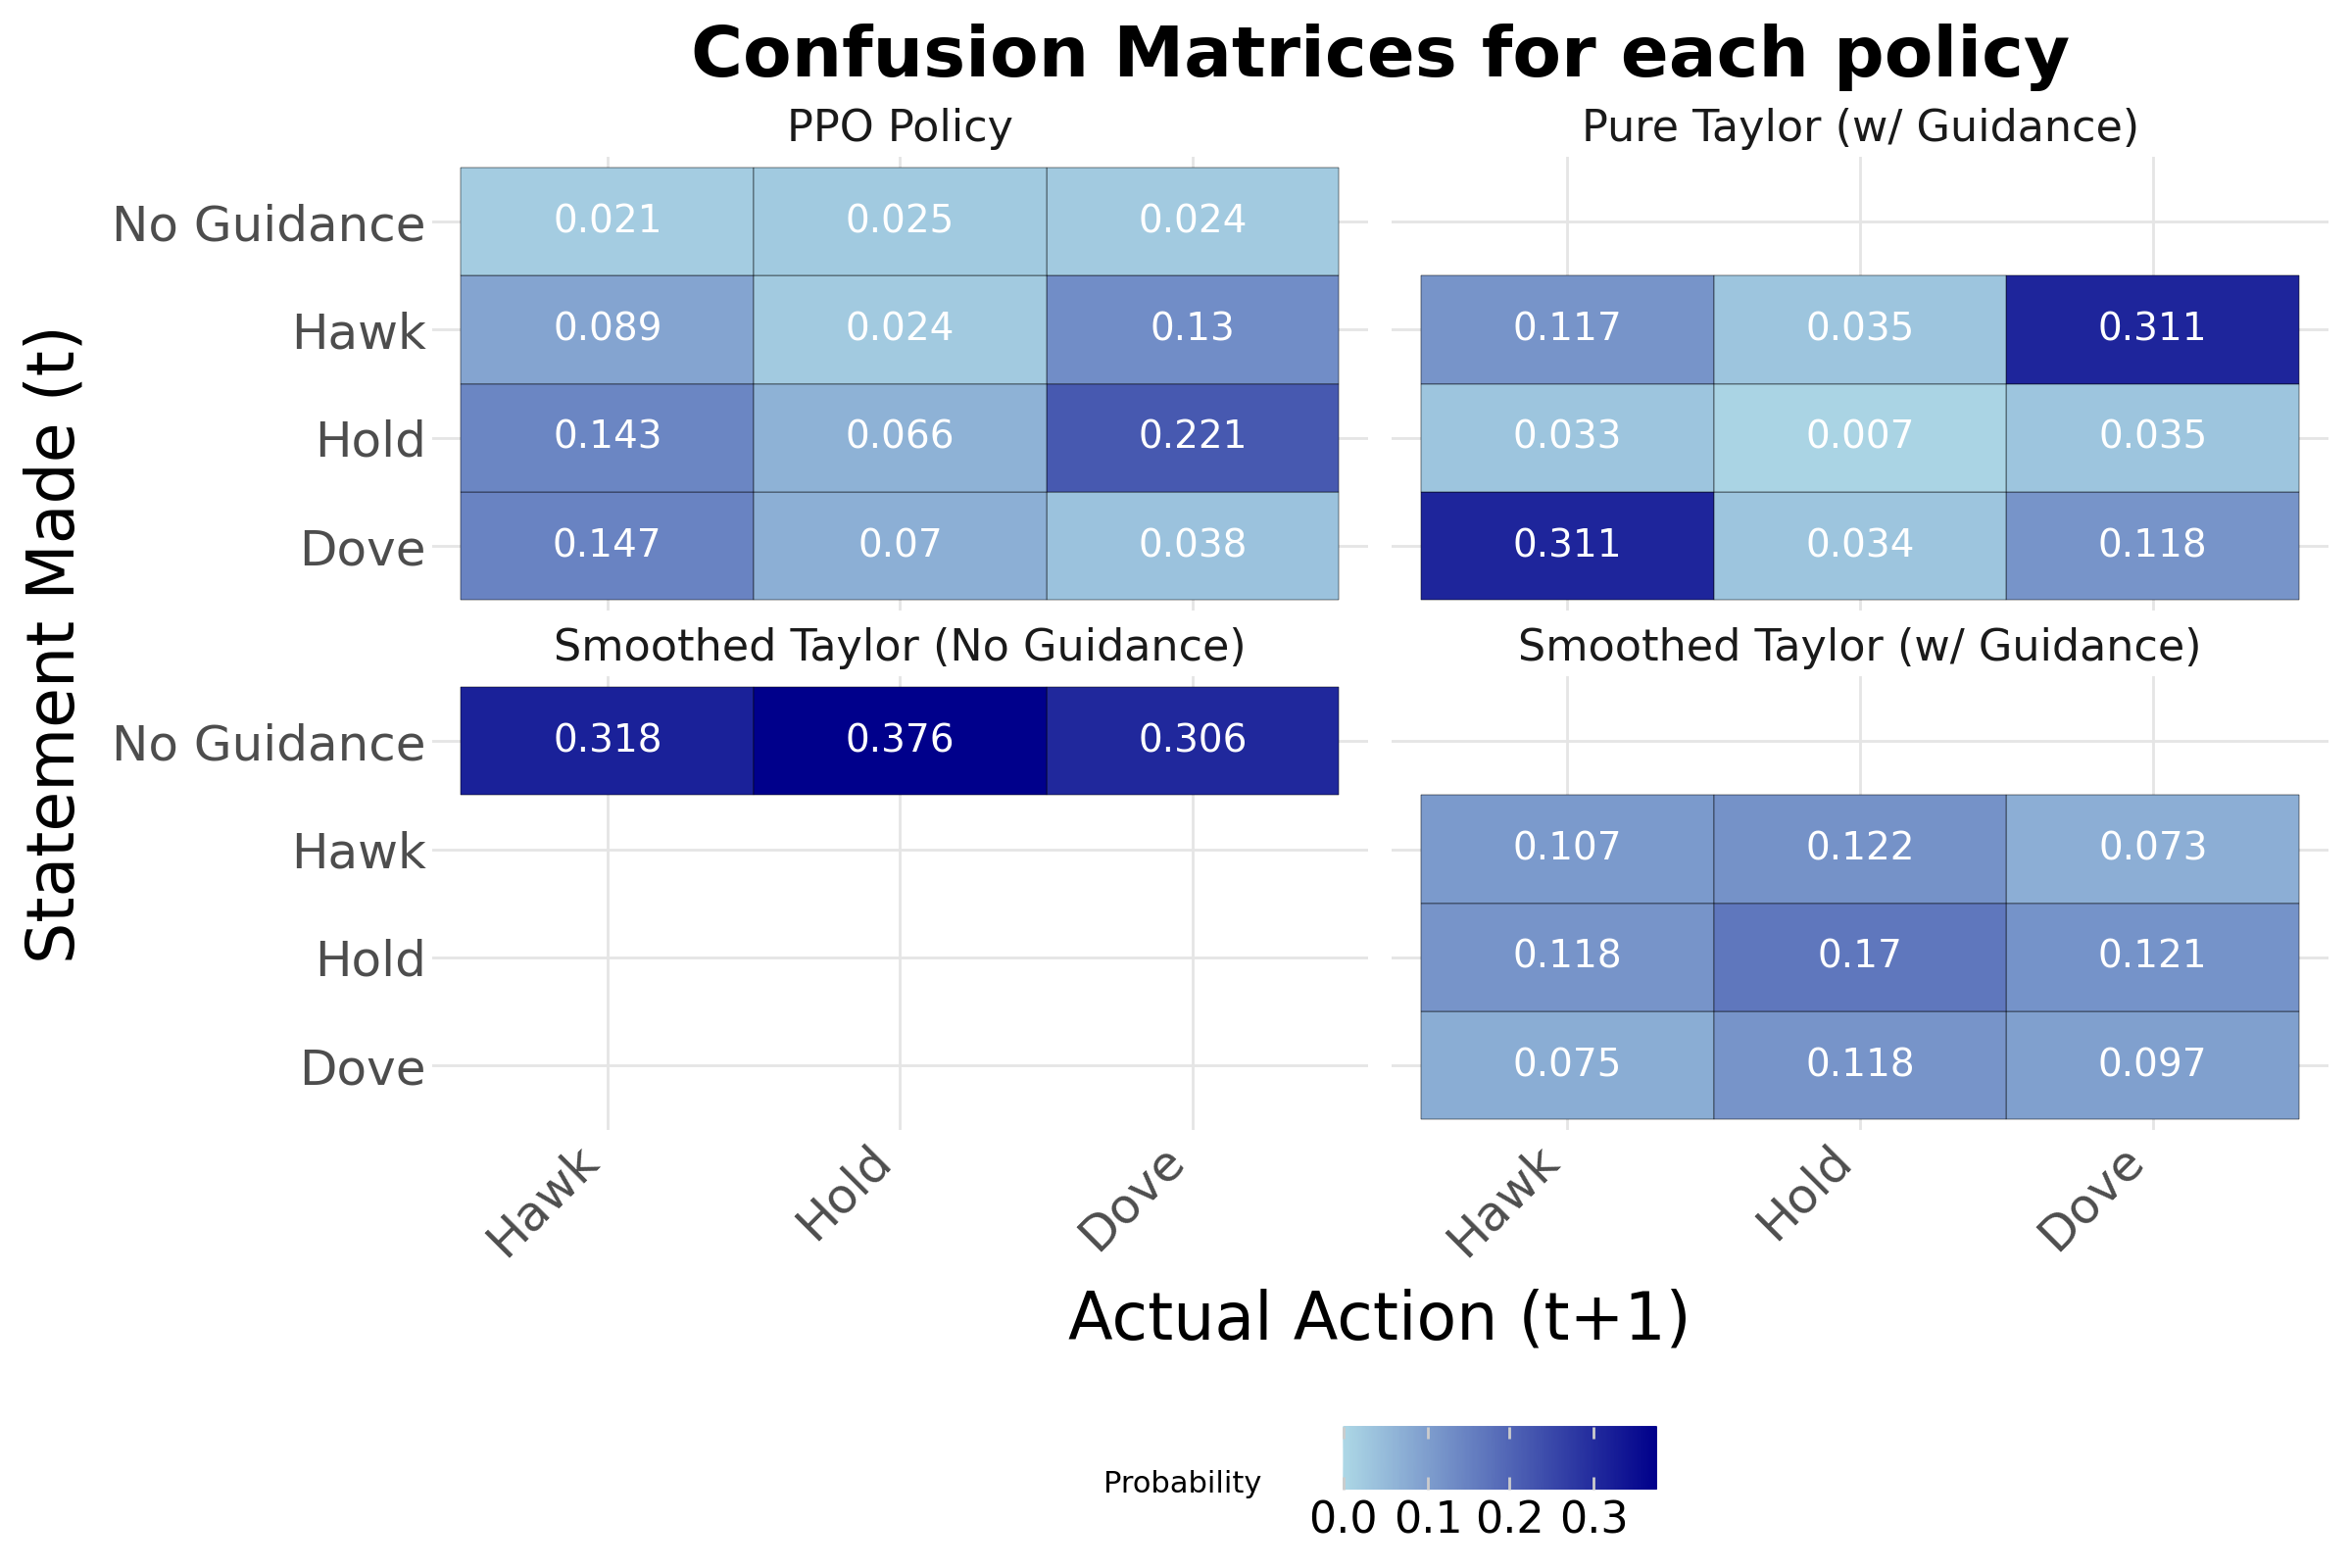

In [ ]:
import pandas as pd
from plotnine import *

# 1. Define a helper function to process any dataframe consistently
def get_confusion_matrix(df, label):
    # Map statements
    statement_map = {0: "Dove", 1: "Hold", 2: "Hawk", 3: "No Guidance"}
    df = df.copy() # Safe copy
    df["statement_label"] = df["statements"].map(statement_map)

    # Shift Actions
    df["next_delta"] = df.groupby("trajectory")["delta_i"].shift(-1)

    # Label Actions
    def delta_to_action(delta):
        if pd.isna(delta): return "End"
        if delta > 0: return "Hawk"
        elif delta < 0: return "Dove"
        else: return "Hold"
    
    df["actual_next_action"] = df["next_delta"].apply(delta_to_action)

    # Filter and Count
    clean_df = df[df["actual_next_action"] != "End"]
    
    cm = (
        clean_df
        .groupby(["statement_label", "actual_next_action"])
        .size()
        .reset_index(name="count")
    )
    
    # Calculate Probability (Normalization)
    # normalizing by the total sum makes the two plots comparable 
    # even if one has slightly fewer valid rows.
    cm["prob"] = cm["count"] / cm["count"].sum()
    cm["prob_label"] = cm["prob"].round(3).astype(str) # For text display
    
    # Add the Label (e.g., "Smoothed" vs "Pure")
    cm["Sim_Type"] = label
    
    return cm

# 2. Process both dataframes
cm_smooth = get_confusion_matrix(full_panel_smooth_guide, "Smoothed Taylor (w/ Guidance)")
cm_pure = get_confusion_matrix(full_panel_guide, "Pure Taylor (w/ Guidance)")
cm_smooth_classic = get_confusion_matrix(full_panel_smooth_classic, "Smoothed Taylor (No Guidance)")
cm_ppo = get_confusion_matrix(ppo_df, "PPO Policy")

# 3. Combine them
all_cm = pd.concat([cm_smooth, cm_pure, cm_smooth_classic, cm_ppo])

# 4. Enforce Categories (Order: Dove -> Hold -> Hawk)
logic_order = ["No Guidance", "Hawk", "Hold", "Dove"]
logic_order_stmt = ["Dove", "Hold", "Hawk", "No Guidance"]
all_cm["actual_next_action"] = pd.Categorical(all_cm["actual_next_action"], categories=logic_order, ordered=True)
all_cm["statement_label"] = pd.Categorical(all_cm["statement_label"], categories=logic_order_stmt, ordered=True)
# all_cm = all_cm.dropna() # Drop "No Guidance" if not in logic_order, or add it to logic_order if you want it

all_cm
# # 5. Plot Side-by-Side
plot_comparison = (
    ggplot(all_cm, aes(x="actual_next_action", y="statement_label", fill="prob")) +
    geom_tile(color="black") +
    geom_text(aes(label="prob_label"), size=14, color="white") + 
    # Use limits to ensure the scale goes from 0 to 1 (or max observed prob)
    scale_fill_gradient(low="lightblue", high="darkblue", limits=[0, all_cm["prob"].max()]) +
    facet_wrap("Sim_Type") + # <--- The Magic Command
    labs(
        title="Confusion Matrices for each policy",
        x="Actual Action (t+1)",
        y="Statement Made (t)",
        fill="Probability"
    ) +
    # scale_y_discrete(limits=logic_order) +
    theme_economy()
    # theme(figure_size=(18, 10))
)

# plot_comparison.save("figs/confusion_plot.svg")
plot_comparison.save("figs/confusion_matrix.pdf")

plot_comparison

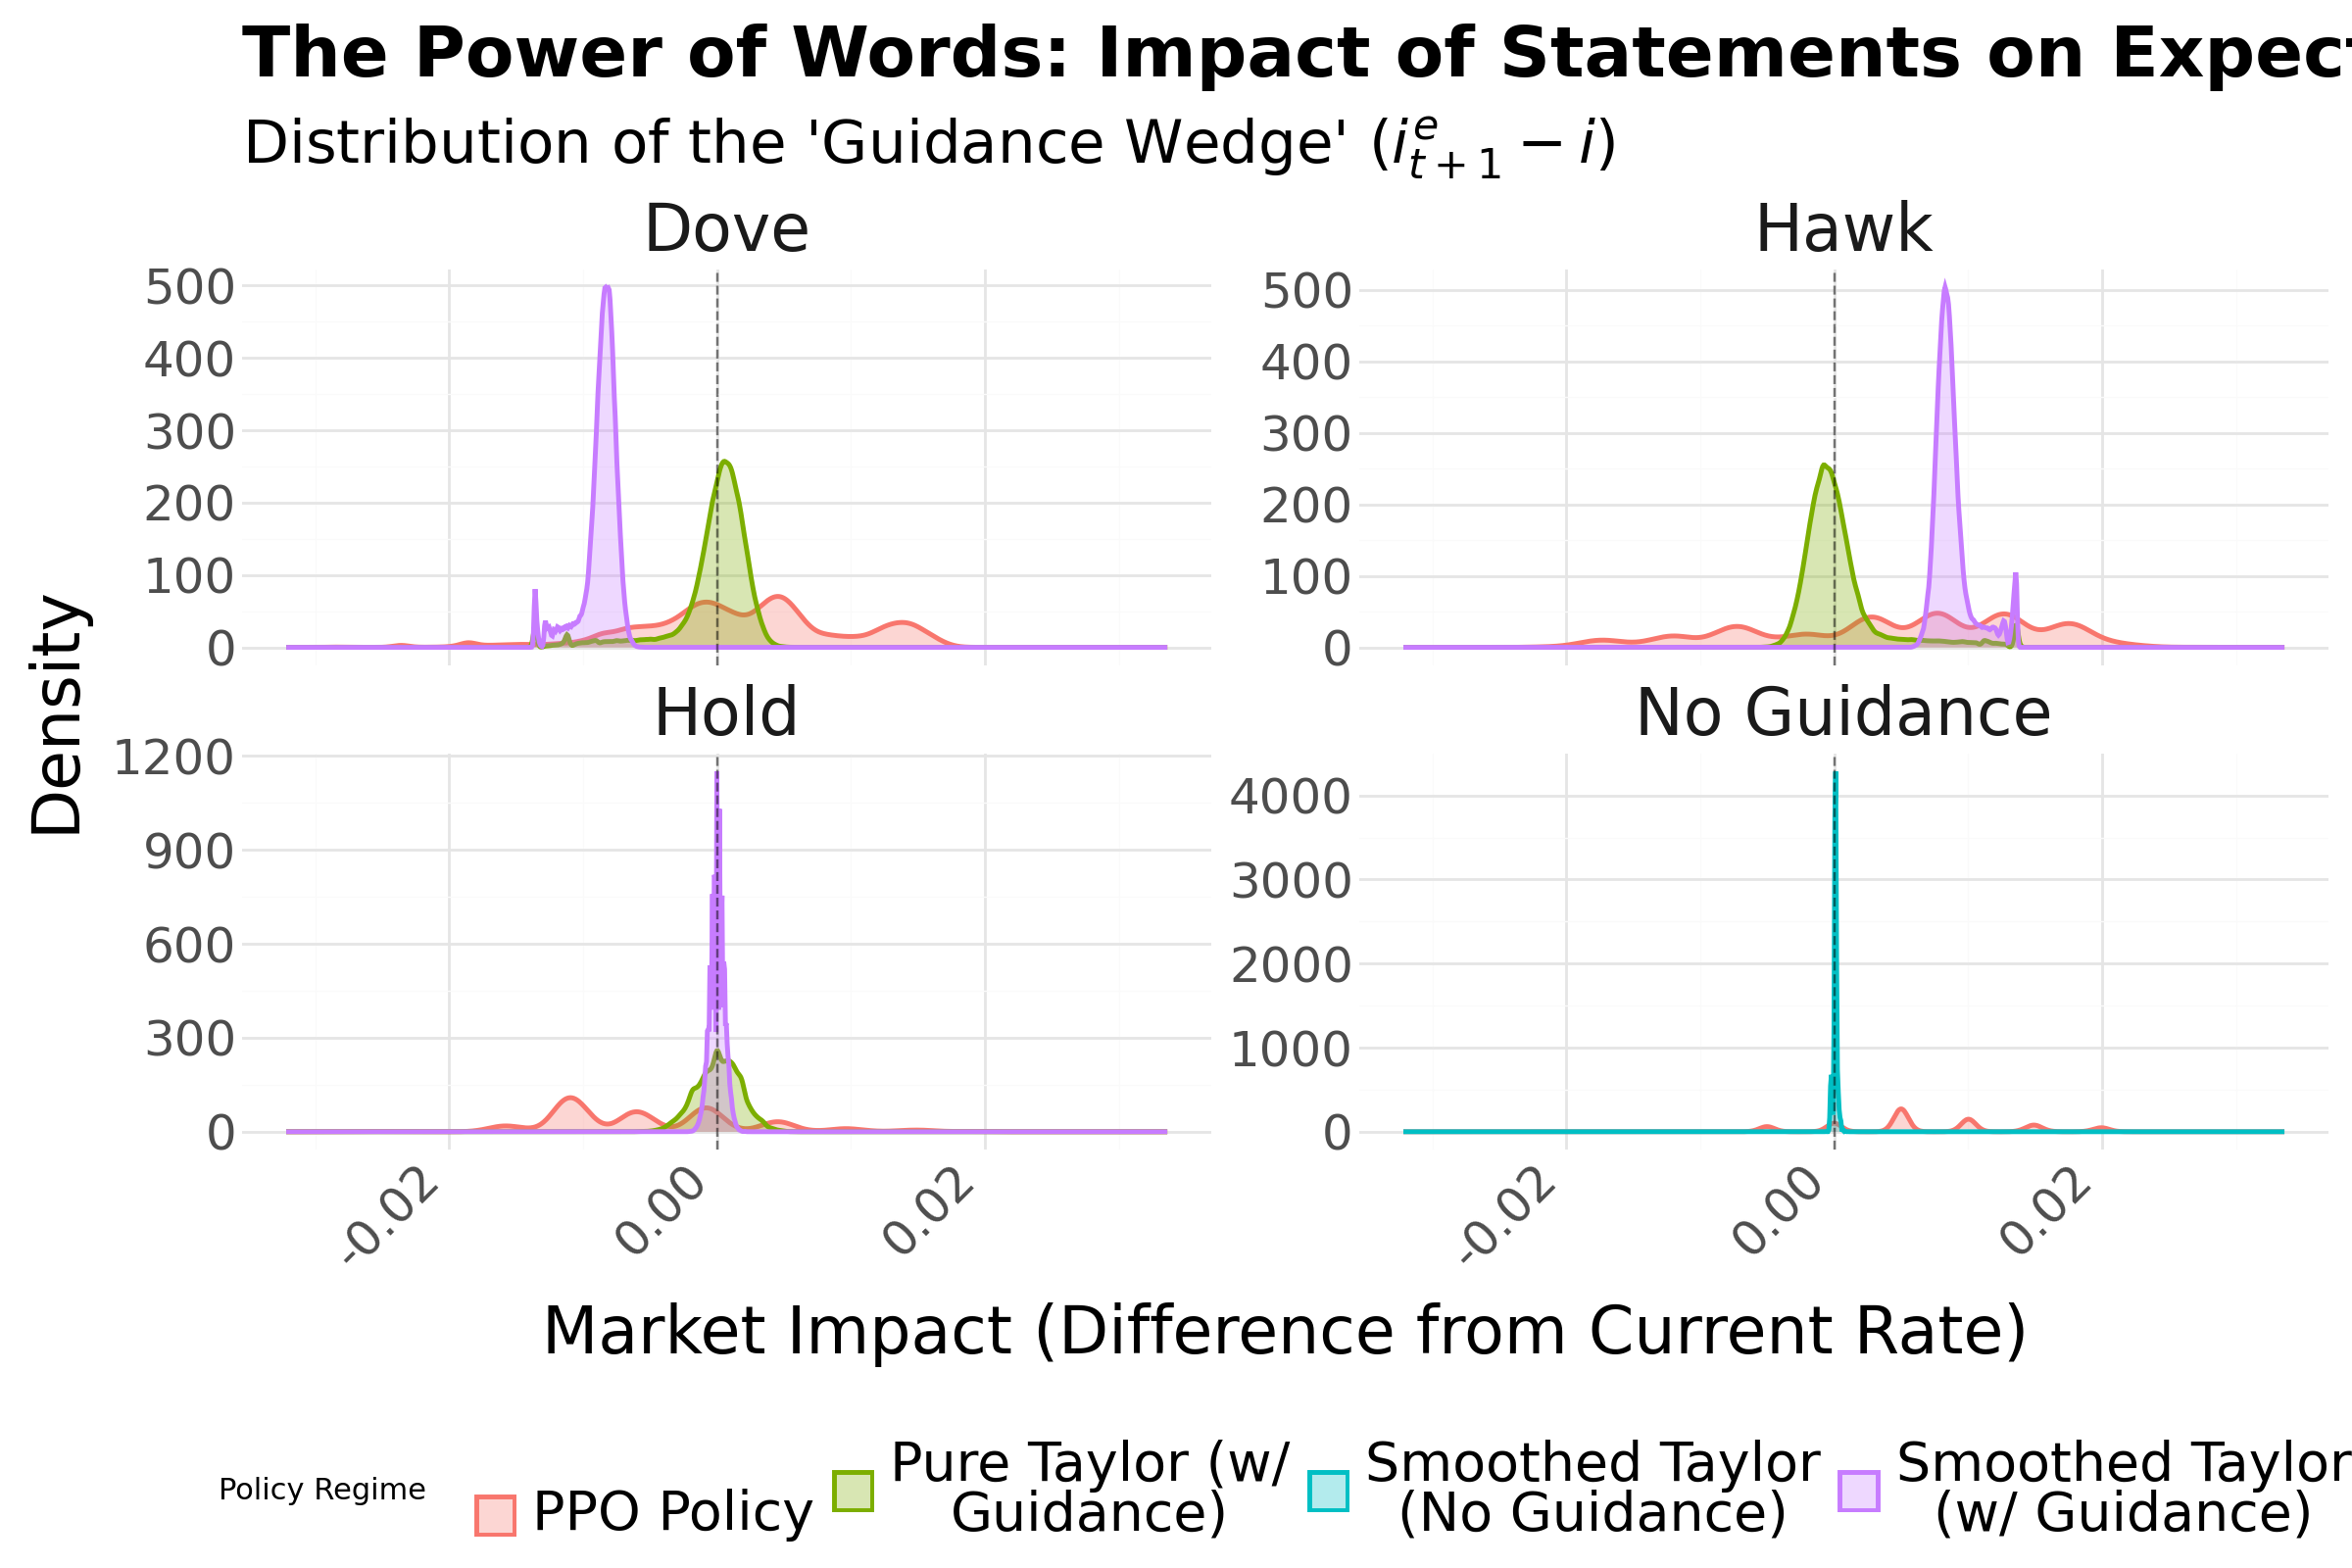

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/guidance_wedge.pdf


In [ ]:
import pandas as pd
from plotnine import *
import textwrap

def plot_guidance_impact(df, policy_col="Policy", statement_col="statements"):
    """
    Generalised function to plot the impact of forward guidance.
    
    Parameters:
    - df: Combined DataFrame containing all policies.
    - policy_col: The name of the column distinguishing policy types (e.g., 'Rule').
    - statement_col: The name of the column containing categorical guidance values.
    """
    # 1. Prepare Data
    plot_df = df.copy()
    
    # Calculate the "Wedge" (Expectations deviation from current rates)
    # Using .get() to ensure columns exist or handle errors gracefully
    plot_df["guidance_wedge"] = plot_df["i_exp"] - plot_df["i"]
    
    # 2. Map Statements
    # We keep it flexible: map numeric codes to readable labels
    statement_map = {0: "Dove", 1: "Hold", 2: "Hawk", 3: "No Guidance"}
    
    # Filter for known guidance types and map names
    plot_df = plot_df[plot_df[statement_col].isin(statement_map.keys())].copy()
    plot_df["Statement_Label"] = plot_df[statement_col].map(statement_map)

    plot_df[policy_col] = plot_df[policy_col].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=18))
    )
    
    # 3. Build Plot
    plot = (
        ggplot(plot_df, aes(x="guidance_wedge", fill=policy_col, color=policy_col)) +
        
        # Density plot for distribution
        geom_density(alpha=0.3, size=1) +
        
        # Reference line at zero (where expectations = current rate)
        geom_vline(xintercept=0, linetype="dashed", color="black", alpha=0.5) +
        
        # Facet by Statement Type
        facet_wrap("~Statement_Label", scales="free_y") +
        
        labs(
            title="The Power of Words: Impact of Statements on Expectations",
            subtitle="Distribution of the 'Guidance Wedge' ($i_{t+1}^e - i$)",
            x="Market Impact (Difference from Current Rate)",
            y="Density",
            color="Policy Regime",
            fill = "Policy Regime"
        ) +
        theme_economy() +
        theme(strip_text=element_text(size = 24),
              legend_text=element_text(size = 20))
    )
    
    return plot


p = plot_guidance_impact(combined, policy_col="Simulation Type")
display(p)
p.save("figs/guidance_wedge.pdf")

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_bin_2d : Removed 100 rows containing non-finite values.


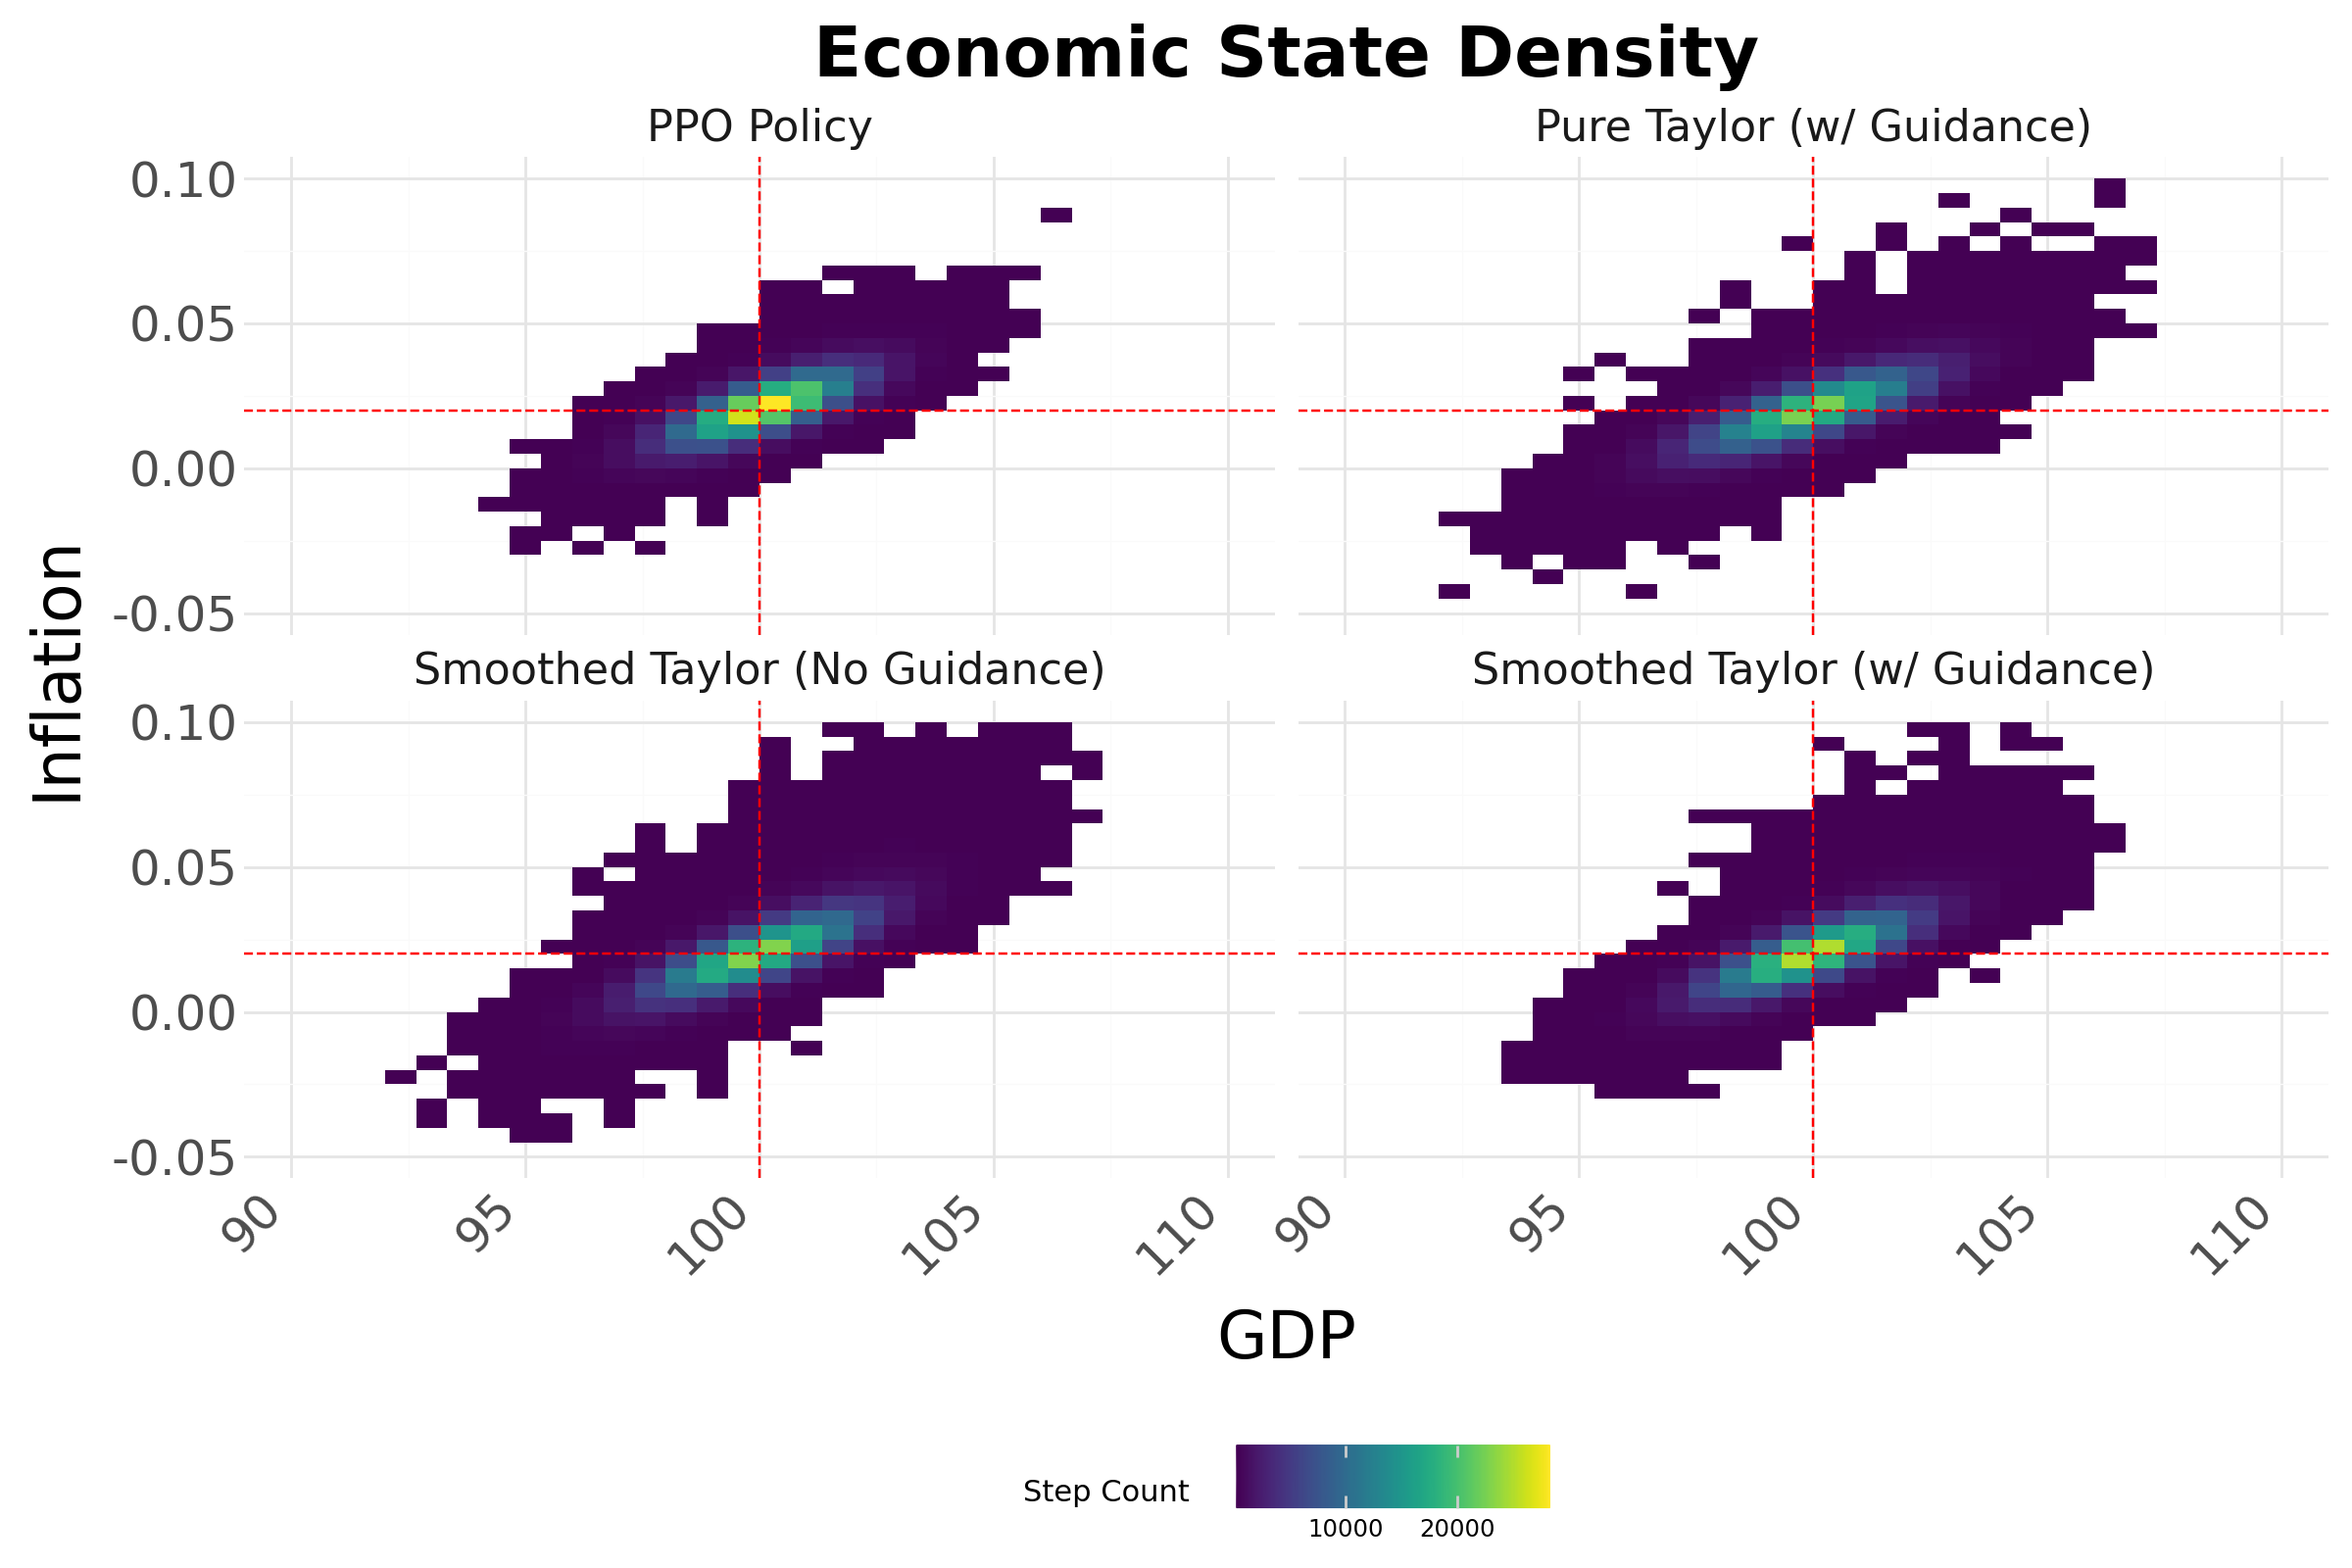

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/tile_plot.pdf
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_bin_2d : Removed 100 rows containing non-finite values.


In [ ]:
def tile_plot(df, policy_col = "Simulation Type"):
    p = (
        ggplot(df, aes(x = "GDP", y = "Inflation")) +
        stat_bin2d() + 
        facet_wrap(policy_col) +
        theme_economy() +
        xlim(90, 110) +
        ylim(-0.05, 0.1) +
        # coord_cartesian(xlim=(80, 120), ylim=(-0.05, 0.10)) +
        geom_vline(aes(xintercept = 100), color = "red", linetype = "--") +
        geom_hline(aes(yintercept = 0.02), color = "red", linetype = "--") +
        labs(title="Economic State Density", fill="Step Count")
    )
    
    return p

p = tile_plot(combined)
display(p)
p.save("figs/tile_plot.pdf")


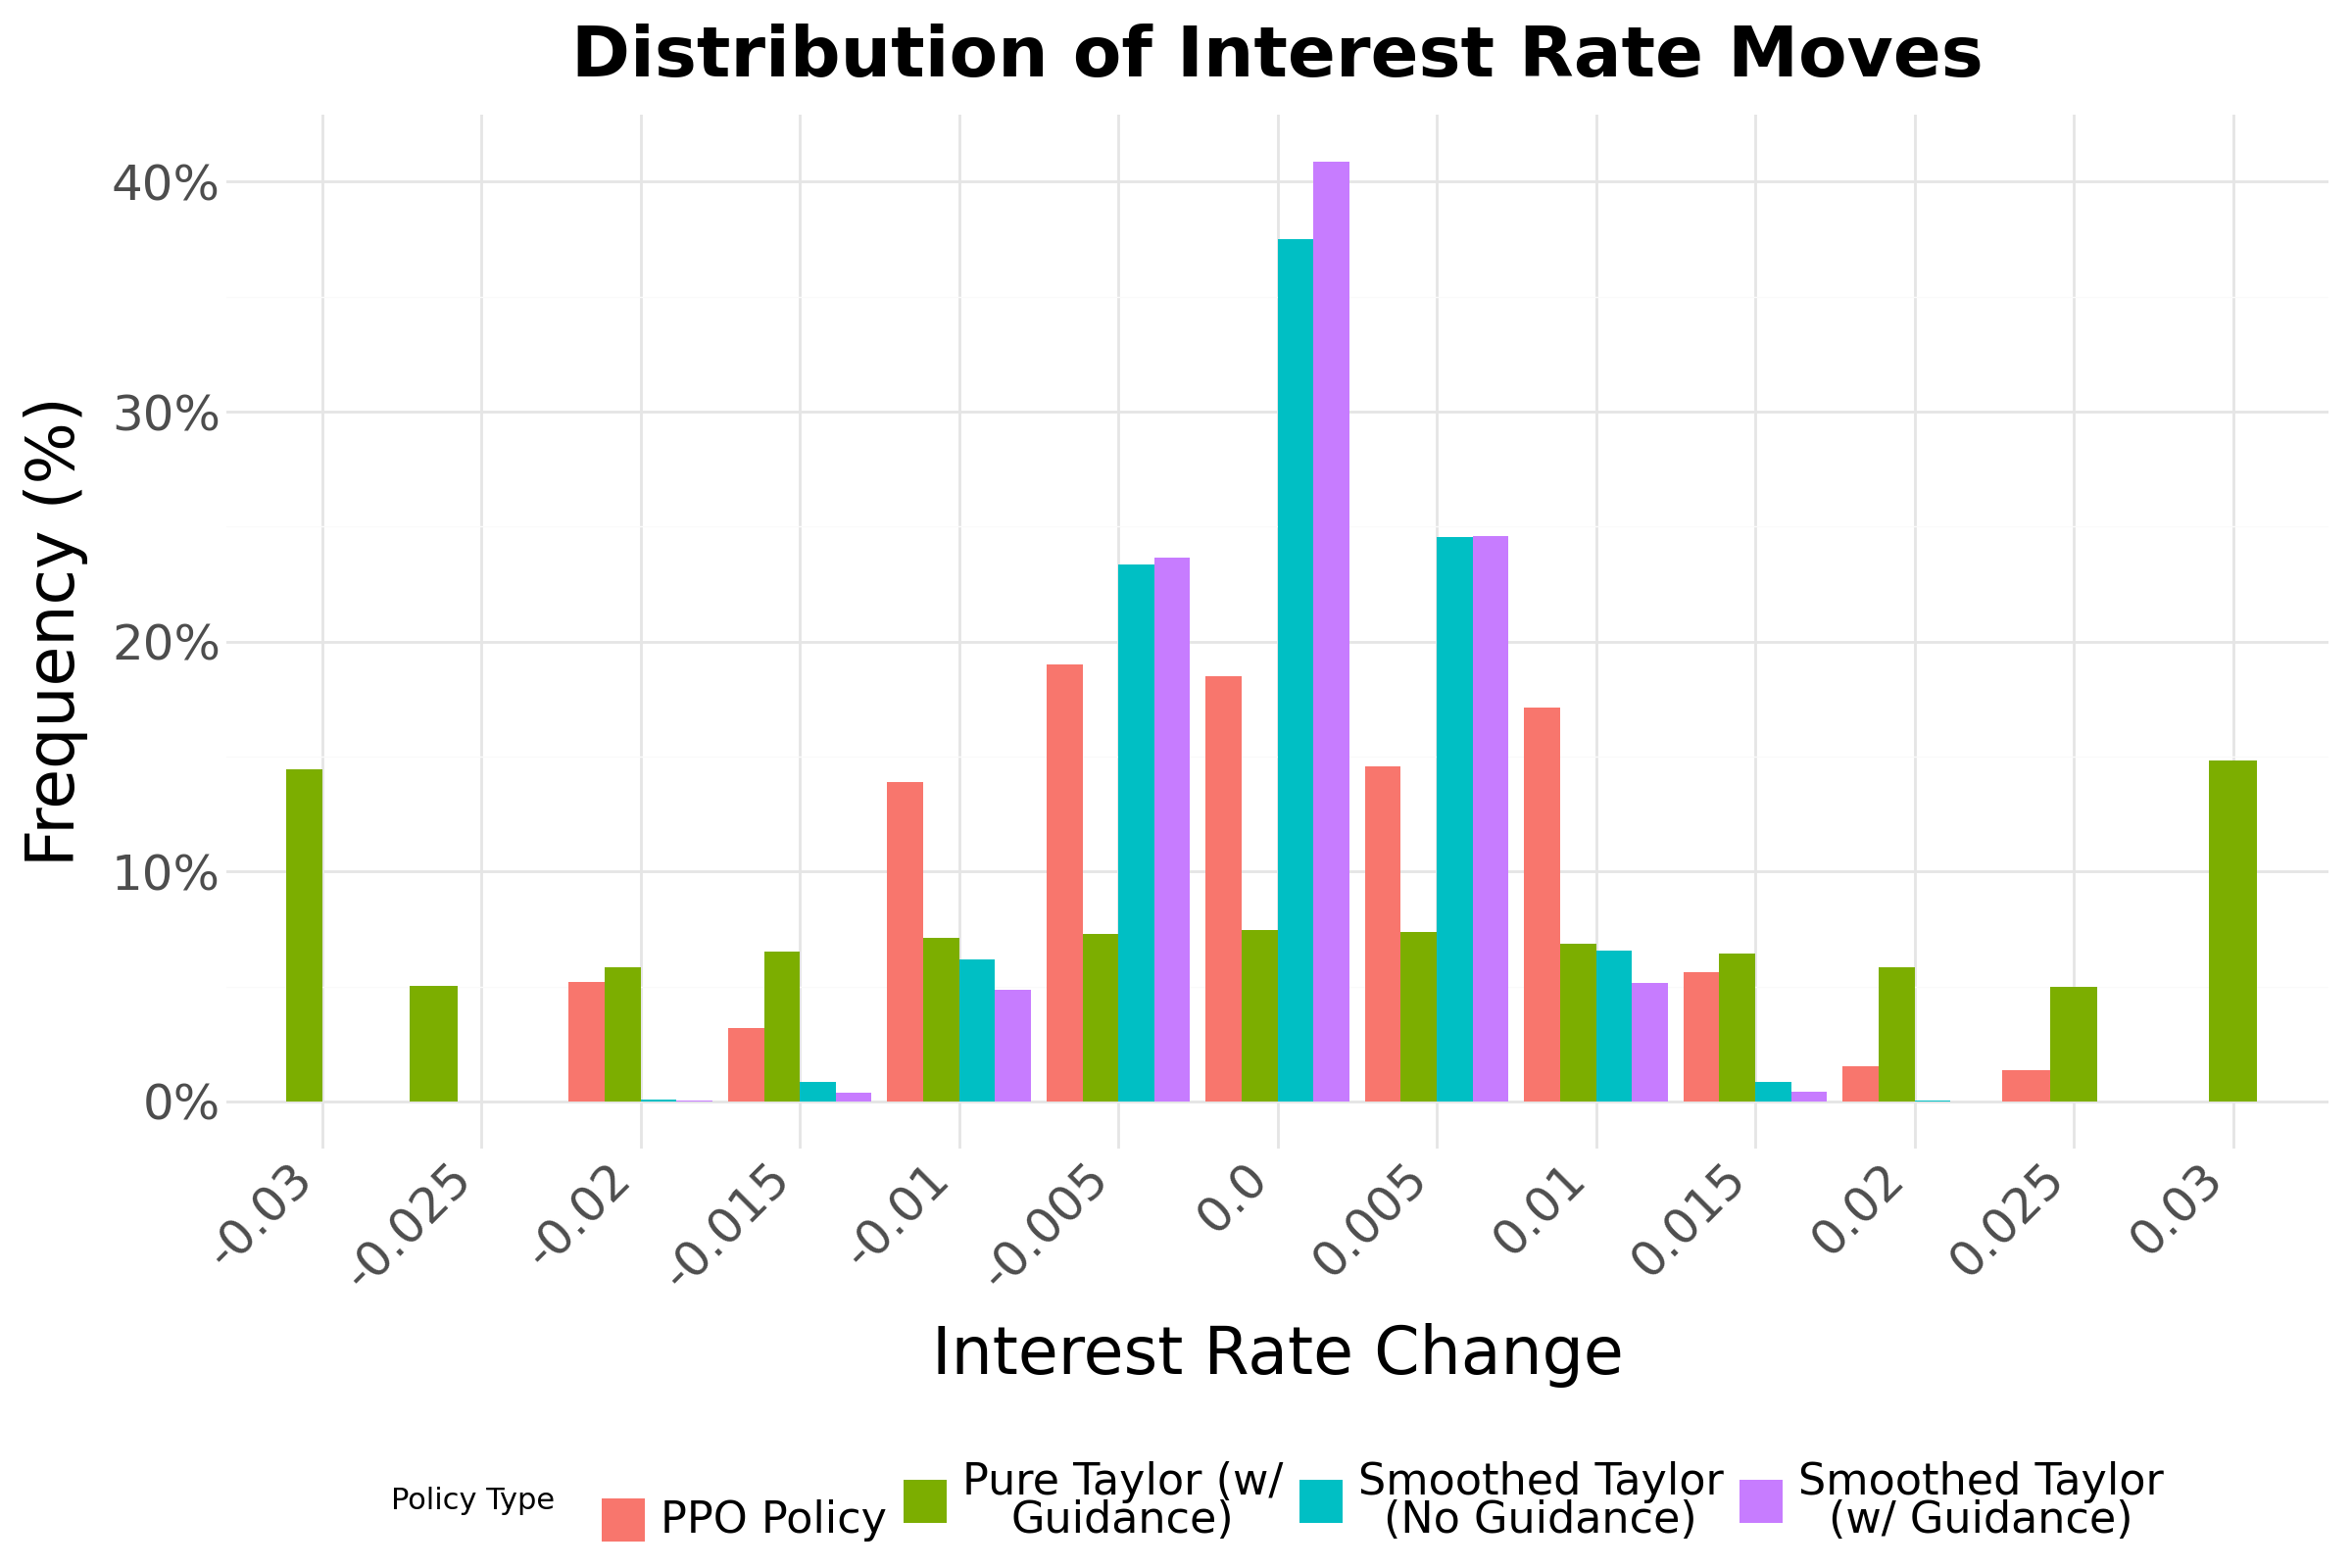

c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/delta_i_dist.pdf


In [ ]:
import textwrap

def move_dist_plot(df, policy_col="Simulation Type"):
    # 1. Calculate Percentages
    # We group by policy and action, count, then divide by the policy's total count
    df_plot = (
        df.groupby([policy_col, "delta_i"])
        .size()
        .reset_index(name='count')
    )
    
    # Calculate percentages per Policy group
    df_plot['percentage'] = df_plot.groupby(policy_col)['count'].transform(lambda x: x / x.sum() * 100)

    df_plot[policy_col] = df_plot[policy_col].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=18))
    )

    # 2. Build the Plot
    p = (
        ggplot(df_plot, aes(x="factor(delta_i)", y="percentage", fill=policy_col)) +
        geom_col(position="dodge") + # 'dodge' places bars side-by-side
        scale_y_continuous(labels=lambda l: [f"{val:.0f}%" for val in l]) +
        labs(
            title="Distribution of Interest Rate Moves",
            x="Interest Rate Change",
            y="Frequency (%)",
            fill="Policy Type"
        ) +
        theme_economy()
        # theme(
        #     axis_text_x=element_text(size=18, color="black", rotation=45),
        #     axis_text_y=element_text(size=18, color="black"),
        #     axis_title_x=element_text(size=24, weight='bold', margin={'t': 15}),
        #     axis_title_y=element_text(size=24, weight='bold', margin={'r': 15}),
        #     legend_text=element_text(size=24)
        # )
    )
    return p

# Run the plot
p = move_dist_plot(combined)
display(p)
p.save("figs/delta_i_dist.pdf")

In [185]:
def delta_to_action(delta):
    if delta > 0:
        return "Hawk"
    elif delta < 0:
        return "Dove"
    else:
        return "Hold"

ppo_df["delta_i_category"] = ppo_df["delta_i"].apply(delta_to_action)

ppo_df.columns

Index(['step', 'GDP', 'Inflation', 'delta_i', 'statements', 'i', 'reward',
       'i_exp', 'expect_array', 'trajectory', 'theta', 'pi_e', 'r_star',
       'type', 'delta_i_category'],
      dtype='object')

<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\1022085192.py:54: SyntaxWarning: invalid escape sequence '\p'


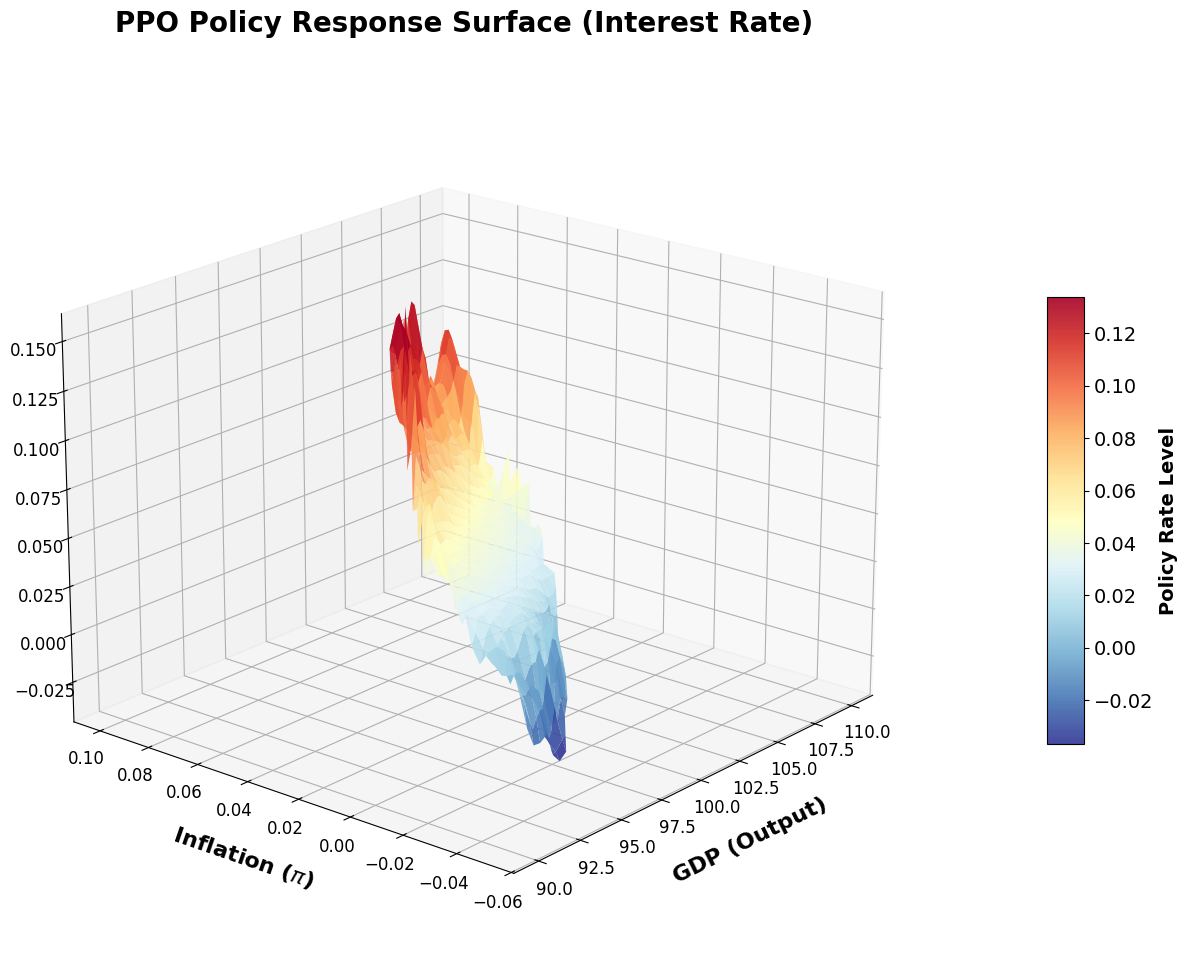

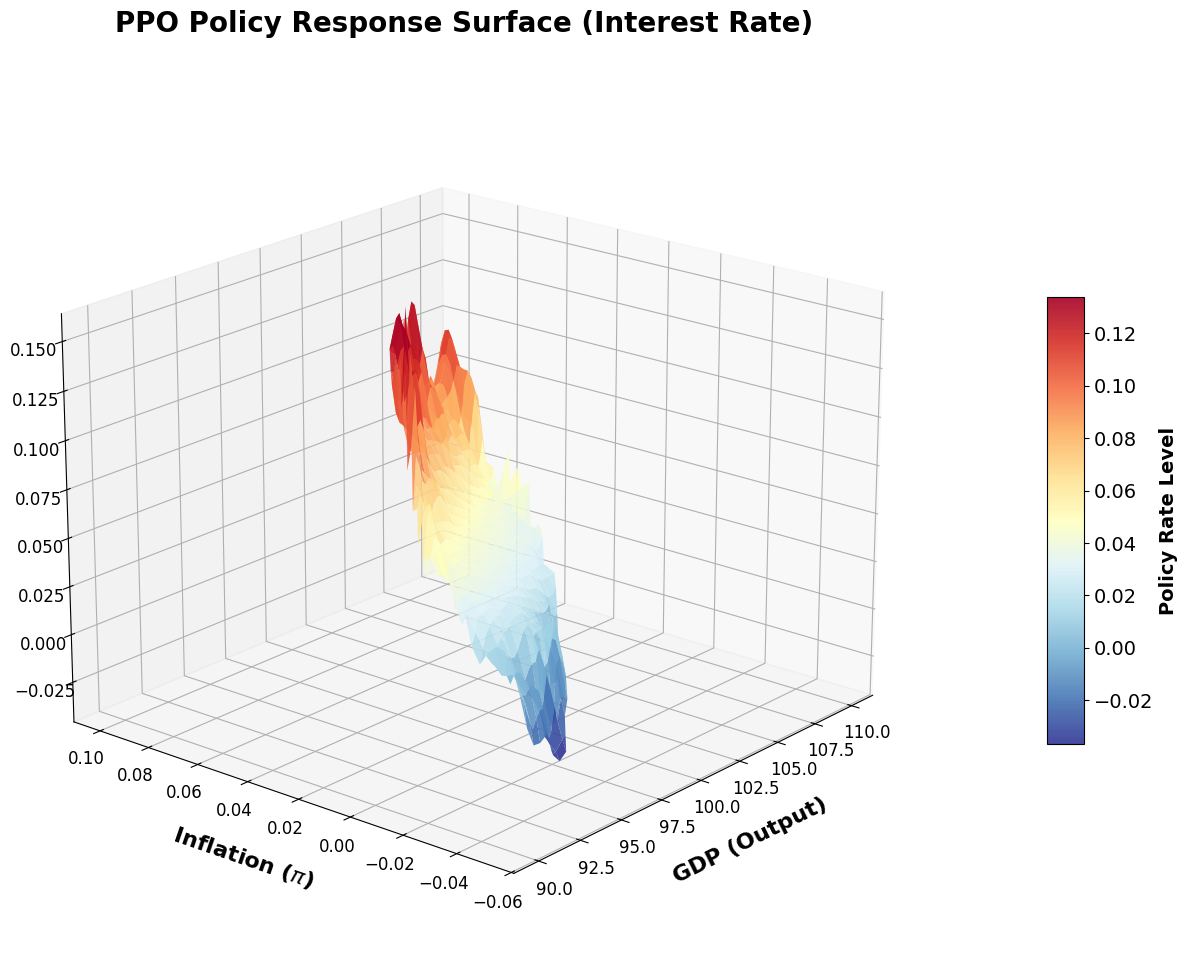

In [216]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

def plot_interest_rate_pdp(df, bins=25, save_path=None):
    # 1. DATA CLEANING: Remove outliers to focus on the stability range
    mask = (
        (df['GDP'] >= 90) & (df['GDP'] <= 110) & 
        (df['Inflation'] >= -0.05) & (df['Inflation'] <= 0.10)
    )
    df_clean = df[mask].copy()

    # 2. BINNED AGGREGATION
    # We use the mean interest rate to show the "Average Policy Response"
    df_clean['gdp_bin'] = pd.cut(df_clean['GDP'], bins=bins)
    df_clean['pi_bin'] = pd.cut(df_clean['Inflation'], bins=bins)

    res_df = df_clean.groupby(['gdp_bin', 'pi_bin'], observed=True)['i'].mean().reset_index()
    
    res_df['gdp_center'] = res_df['gdp_bin'].apply(lambda x: x.mid).astype(float)
    res_df['pi_center'] = res_df['pi_bin'].apply(lambda x: x.mid).astype(float)
    res_df = res_df.dropna()

    # 3. INTERPOLATION
    # Creating a fine mesh for a smooth surface
    g_range = np.linspace(90, 110, 100)
    p_range = np.linspace(-0.05, 0.10, 100)
    G, P = np.meshgrid(g_range, p_range)

    I = griddata(
        (res_df['gdp_center'], res_df['pi_center']),
        res_df['i'],
        (G, P),
        method='cubic'
    )

    # 4. PLOTTING
    plt.rcParams.update({'font.size': 14}) # Global font boost
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Use 'coolwarm' or 'RdYlBu_r': High rates = Red (Hot/Tight), Low rates = Blue (Cold/Loose)
    surf = ax.plot_surface(G, P, I, cmap='RdYlBu_r', alpha=0.9, 
                           antialiased=True, edgecolor='none')

    # 5. TARGET MARKERS (Stability Cross)
    # Reference lines at GDP=100 and Pi=0.02
    ax.plot([100, 100], [-0.05, 0.10], [I.min(), I.min()], 'k--', lw=2, alpha=0.5)
    ax.plot([90, 110], [0.02, 0.02], [I.min(), I.min()], 'k--', lw=2, alpha=0.5)

    # 6. TEXT AND SPACING CLEANUP
    ax.set_xlabel('GDP (Output)', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_ylabel('Inflation ($\pi$)', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_zlabel('Interest Rate ($i$)', fontsize=16, fontweight='bold', labelpad=15)
    
    ax.set_title('PPO Policy Response Surface (Interest Rate)', 
                 fontsize=20, fontweight='bold', pad=30)

    # Adjusting tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Adjust view for the "Taylor Slope"
    ax.view_init(elev=20, azim=220)

    # Thick colorbar with clear labels
    cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
    cbar.set_label('Policy Rate Level', fontsize=14, fontweight='bold')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Call the function
plot_interest_rate_pdp(ppo_df)

<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:60: SyntaxWarning: invalid escape sequence '\D'
<>:62: SyntaxWarning: invalid escape sequence '\D'
<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:60: SyntaxWarning: invalid escape sequence '\D'
<>:62: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\909370303.py:59: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\909370303.py:60: SyntaxWarning: invalid escape sequence '\D'
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\909370303.py:62: SyntaxWarning: invalid escape sequence '\D'


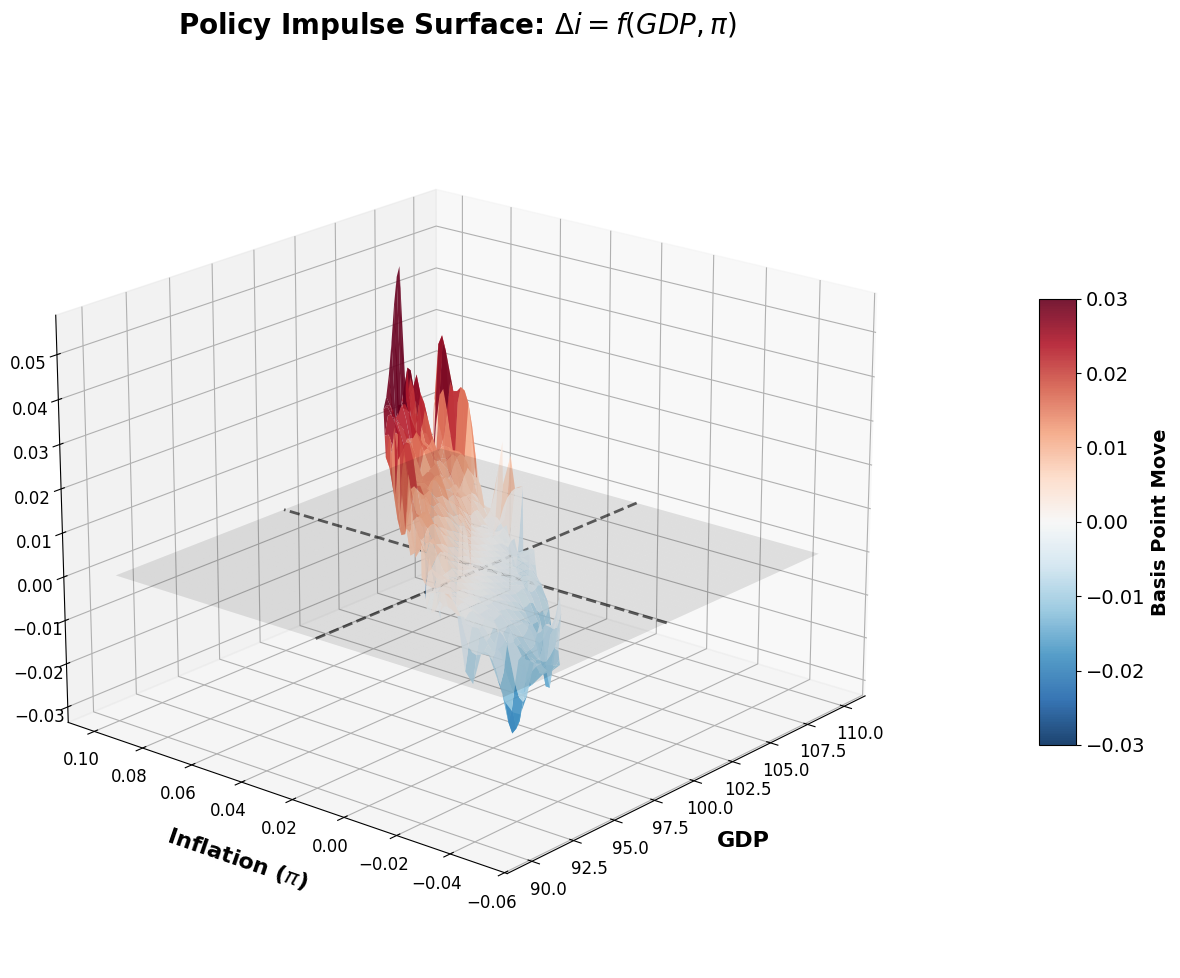

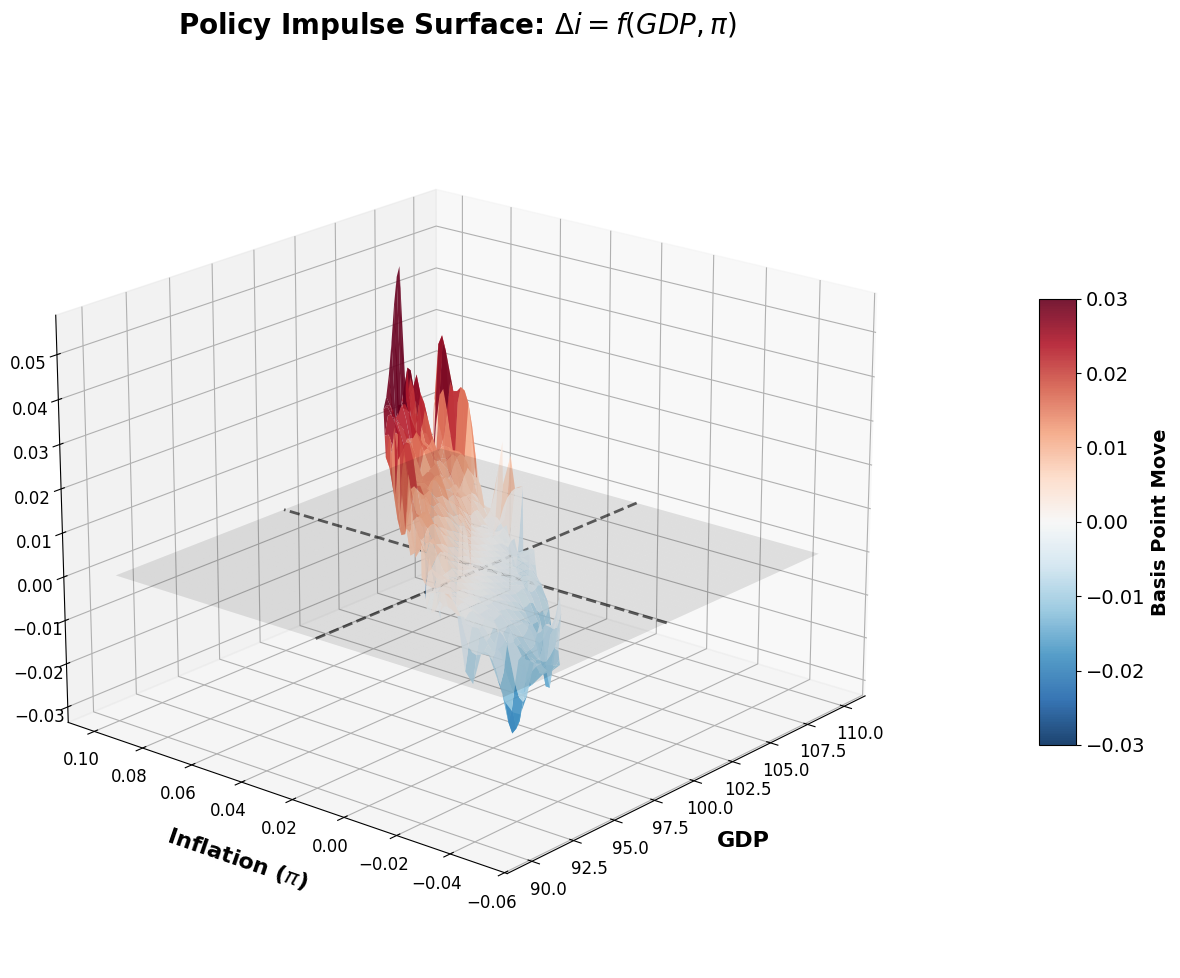

In [217]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

def plot_delta_i_surface(df, bins=25, save_path=None):
    # 1. FILTERING: Use your specified corridors
    mask = (
        (df['GDP'] >= 90) & (df['GDP'] <= 110) & 
        (df['Inflation'] >= -0.05) & (df['Inflation'] <= 0.10)
    )
    df_clean = df[mask].copy()

    # 2. BINNED AGGREGATION
    # We calculate the MEAN of the rate change chosen at each state
    df_clean['gdp_bin'] = pd.cut(df_clean['GDP'], bins=bins)
    df_clean['pi_bin'] = pd.cut(df_clean['Inflation'], bins=bins)

    res_df = df_clean.groupby(['gdp_bin', 'pi_bin'], observed=True)['delta_i'].mean().reset_index()
    
    res_df['gdp_center'] = res_df['gdp_bin'].apply(lambda x: x.mid).astype(float)
    res_df['pi_center'] = res_df['pi_bin'].apply(lambda x: x.mid).astype(float)
    res_df = res_df.dropna()

    # 3. INTERPOLATION
    g_range = np.linspace(90, 110, 100)
    p_range = np.linspace(-0.05, 0.10, 100)
    G, P = np.meshgrid(g_range, p_range)

    # Use 'linear' interpolation here if 'cubic' creates artificial waves 
    # at the edges of your data
    DI = griddata(
        (res_df['gdp_center'], res_df['pi_center']),
        res_df['delta_i'],
        (G, P),
        method='cubic'
    )

    # 4. PLOTTING
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 'RdBu_r' is the perfect colormap for moves: 
    # Red = Hikes (+), Blue = Cuts (-), White = Hold (0)
    surf = ax.plot_surface(G, P, DI, cmap='RdBu_r', alpha=0.9, 
                           antialiased=True, edgecolor='none')

    # 5. ZERO-LEVEL PLANE (The "Neutral" Reference)
    # This helps visualize where the agent decides to DO NOTHING
    ax.plot_surface(G, P, np.zeros_like(DI), color='black', alpha=0.1)

    # 6. TARGET LINES (Stability Cross)
    ax.plot([100, 100], [-0.05, 0.10], [0, 0], 'k--', lw=2, alpha=0.6)
    ax.plot([90, 110], [0.02, 0.02], [0, 0], 'k--', lw=2, alpha=0.6)

    # 7. FORMATTING
    ax.set_xlabel('GDP', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_ylabel('Inflation ($\pi$)', fontsize=16, fontweight='bold', labelpad=15)
    ax.set_zlabel('Rate Change ($\Delta i$)', fontsize=16, fontweight='bold', labelpad=15)
    
    ax.set_title('Policy Impulse Surface: $\Delta i = f(GDP, \pi)$', 
                 fontsize=20, fontweight='bold', pad=30)

    # Tick adjustments
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.view_init(elev=20, azim=220)

    # Colorbar centered at zero
    # We use vmin/vmax to ensure 0 is the center (white)
    limit = max(abs(res_df['delta_i'].min()), abs(res_df['delta_i'].max()))
    surf.set_clim(-limit, limit)
    
    cbar = fig.colorbar(surf, shrink=0.5, aspect=12, pad=0.1)
    cbar.set_label('Basis Point Move', fontsize=14, fontweight='bold')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Execute
plot_delta_i_surface(ppo_df)

C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\714010381.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\714010381.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\714010381.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pan

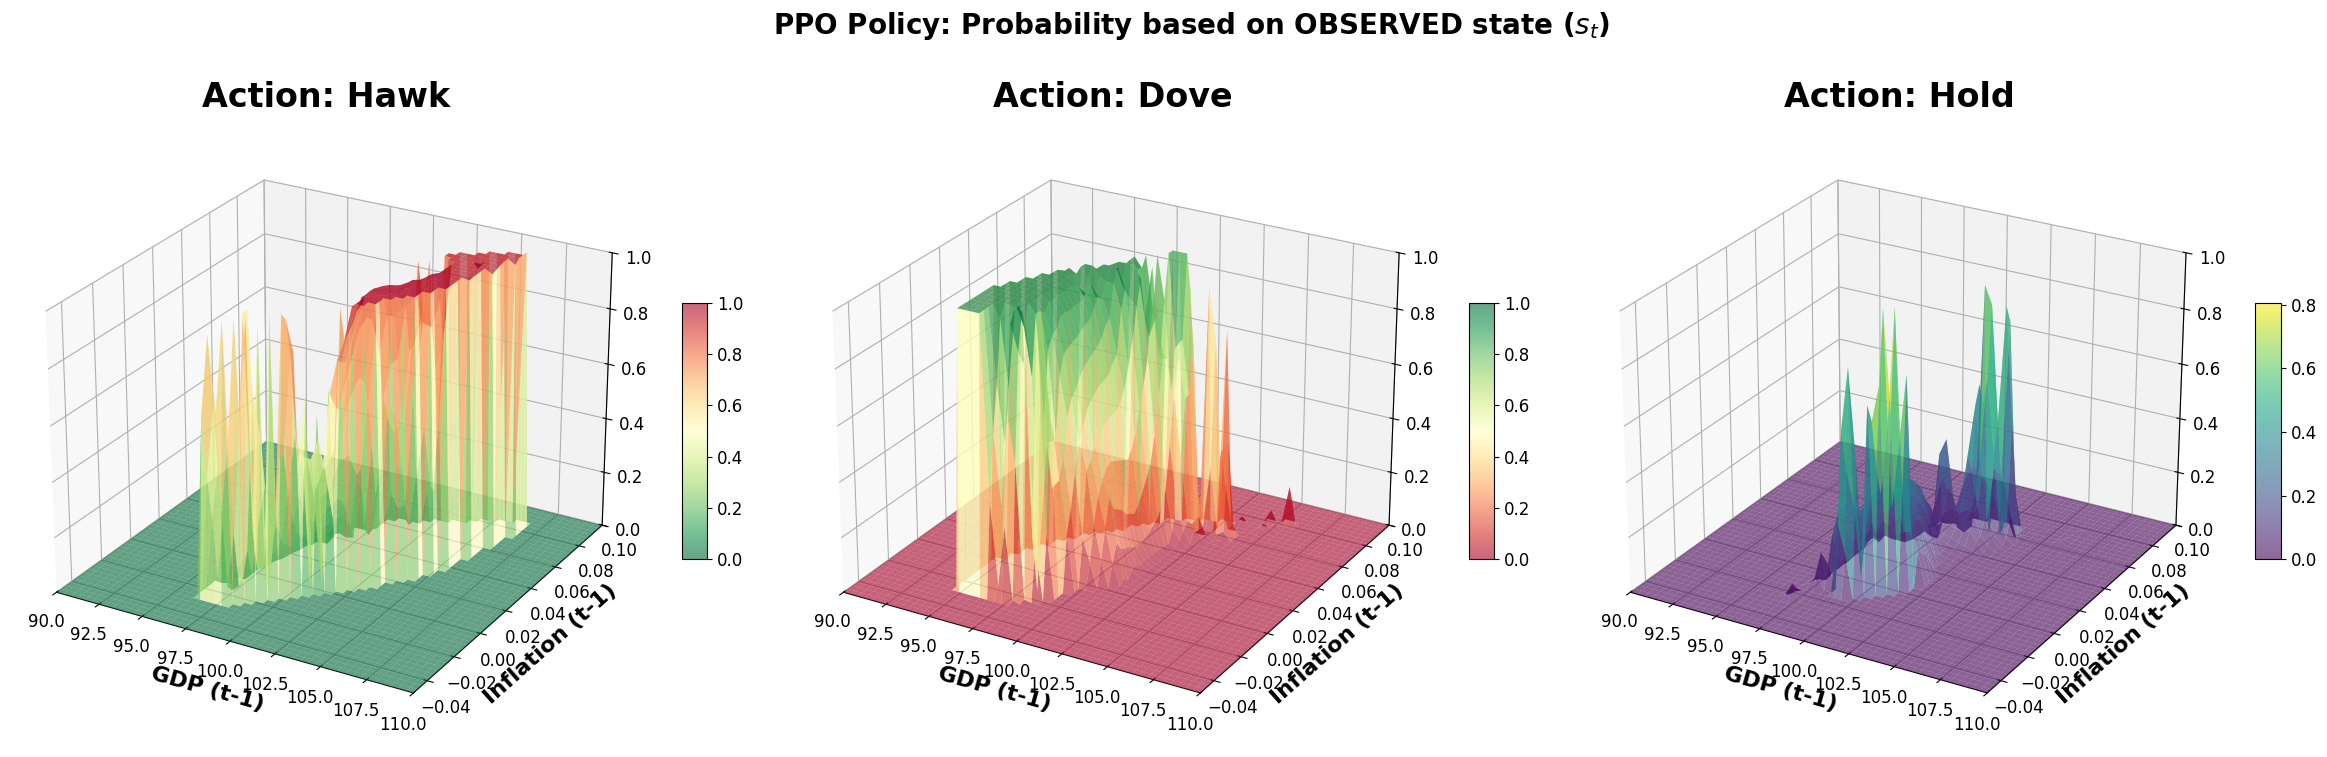

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import pandas as pd

def plot_all_policies(df, bins=20, save_prefix=None):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(24, 8))

    # ---- 1. TRAJECTORY-SAFE SHIFTING ----
    # We need the state BEFORE the action. 
    # If Row N contains Action N and the resulting GDP N+1, 
    # the agent actually saw GDP N (from Row N-1).
    
    df_plot = df.copy()
    
    # Ensure we don't shift across different episodes
    # Replace 'Episode' with your actual episode ID column name
    if 'trajectory' in df_plot.columns:
        df_plot['prev_GDP'] = df_plot.groupby('trajectory')['GDP'].shift(1)
        df_plot['prev_Inflation'] = df_plot.groupby('trajectory')['Inflation'].shift(1)
    else:
        # Fallback if no episode ID: This is risky for MC data!
        print("Warning: No 'Episode' column found. Shifting globally (not recommended for MC).")
        df_plot['prev_GDP'] = df_plot['GDP'].shift(1)
        df_plot['prev_Inflation'] = df_plot['Inflation'].shift(1)

    # ---- 2. CLEANING ----
    GDP_MIN, GDP_MAX = 90, 110
    PI_MIN, PI_MAX = -0.05, 0.10

    # Remove the NaNs created by the shift (the first step of every episode)
    df_clean = df_plot[
        df_plot['delta_i_category'].notna() & 
        df_plot['prev_GDP'].notna()
    ].copy()
    
    # Filter based on the PREVIOUS variables (what the agent saw)
    df_clean = df_clean[
        (df_clean['prev_GDP'].between(GDP_MIN, GDP_MAX)) &
        (df_clean['prev_Inflation'].between(PI_MIN, PI_MAX))
    ]

    for idx, action in enumerate(['Hawk', 'Dove', 'Hold'], 1):
        # Use the "Previous" variables for binning
        gdp_bins = np.linspace(GDP_MIN, GDP_MAX, bins + 1)
        pi_bins  = np.linspace(PI_MIN, PI_MAX, bins + 1)

        df_clean['gdp_bin'] = pd.cut(df_clean['prev_GDP'], bins=gdp_bins)
        df_clean['pi_bin']  = pd.cut(df_clean['prev_Inflation'], bins=pi_bins)

        # Calculate probabilities based on the state the agent was responding to
        prob_df = df_clean.groupby(
            ['gdp_bin', 'pi_bin'], observed=True
        ).apply(
            lambda x: (x['delta_i_category'] == action).mean()
        ).reset_index(name='probability')

        prob_df['gdp_center'] = prob_df['gdp_bin'].apply(lambda x: x.mid).astype(float)
        prob_df['pi_center']  = prob_df['pi_bin'].apply(lambda x: x.mid).astype(float)
        prob_df = prob_df.dropna()

        # ---- GRIDDING & PLOTTING ----
        gdp_range = np.linspace(GDP_MIN, GDP_MAX, 50)
        pi_range  = np.linspace(PI_MIN, PI_MAX, 50)
        gdp_grid, pi_grid = np.meshgrid(gdp_range, pi_range)

        prob_grid = griddata(
            (prob_df['gdp_center'], prob_df['pi_center']),
            prob_df['probability'],
            (gdp_grid, pi_grid),
            method='cubic',
            fill_value=0
        )
        prob_grid = np.clip(prob_grid, 0, 1)

        ax = fig.add_subplot(1, 3, idx, projection='3d')
        cmap = 'RdYlGn_r' if action == 'Hawk' else ('RdYlGn' if action == 'Dove' else 'viridis')

        surf = ax.plot_surface(
            gdp_grid, pi_grid, prob_grid,
            cmap=cmap, alpha=0.6, edgecolor='none'
        )

        # Labels and formatting
        ax.set_xlim(GDP_MIN, GDP_MAX)
        ax.set_ylim(PI_MIN, PI_MAX)
        ax.set_zlim(0, 1)
        ax.set_xlabel('GDP (t-1)', fontsize=16, fontweight='bold')
        ax.set_ylabel('Inflation (t-1)', fontsize=16, fontweight='bold')
        ax.set_title(f'Action: {action}', fontsize=24, fontweight='bold')
        ax.view_init(elev=25, azim=300)
        fig.colorbar(surf, ax=ax, shrink=0.4, aspect=10)

    fig.suptitle("PPO Policy: Probability based on OBSERVED state ($s_t$)", 
                 fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    
    if save_prefix:
        plt.savefig(f'{save_prefix}_shifted_plot.pdf', dpi=300, bbox_inches='tight')
    
    return fig

plot3d = plot_all_policies(ppo_df, bins = 40)
plot3d.show()

plot3d.savefig("figs/plot3d.pdf")

C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2542962228.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2542962228.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\2542962228.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of 

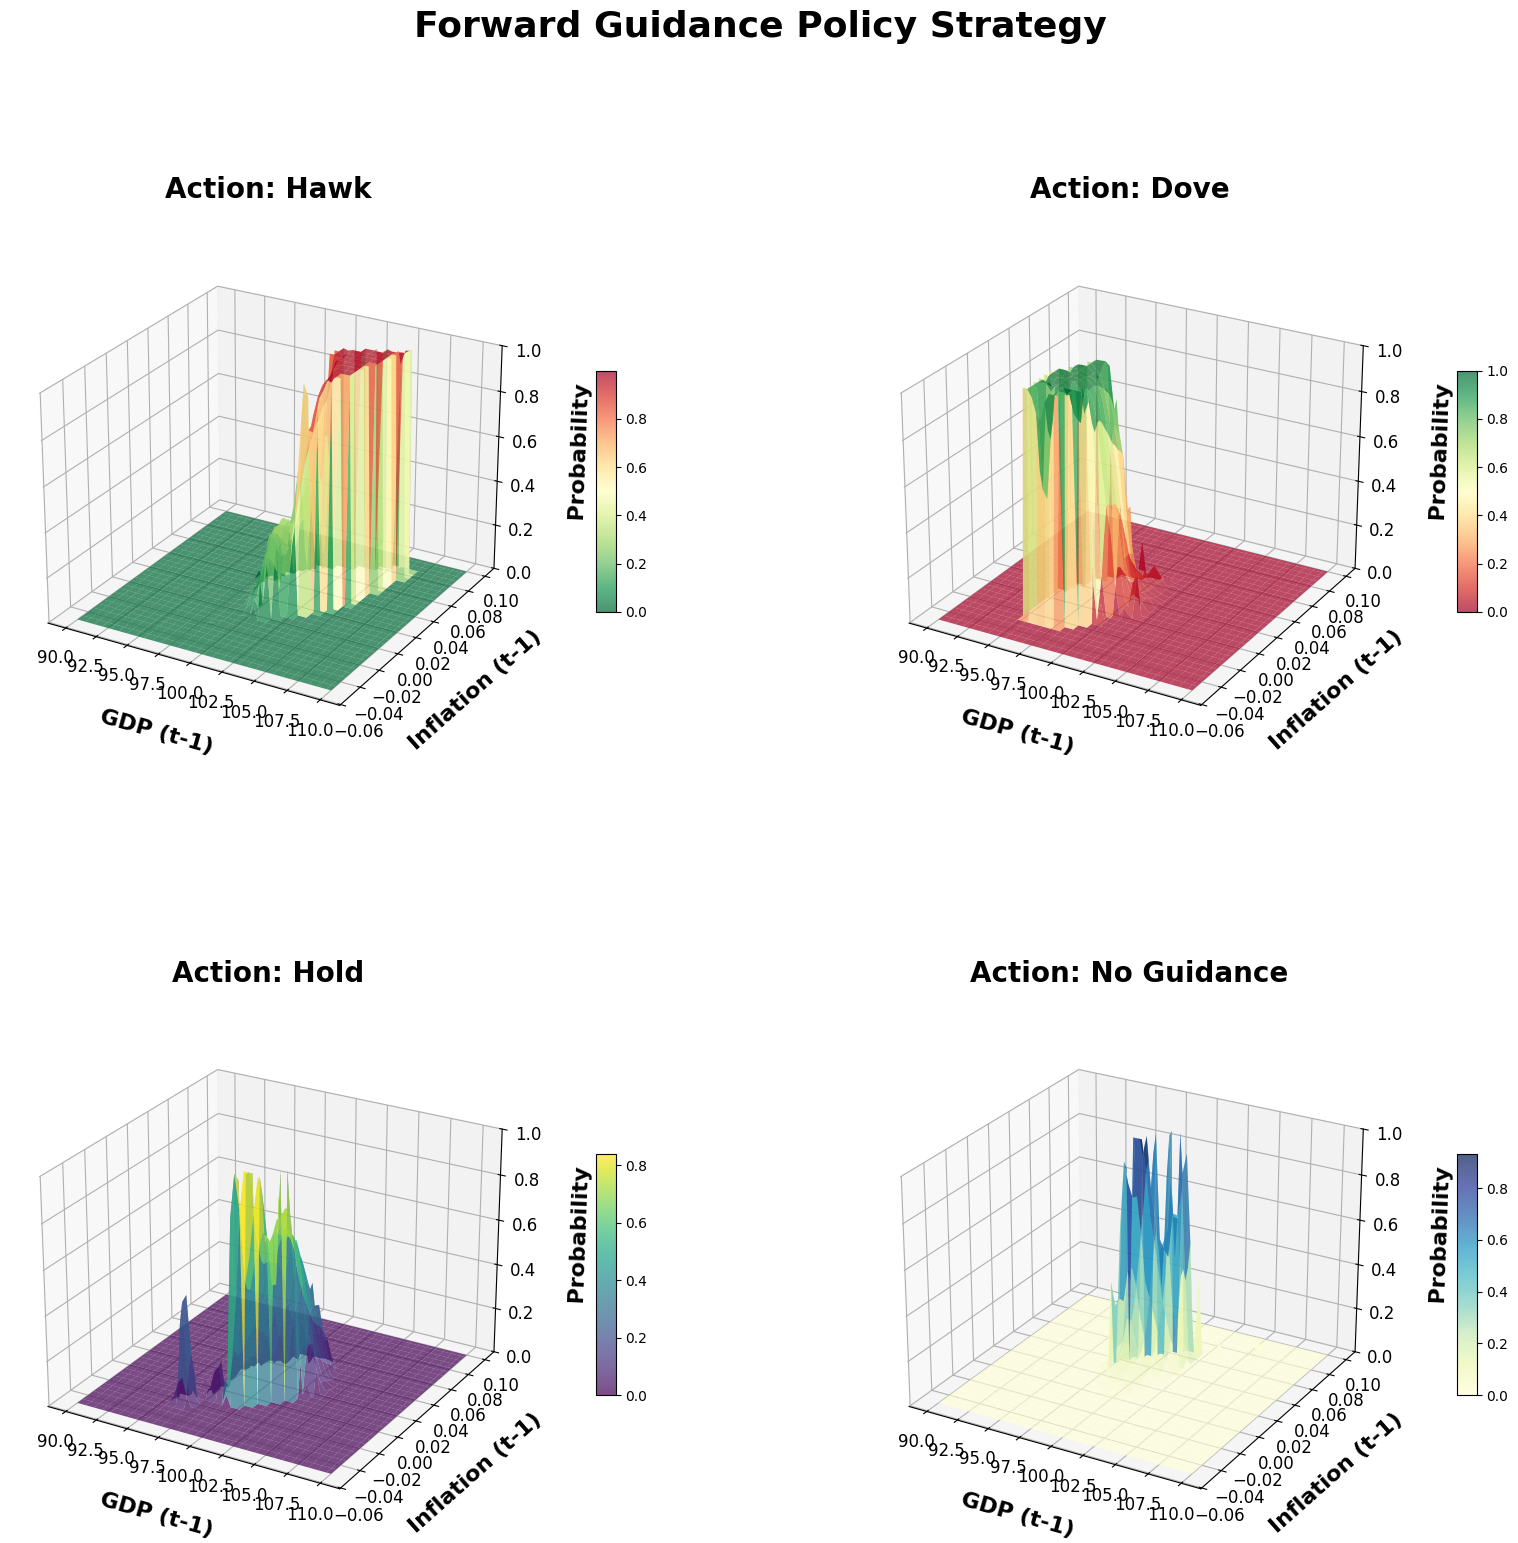

In [ ]:
def plot_all_fg(df, bins=40, save_prefix=None):
    # Set global baseline
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(20, 18)) # Taller for 2x2 layout

    # ---- 1. TRAJECTORY-SAFE SHIFTING ----
    df_plot = df.copy()
    if 'trajectory' in df_plot.columns:
        df_plot['prev_GDP'] = df_plot.groupby('trajectory')['GDP'].shift(1)
        df_plot['prev_Inflation'] = df_plot.groupby('trajectory')['Inflation'].shift(1)
    else:
        df_plot['prev_GDP'] = df_plot['GDP'].shift(1)
        df_plot['prev_Inflation'] = df_plot['Inflation'].shift(1)

    # ---- 2. CLEANING & FILTERING ----
    GDP_MIN, GDP_MAX = 90, 110
    PI_MIN, PI_MAX = -0.05, 0.10

    df_clean = df_plot[
        df_plot['statement_category'].notna() & 
        df_plot['prev_GDP'].notna()
    ].copy()
    
    df_clean = df_clean[
        (df_clean['prev_GDP'].between(GDP_MIN, GDP_MAX)) &
        (df_clean['prev_Inflation'].between(PI_MIN, PI_MAX))
    ]

    categories = ['Hawk', 'Dove', 'Hold', 'No Guidance']

    for idx, action in enumerate(categories, 1):
        # Binned aggregation
        gdp_bins = np.linspace(GDP_MIN, GDP_MAX, bins + 1)
        pi_bins  = np.linspace(PI_MIN, PI_MAX, bins + 1)
        df_clean['gdp_bin'] = pd.cut(df_clean['prev_GDP'], bins=gdp_bins)
        df_clean['pi_bin']  = pd.cut(df_clean['prev_Inflation'], bins=pi_bins)

        prob_df = df_clean.groupby(['gdp_bin', 'pi_bin'], observed=True).apply(
            lambda x: (x['statement_category'] == action).mean()
        ).reset_index(name='probability')

        prob_df['gdp_center'] = prob_df['gdp_bin'].apply(lambda x: x.mid).astype(float)
        prob_df['pi_center']  = prob_df['pi_bin'].apply(lambda x: x.mid).astype(float)
        prob_df = prob_df.dropna()

        # Grid and Interpolation
        gdp_range = np.linspace(GDP_MIN, GDP_MAX, 60)
        pi_range  = np.linspace(PI_MIN, PI_MAX, 60)
        gdp_grid, pi_grid = np.meshgrid(gdp_range, pi_range)

        prob_grid = griddata(
            (prob_df['gdp_center'], prob_df['pi_center']),
            prob_df['probability'], (gdp_grid, pi_grid),
            method='cubic', fill_value=0
        )
        prob_grid = np.clip(prob_grid, 0, 1)

        # ---- PLOTTING (2x2) ----
        ax = fig.add_subplot(2, 2, idx, projection='3d')
        
        # Consistent color mapping
        if action == 'Hawk': cmap = 'RdYlGn_r'
        elif action == 'Dove': cmap = 'RdYlGn'
        elif action == 'Hold': cmap = 'viridis'
        else: cmap = 'YlGnBu'

        surf = ax.plot_surface(gdp_grid, pi_grid, prob_grid, 
                               cmap=cmap, alpha=0.7, edgecolor='none')

        # --- BIG & BOLD STYLING ---
        ax.set_xlabel('GDP (t-1)', fontsize=16, fontweight='bold', labelpad=15)
        ax.set_ylabel('Inflation (t-1)', fontsize=16, fontweight='bold', labelpad=15)
        ax.set_zlabel('Probability', fontsize=16, fontweight='bold', labelpad=15)
        
        ax.set_title(f'Action: {action}', fontsize=20, fontweight='bold', pad=25)
        
        # Increase tick label size for readability
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # View angle and limits
        ax.view_init(elev=25, azim=300)
        ax.set_zlim(0, 1)

        # Colorbar
        cbar = fig.colorbar(surf, ax=ax, shrink=0.4, aspect=12, pad=0.1)
        cbar.ax.tick_params(labelsize=10)

    # Global Figure Title
    fig.suptitle("Forward Guidance Policy Strategy", 
                 fontsize=26, fontweight='bold', y=0.98)
    
    # Adjust subplots to avoid overlapping titles and labels
    plt.subplots_adjust(wspace=0.25, hspace=0.3)

    if save_prefix:
        plt.savefig(f'{save_prefix}_all_fg.pdf', dpi=300, bbox_inches='tight')
    
    return fig

fg_3d = plot_all_fg(ppo_df)
fg_3d.savefig("figs/3d_statements.pdf")

In [ ]:
import textwrap


def reward_dist_plot(
    df,
    policy_col="Simulation Type",
    traj_col="trajectory",
    q_low=0.01,
    q_high=0.99
):
    grouped_df = (
        df.groupby([policy_col, traj_col])["reward"]
          .sum()
          .reset_index()
    )

    # Compute global clipping bounds (shared across policies)
    lo, hi = grouped_df["reward"].quantile([q_low, q_high])

    plot_df = grouped_df[
        grouped_df["reward"].between(lo, hi)
    ]

    plot_df[policy_col] = plot_df[policy_col].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=18))
    )

    p = (
        ggplot(plot_df, aes(x="reward", color = policy_col, fill = policy_col)) +
        geom_density(alpha=0.3, size=2) +
        labs(
            x="Sum of rewards",
            y="Density",
            subtitle=f"Central {int((q_high-q_low)*100)}% of trajectories shown",
            title = "Distribution of sum of rewards across all trajectories"
        ) +
        theme_economy() +
        theme(
        # Title and subtitle
        plot_title=element_text(size=20, weight="bold"),
        plot_subtitle=element_text(size=16),

        # Axis titles
        axis_title_x=element_text(size=16, weight="bold"),
        axis_title_y=element_text(size=16, weight="bold"),

        # Axis ticks
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=14),

        # Legend text (usually needed for balance)
        legend_title=element_text(size=14, weight="bold"),
        legend_text=element_text(size=13),
    )

    )

    return p


p = reward_dist_plot(combined)
dispay(p)
p.save("figs/reward_dist.pdf")

C:\Users\jotin\AppData\Local\Temp\ipykernel_20412\1776026294.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 12 x 8 in image.
c:\Users\jotin\anaconda3\envs\rl_env\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: ../report/figs/reward_dist.pdf
